## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import glob
import time
import requests
import numpy as np
import pandas as pd
import numexpr as ne
from tqdm import tqdm
#from tqdm.auto import tqdm
from numba import njit
from io import StringIO
import astropy.units as au
import matplotlib.pyplot as plt
import threading, multiprocessing
from scipy.special import voigt_profile, wofz, erf, roots_hermite
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
pd.options.mode.chained_assignment = None

## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = '/home/jingxin/PyExoCross-ing/input/MgH_exomol_one.inp'
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.process_time()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath):
    
    # Find the maximum column for all the rows.
    with open(inp_filepath, 'r') as temp_f:
        col_count = max([len([x for x in l.split(" ") if x.strip()]) for l in temp_f.readlines()])
    # Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1).
    column_names = [i for i in range(col_count)] 
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', header = None, names=column_names, usecols=column_names)
    col0 = inp_df[0]
    
    # Database
    database = inp_df[col0.isin(['Database'])][1].values[0].upper()
    
    # Basic information
    molecule = inp_df[col0.isin(['Molecule'])][1].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])][1].values[0]
    dataset = inp_df[col0.isin(['Dataset'])][1].values[0]
    mol_iso_id = int(inp_df[col0.isin(['MolIsoID'])][1])
    
    # File path
    read_path = inp_df[col0.isin(['ReadPath'])][1].values[0]
    save_path = inp_df[col0.isin(['SavePath'])][1].values[0]
    if os.path.exists(save_path):
        pass
    else:
        os.makedirs(save_path, exist_ok=True)
        
    # Functions 
    Conversion = int(inp_df[col0.isin(['Conversion'])][1])
    PartitionFunctions = int(inp_df[col0.isin(['PartitionFunctions'])][1])
    CoolingFunctions = int(inp_df[col0.isin(['CoolingFunctions'])][1])
    Lifetimes = int(inp_df[col0.isin(['Lifetimes'])][1])
    SpecificHeats = int(inp_df[col0.isin(['SpecificHeats'])][1])
    StickSpectra = int(inp_df[col0.isin(['StickSpectra'])][1])
    CrossSections = int(inp_df[col0.isin(['CrossSections'])][1])
    
    # Quantum numbers
    NeedQNs = Conversion + StickSpectra + CrossSections
    if NeedQNs != 0:
        QNslabel_list = list(inp_df[col0.isin(['QNslabel'])].iloc[0])[1:]
        QNsformat_list = list(inp_df[col0.isin(['QNsformat'])].iloc[0])[1:]
        QNslabel_list = [x for x in QNslabel_list if x == x]
        QNsformat_list = [x for x in QNsformat_list if x == x]
    else:
        QNslabel_list = []
        QNsformat_list = []  
    
    # Convert from one format to another
    if Conversion != 0:
        ConversionFormat = int(inp_df[col0.isin(['ConversionFormat'])][1])
        ConversionMinFreq = float(inp_df[col0.isin(['ConversionFrequncyRange'])][1])
        ConversionMaxFreq = float(inp_df[col0.isin(['ConversionFrequncyRange'])][2])
        GlobalQNLabel_list = list(inp_df[col0.isin(['GlobalQNLabel'])].iloc[0].dropna())[1:]
        GlobalQNFormat_list = list(inp_df[col0.isin(['GlobalQNFormat'])].iloc[0].dropna())[1:]
        LocalQNLabel_list = list(inp_df[col0.isin(['LocalQNLabel'])].iloc[0].dropna())[1:]
        LocalQNFormat_list = list(inp_df[col0.isin(['LocalQNFormat'])].iloc[0].dropna())[1:]
        
        ConversionUncYN = inp_df[col0.isin(['ConvUncFilter(Y/N)'])][1].values[0].upper()[0]
        if ConversionUncYN == 'Y':
            ConversionUnc = float(inp_df[col0.isin(['ConvUncFilter(Y/N)'])][2])
        elif ConversionUncYN == 'N':
            ConversionUnc = 'None'
        else:
            raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")  
        
        ConversionThresholdYN = inp_df[col0.isin(['ConvThreshold(Y/N)'])][1].values[0].upper()[0]
        if ConversionThresholdYN == 'Y':
            ConversionThreshold = float(inp_df[col0.isin(['ConvThreshold(Y/N)'])][2])
        elif ConversionThresholdYN == 'N':
            ConversionThreshold = 'None'
        else:
            raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.")    
        
    else:
        ConversionFormat = 0
        ConversionMinFreq = 0
        ConversionMaxFreq = 0
        GlobalQNLabel_list = []
        GlobalQNFormat_list = []
        LocalQNLabel_list = []
        LocalQNFormat_list = []
        ConversionUnc = 'None'
        ConversionThreshold = 'None'
        
    # Calculate partition, cooling functions or specific heats 
    if PartitionFunctions + CoolingFunctions + SpecificHeats != 0:
        Ntemp = int(inp_df[col0.isin(['Ntemp'])][1])    # The number of temperature steps
        Tmax = int(inp_df[col0.isin(['Tmax'])][1])      # Maximal temperature in K (minimal T = 1 K )
    else:
        Ntemp = 0
        Tmax = 0  
     
    # Calculate lifetimes 
    # None
    
    # Calculate stick spectra or cross sections 
    if StickSpectra + CrossSections != 0:
        T = int(inp_df[col0.isin(['Temperature'])][1])
        min_wn = float(inp_df[col0.isin(['Range'])][1])
        max_wn = float(inp_df[col0.isin(['Range'])][2])
        abs_emi = inp_df[col0.isin(['Absorption/Emission'])][1].values[0].upper()[0]
        
        UncFilterYN = inp_df[col0.isin(['UncFilter(Y/N)'])][1].values[0].upper()[0]
        if UncFilterYN == 'Y':
            UncFilter = float(inp_df[col0.isin(['UncFilter(Y/N)'])][2])
        elif UncFilterYN == 'N':
            UncFilter = 'None'
        else:
            raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")  
        
        thresholdYN = inp_df[col0.isin(['Threshold(Y/N)'])][1].values[0].upper()[0]
        if thresholdYN == 'Y':
            threshold = float(inp_df[col0.isin(['Threshold(Y/N)'])][2])
        elif thresholdYN == 'N':
            threshold = 'None'
        else:
            raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.") 
         
    else:
        T = 0
        min_wn = 0
        max_wn = 0
        abs_emi = 'None'
        UncFilter = 'None'
        threshold = 'None'
        
    # Stick spectra
    if StickSpectra != 0:
        PlotStickSpectraYN = inp_df[col0.isin(['PlotStickSpectra(Y/N)'])][1].values[0].upper()[0]
    else:
        PlotStickSpectraYN = 'None'

    # Cross sections
    if CrossSections != 0:
        NpointsORBinSize = inp_df[col0.isin(['Npoints/BinSize'])][1].values[0].upper()
        if 'POI' in NpointsORBinSize:
            N_point = int(inp_df[col0.isin(['Npoints/BinSize'])][2])
            bin_size = float((max_wn - min_wn)/(N_point-1))
        elif 'BIN' in NpointsORBinSize or 'SIZ' in NpointsORBinSize:
            bin_size = float(inp_df[col0.isin(['Npoints/BinSize'])][2])
            N_point = int((max_wn - min_wn)/bin_size+1)
        else:
            raise ImportError("Please type the correct grid choice 'Npoints' or 'BinSize' into the input file.")

        cutoffYN = inp_df[col0.isin(['Cutoff(Y/N)'])][1].values[0].upper()[0]
        if cutoffYN == 'Y':
            cutoff = float(inp_df[col0.isin(['Cutoff(Y/N)'])][2])
        elif cutoffYN == 'N':
            cutoff = 'None'
        else:
            raise ImportError("Please type the correct cutoff choice 'Y' or 'N' into the input file.")

        QNsFilterYN = inp_df[col0.isin(['QNsFilter(Y/N)'])][1].values[0].upper()[0]
        if QNsFilterYN == 'Y':
            QNsFilter = list(inp_df[col0.isin(['QNsFilter(Y/N)'])].iloc[0].dropna())[2:]
            QNs_label = []
            QNs_value = []
            for i in range(len(QNsFilter)):
                QNs_label.append(QNsFilter[i].split('[')[0])
                QNs_value.append(QNsFilter[i].split('[')[1].split(']')[0].split(','))
        elif QNsFilterYN == 'N':
            QNsFilter = []
            QNs_label = []
            QNs_value = []
        else:
            raise ImportError("Please type the correct quantum number filter choice 'Y' or 'N' into the input file.")
          
        P = float(inp_df[col0.isin(['Pressure'])][1])
        broadeners = list(inp_df[col0.isin(['Broadeners'])].iloc[0])[1:]
        broadeners = [i for i in broadeners if i is not np.nan]
        ratios = np.array(list(inp_df[col0.isin(['Ratios'])].iloc[0])[1:], dtype=float)
        ratios = ratios[~np.isnan(ratios)]
        wn_grid = np.linspace(min_wn, max_wn, N_point)
        wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])][1].values[0].upper()
        profile = inp_df[col0.isin(['Profile'])][1].values[0].upper().replace('PRO','')
        
        DopplerHWHMYN = inp_df[col0.isin(['DopplerHWHM(Y/N)'])][1].values[0].upper()[0]        
        if 'DOP' in profile: 
            alpha_HWHM = 'None'
        elif 'GAU' in profile:
            if DopplerHWHMYN == 'Y':
                alpha_HWHM = float(inp_df[col0.isin(['DopplerHWHM(Y/N)'])][2])
            else:
                raise ImportError("Gaussian line profile requires a HWHM. " 
                                  + "Please choose 'Y' and give a value for Doppler HWHM in the input file. " 
                                  + "Otherwise, please choose Doppler line profile " 
                                  + "(with calculated temperature-dependent Doppler HWHM).")
        elif 'VOI' in profile:
            if DopplerHWHMYN == 'Y':
                alpha_HWHM = float(inp_df[col0.isin(['DopplerHWHM(Y/N)'])][2])
            elif DopplerHWHMYN == 'N':
                alpha_HWHM = 'None'
            else:
                raise ImportError("Please type the correct Doppler HWHM choice 'Y' or 'N' into the input file.")
        else:
            raise ImportError("Please type the correct line profile.")
            
        LorentzianHWHMYN = inp_df[col0.isin(['LorentzianHWHM(Y/N)'])][1].values[0].upper()[0]  
        if LorentzianHWHMYN == 'Y':
            gamma_HWHM = float(inp_df[col0.isin(['LorentzianHWHM(Y/N)'])][2])
        elif LorentzianHWHMYN == 'N':
            gamma_HWHM = 'None'
        else:
            raise ImportError("Please type the correct Lorentzian HWHM choice 'Y' or 'N' into the input file.")
        
        PlotCrossSectionYN = inp_df[col0.isin(['PlotCrossSection(Y/N)'])][1].values[0].upper()[0]
        
    else:
        bin_size = 'None'
        N_point = 'None'
        cutoff = 'None'
        QNsFilter = []
        QNs_label = []
        QNs_value = []           
        alpha_HWHM = 'None'        
        gamma_HWHM = 'None'
        broadeners = []
        ratios = np.array([])
        P = 0
        wn_grid = np.linspace(0,1,1)
        profile = 'None'
        wn_wl = 'None'
        PlotCrossSectionYN = 'None'
                   
    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
        
    if database == 'EXOMOL':
        # Read ExoMol definition file (.def) to get the mass.
        deffile_path = (read_path+'/'+molecule+'/'+isotopologue+'/'+dataset+'/'+isotopologue+'__'+dataset+'.def')
        def_df = pd.read_csv(deffile_path,sep='\\s+',usecols=[0,1,2,3,4],names=['0','1','2','3','4'],header=None)
        abundance = 1
        mass = float(def_df[def_df['4'].isin(['mass'])]['0'].values[0])     # ExoMol mass (Dalton)
        if def_df.to_string().find('Uncertainty') != -1:
            check_uncertainty = int(def_df[def_df['2'].isin(['Uncertainty'])]['0'].values[0])
        else:
            check_uncertainty = 0
        check_lifetime = int(def_df[def_df['2'].isin(['Lifetime'])]['0'].values[0])
        check_gfactor = int(def_df[def_df['3'].isin(['g-factor'])]['0'].values[0])
    elif database == 'HITRAN':
        isometa_url = 'https://hitran.org/docs/iso-meta/'
        iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
        iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
        abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
        mass = float(iso_meta_row['Molar Mass /g·mol-1'])                   # HITRAN molar mass (g/mol)
        check_uncertainty = 0
        check_lifetime = 0
        check_gfactor = 0
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    

    return (database, molecule, isotopologue, dataset, read_path, save_path, 
            Conversion, PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, StickSpectra, CrossSections,
            ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
            GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
            Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
            cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNsFilter, 
            alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass,
            check_uncertainty, check_lifetime, check_gfactor, PlotStickSpectraYN, PlotCrossSectionYN)

## Constants and Parameters

In [5]:
# Parameters for calculating
import astropy.constants as ac
#from astropy import constants, units as ac, au
Tref = 296.0                        # Reference temperature is 296 K
Pref = 1.0                          # Reference pressure is 1 bar
N_A = ac.N_A.value                  # Avogadro number (1/mol)
h = ac.h.to('erg s').value          # Planck's const (erg s)
c = ac.c.to('cm/s').value           # Velocity of light (cm/s)
kB = ac.k_B.to('erg/K').value       # Boltzmann's const (erg/K)
R = ac.R.to('J / (K mol)').value    # Molar gas constant (J/(K mol))
c2 = h * c / kB                     # Second radiation constant (cm K)

(database, molecule, isotopologue, dataset, read_path, save_path, 
 Conversion, PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, StickSpectra, CrossSections,
 ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
 GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
 Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
 cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNsFilter, 
 alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass, 
 check_uncertainty, check_lifetime, check_gfactor, PlotStickSpectraYN, PlotCrossSectionYN) = inp_para(inp_filepath)


c2InvTref = c2 / Tref                 # c2 / T_ref (cm)
PI = np.pi
ln22 = np.log(2)*2
sinPI = np.sin(np.pi)
SqrtPI = np.sqrt(np.pi)
Sqrtln2 = np.sqrt(np.log(2))
OneminSqrtPIln2 = 1 - np.sqrt(np.pi * np.log(2))
Negln2 = -np.log(2)
Inv8Pic = 1 / (8 * np.pi * c)         # 8 * pi * c (s/cm)
Inv4Pi = 1 / (4 * np.pi)
Inv2ln2 = 1 / (2 * np.log(2))
InvSqrt2 = 1 / np.sqrt(2)
InvSqrtPi= 1 / np.sqrt(np.pi)
InvSprtln2 = 1 / np.sqrt(np.log(2))
InvSqrt2Pi = 1 / np.sqrt(2 * np.pi)
InvSqrt2ln2 = 1 / np.sqrt(2 * np.log(2))
TwoSqrt2ln2 = 2 * np.sqrt(2 * np.log(2))
Sqrtln2InvPi = np.sqrt(np.log(2) / np.pi)
Sqrt2NAkBln2mInvc = np.sqrt(2 * N_A * kB * np.log(2) / mass) / c
if bin_size != 'None':
    binSize2 = bin_size * 2
    binSizePI = bin_size * np.pi
    binSizeHalf = bin_size / 2 
    InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)


InvbinSizePI3lnPI = 1 / (bin_size * np.pi**3 * np.log(np.pi))
constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
# Sqrt2NAkBln2mInvc = np.sqrt(2 * kB * np.log(2) / (mass*au.u.to(au.g))) / c


# Read Input Files

Read the parameters of the linelist in ExoMol or HITRAN format text file. Return the dataframe of the data for the following calculations.

## Read ExoMol Database Files

### Read States File

In [6]:
def read_all_states(read_path):
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset 
                                 + '/' + isotopologue + '__' + dataset + '.states.bz2')

    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=100000, iterator=True, low_memory=False, dtype=object)
        for chunk in s_df[states_filename]:
            states_df = pd.concat([states_df, chunk])
    if check_uncertainty == 1:
        states_df = states_df.rename(columns={0:'id',1:'E',2:'g',3:'J',4:'unc'})
    else:      
        states_df = states_df.rename(columns={0:'id',1:'E',2:'g',3:'J'})
            
    pd.set_option("display.max_columns",30)                           
    return(states_df)

In [7]:
#states_df = read_all_states(read_path)
#states_df 

In [8]:
#sd = states_df
#sd[sd['E'].astype(float) <= 1500]

### Read transitions File

In [9]:
def get_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            if len(split_version[0].split('-')) == 2:
                trans_filepaths.append(trans_filepaths_all[i])
    return(trans_filepaths)    

In [10]:
def read_all_trans(read_path):
    t_df = dict()
    trans_df = pd.DataFrame()
    trans_col_name = ['u', 'l', 'A', 'v']
    trans_filepaths = get_transfiles(read_path)
    print('Reading the transitions ...')
    for trans_filename in tqdm(trans_filepaths, position=0, leave=True, ascii=True):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
                                           names=trans_col_name, chunksize=100000, iterator=True, low_memory=False)
        for chunk in t_df[trans_filename]:
            trans_df = pd.concat([trans_df,chunk])
            
    #pd.set_option("display.max_columns",30)                           
    return(trans_df)
    

In [11]:
all_trans_df = read_all_trans(read_path)
all_trans_df

Reading the transitions ...


100%|##########| 1/1 [00:00<00:00, 650.08it/s]


,u,l,A,v
0,174,516,0.055202,4064.574702


## Convert among the frequency, upper and lower state energy

In [12]:
def cal_v(Ep, Epp):
    v = ne.evaluate('abs(Ep - Epp)')
    return(v)

In [13]:
def cal_Ep(Epp, v):
    Ep = ne.evaluate('abs(Epp + v)')
    return(Ep)

### Read Partition Function File From ExoMol Database

In [14]:
def read_exomolweb_pf(T):
    
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]

    return(Q)

In [15]:
def read_exomol_pf(read_path, T):
    
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]

    return(Q)

### Read Broadening File

In [16]:
def read_broad(read_path):
    broad_df = pd.DataFrame()
    broad_dfs = []
    broad = []
    ratio = []
    for i in range(len(ratios)):
        if ratios[i] != 0.0:
            if broadeners[i].upper()[0:3] == 'DEF':
                default_gamma_L = 0.07
                default_n_air = 0.5
                broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']])
                broad_df = broad_df.rename(columns={0:'code', 1:'gamma_L', 2:'n_air', 3:'Jpp'})
                broad_dfs.append(broad_df)
            else:
                broadener_name = str(broadeners[i])
                pattern_broadener = read_path + molecule + '/**/*' + broadener_name + '.broad'
                if glob.glob(pattern_broadener, recursive=True) != []:
                    for fname_broadener in glob.glob(pattern_broadener, recursive=True):
                        broad_df = pd.read_csv(fname_broadener, sep='\s+', header=None, engine='python')
                        broad_df = broad_df.rename(columns={0:'code', 1:'gamma_L', 2:'n_air', 3:'Jpp'})
                        broad_dfs.append(broad_df)
                else:
                    raise ImportError('The ' + broadener_name + ' boradening file does not exist.') 
            broad.append(broadeners[i])
            ratio.append(ratios[i])
    nbroad = len(broad)
    broad = list(i for i in broad if i==i)
    ratio = list(i for i in ratio if i==i)
    print('Broadeners \t: ', str(broad).replace('[','').replace(']','').replace("'",''))
    print('Ratios \t\t: ', str(ratio).replace('[','').replace(']',''))
    return(broad, ratio, nbroad, broad_dfs)        


## Read HITRAN Database Files

### Read HITRAN Linelist File

In [17]:
def read_hitran_parfile (read_path, parfile_df):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2020 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = read_path.split('/')[-1]
    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2020 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()
    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int32')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int32')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2}))
    hitran_df['A'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')             # The Einstein-A coefficient (s^{-1}) of a transition
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    hitran_df['Unc'] = parfile_df[0].map(lambda x: x[127:128])                                                          # Uncertainty code, first integer in the error code
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('float64')          # Statistical weight of the upper state
    hitran_df['gpp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[153:160]), errors='coerce').astype('float64')         # Statistical weight of the upper state
    
    hitran_df = hitran_df[hitran_df['M'].isin([molecule_id])]
    hitran_df = hitran_df[hitran_df['I'].isin([isotopologue_id])]
    hitran_df = hitran_df[hitran_df['v'].between(min_wn, max_wn)]
    if threshold != 'None':
        hitran_df = hitran_df[hitran_df['S'] >= threshold]
    
    return hitran_df


In [18]:
def read_parfile(read_path):
    if not os.path.exists(read_path):
        raise ImportError('The input file ' + read_path + ' does not exist.')

    # Initialise the iterator object.
    read_par = pd.read_csv(read_path, chunksize=10000, iterator=True, header=None, encoding='utf-8')
    par_df = pd.DataFrame()
    for chunk in read_par:
        par_df = pd.concat([par_df, chunk])
    return(par_df)

### Read Partition Function File From HITRANOnline

In [19]:
def read_hitran_pf(T):
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    #Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]   
    return(Q)

# Calculate Parition Function


In [20]:
def calculate_partition(En, gn, T):
    partition_func = ne.evaluate('sum(gn * exp(-c2 * En / T))') 
    return(partition_func)

In [21]:
# Partition function
def exomol_partition_func(states_df, Ntemp, Tmax):
    
    print('Calculate partition functions.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    En = states_df['E'].astype('float').values
    gn = states_df['g'].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    
    partition_func = [calculate_partition(En, gn, T) for T in Ts]
    
    partition_func_df = pd.DataFrame()
    partition_func_df['T'] = Ts
    partition_func_df['partition function'] = partition_func
        
    pf_folder = save_path + '/partition/'
    if os.path.exists(pf_folder):
        pass
    else:
        os.makedirs(pf_folder, exist_ok=True)
    pf_path = pf_folder + isotopologue + '__' + dataset + '.pf'
    np.savetxt(pf_path, partition_func_df, fmt="%8.1f %15.4f")
    
    t.end()
    print('Partition functions has been saved!\n')  


In [22]:
#Ntemp = 1
#max = int(5000.00)

#exomol_partition_func(states_df, Ntemp, Tmax)

# Specific Heat

In [23]:
def calculate_specific_heats(En, gn, T):
    pf = ne.evaluate('sum(gn * exp(-c2 * En / T)) ')  
    pfp = ne.evaluate('sum(gn * exp(-c2 * En / T) * (c2 * En / T))')
    pfpp = ne.evaluate('sum(gn * exp(-c2 * En / T) * (c2 * En / T) ** 2)')
    specificheat_func = ne.evaluate('R * (pfpp / pf - (pfp / pf)**2) + 2.5 * R') 
    return(specificheat_func)

In [24]:
# Specific heat
def exomol_specificheat(states_df, Ntemp, Tmax):
    print('Calculate specific heats.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    En = states_df['E'].astype('float').values
    gn = states_df['g'].astype('int').values
    Ts = np.array(range(200, Tmax+1, Ntemp)) 
    
    specificheat_func = [calculate_specific_heats(En, gn, T) for T in Ts]
    
    specificheat_func_df = pd.DataFrame()
    specificheat_func_df['T'] = Ts
    specificheat_func_df['specific heat'] = specificheat_func
        
    cp_folder = save_path + '/specific_heat/'
    if os.path.exists(cp_folder):
        pass
    else:
        os.makedirs(cp_folder, exist_ok=True)  
    cp_path = cp_folder + isotopologue + '__' + dataset + '.cp'
    np.savetxt(cp_path, specificheat_func_df, fmt="%8.1f %15.4f")

    t.end()
    print('Specific heats has been saved!\n')  


In [25]:
#Ntemp = 1
#Tmax = int(5000.0)

#exomol_specificheat(states_df, Ntemp, Tmax)


# Lifetime

In [26]:
# Lifetime
def exomol_lifetime(read_path, states_df, all_trans_df):
    
    print('Calculate lifetimes.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    #all_trans_df = read_all_trans(read_path)
    sum_A = all_trans_df.groupby('u')['A'].sum()
    lifetime = ne.evaluate('1 / sum_A') 
    lt_df = pd.Series(lifetime).map('{: >12.4E}'.format).reset_index()
    lt_df.columns=['u','lt']
    uid = lt_df['u']
    add_u = pd.DataFrame()
    add_u['u'] = pd.concat([states_df['id'].astype('int'), uid]).drop_duplicates(keep=False)
    add_u['lt'] = '         inf'
    lifetime_df = pd.concat([lt_df, add_u], ignore_index=True)
    lifetime_df.sort_values('u',inplace=True)
    
    states_filenames = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset 
                                 + '/' + isotopologue + '__' + dataset + '.states.bz2')
    s_df = pd.read_csv(states_filenames[0], compression='bz2', header=None, dtype=object)
    lifetime_list = list(lifetime_df['lt'])
    nrows = len(s_df)
    new_rows = []
    if check_uncertainty == 0:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:41]+lifetime_list[i]+s_df[0][i][53:]+'\n')
    if check_uncertainty == 1:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:53]+lifetime_list[i]+s_df[0][i][65:]+'\n')

    lf_folder = save_path + '/lifetime/'
    if os.path.exists(lf_folder):
        pass
    else:
        os.makedirs(lf_folder, exist_ok=True)  
        
    ##### bz2 #####
    '''
    lf_path = lf_folder + isotopologue + '__' + dataset + '.states.bz2'

    with bz2.open(lf_path, 'wt') as f:
        for i in range(nrows):
            f.write(new_rows[i])
        f.close'''
    ###############
    
    ##### states #####
    lf_path = lf_folder + isotopologue + '__' + dataset + '.states'

    with open(lf_path, 'wt') as f:
        for i in range(nrows):
            f.write(new_rows[i])
        f.close
    ##################

    t.end()
    print('Lifetimes has been saved!\n')   


In [27]:
#exomol_lifetime(read_path, states_df, all_trans_df)

# Cooling Function

In [28]:
def linelist_coolingfunc(states_df, all_trans_df):
    #states_df = read_all_states(read_path)
    #all_trans_df = read_all_trans(read_path)
    id_u = all_trans_df['u'].values
    id_l = all_trans_df['l'].values
    states_df['id'] = pd.to_numeric(states_df['id'])
    states_df.set_index(['id'], inplace=True, drop=False)
    id_s = states_df['id']
    all_trans_df.set_index(['u'], inplace=True, drop=False)
    id_us = list(set(id_u).intersection(set(id_s)))
    trans_us_df = all_trans_df.loc[id_us]
    id_l = trans_us_df['l'].values
    id_ls = list(set(id_l).intersection(set(id_s)))
    trans_us_df.set_index(['l'], inplace=True, drop=False)
    trans_s_df = trans_us_df.loc[id_ls]
    id_su = trans_s_df['u'].values
    id_sl = trans_s_df['l'].values
    states_u_df = states_df.loc[id_su]
    states_l_df = states_df.loc[id_sl]

    Ep = states_u_df['E'].values.astype('float')
    gp = states_u_df['g'].values.astype('int')
    A = trans_s_df['A'].values.astype('float')

    if pd.isna(all_trans_df['v']).iloc[0] == False:
        v = trans_s_df['v'].values.astype('float')
    else:
        Epp = states_l_df['E'].astype('float') # Upper state energy
        v = cal_v(Ep, Epp) 
    return (A, v, Ep, gp)

In [29]:
def calculate_cooling(A, v, Ep, gp, T, Q):
    # cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * PI * Q) 
    _sum = ne.evaluate('sum(A * h * c * v * gp * exp(-c2 * Ep / T))')  
    cooling_func = ne.evaluate('_sum / (4 * PI * Q)')
    return(cooling_func)

In [30]:
# Cooling function
def exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax):
    
    print('Calculate cooling functions.')  
    t = Timer()
    t.start()
    
    A, v, Ep, gp = linelist_coolingfunc(states_df, all_trans_df)
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = [read_exomol_pf(read_path, T) for T in Ts]
    
    cooling_func = [calculate_cooling(A, v, Ep, gp, T, Q) for T,Q in zip(Ts,Qs)]
    
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func

    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = cf_folder + isotopologue + '__' + dataset + '.cf' 
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    
    t.end()
    print('Cooling functions has been saved!\n')   

In [31]:
#Ntemp = 1
#Tmax = int(1500.00)

#exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax)

# Process data

In [32]:
def read_part_states(states_df):

    if UncFilter != 'None' :
        states_part_df = states_df[states_df['unc'].astype(float) <= UncFilter]
        states_part_df['id'] = pd.to_numeric(states_part_df['id'])
        states_part_df.set_index(['id'], inplace=True, drop=False)
    else:
        states_part_df = states_df
        states_part_df['id'] = pd.to_numeric(states_part_df['id'])
        states_part_df.set_index(['id'], inplace=True, drop=False)
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    colname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_part_df.drop(states_part_df.columns[len(colname):], axis=1, inplace=True)
    states_part_df.columns = colname
    if QNsFilter !=[]:    
        for i in range(len(QNs_label)):
            states_part_df = states_part_df[states_part_df[QNs_label[i]].isin(QNs_value[i])]
    pd.set_option("display.max_columns",30)  
    return(states_part_df)

In [33]:
def get_part_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob(read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            elif len(split_version[0].split('-')) == 2:
                trans_filepaths.append(trans_filepaths_all[i])
        
    if len(trans_filepaths) == 1:
        filenames = trans_filepaths
    else:
        filenames = []
        for trans_filename in tqdm(trans_filepaths, position=0, leave=True, ascii=True):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1]) 
            if (lower <= int(min_wn) <= upper):
                filenames.append(trans_filename)
            if (lower >= int(min_wn) and upper <= int(max_wn)):
                filenames.append(trans_filename)
            if (lower <= int(max_wn) <= upper):
                filenames.append(trans_filename)   
    return(filenames)     


In [34]:
def read_part_trans(read_path):
    trans_filenames = get_part_transfiles(read_path)
    t_df = dict()
    trans_part_df = pd.DataFrame()
    # Initialise the iterator object.
    trans_col_name = ['u', 'l', 'A', 'v']
    for trans_filename in tqdm(trans_filenames, position=0, leave=True, ascii=True):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                           names=trans_col_name, chunksize=10000, iterator=True, encoding='utf-8')
        for chunk in t_df[trans_filename]:
            trans_part_df = pd.concat([trans_part_df, chunk])
    return(trans_part_df)

In [35]:
def extract_broad(broad_df, states_l_df):
    J_df = pd.DataFrame()
    max_broad_J = max(broad_df['Jpp'])
    J_df['Jpp'] = states_l_df['J'].values.astype('float')
    J_df['Jpp'][J_df.Jpp > max_broad_J] = max_broad_J
    id_broad = (J_df['Jpp']-0.1).round(0).astype(int)
    gamma_L = broad_df['gamma_L'][id_broad].values
    n_air = broad_df['n_air'][id_broad].values
    return(gamma_L, n_air)

# Intensity

In [36]:
def cal_abscoefs(v, gp, A, Epp, Q, abundance):
    #abscoef = gp * A * np.exp(- c2 * Epp / T) * (1 - np.exp(- c2 * v / T)) / (8 * np.pi * c * v**2 * Q) * abundance  
    abscoef = ne.evaluate('gp * A * exp(- c2 * Epp / T) * (1 - exp(- c2 * v / T)) * Inv8Pic / (v ** 2 * Q) * abundance')  
    return abscoef

In [37]:
def cal_emicoefs(v, gp, A, Ep, Q, abundance):
    # emicoef = gp * A * v * np.exp(- c2 * Ep / T) / (4 * np.pi) / Q * abundance   
    emicoef = ne.evaluate('gp * A * v * exp(- c2 * Ep / T) * Inv4Pi / Q * abundance')
    return emicoef

# Uncertainty

In [38]:
def cal_uncertainty(unc_u, unc_l):
    unc = ne.evaluate('sqrt(unc_u ** 2 + unc_l ** 2)')
    return unc

# Conversion

## ExoMol to HITRAN


In [39]:
def convert_QNValues_exomol2hitran(states_unc_df, GlobalQNLabel_list, LocalQNLabel_list):
    QNLabel_list = GlobalQNLabel_list+LocalQNLabel_list
    if 'Gtot' in QNLabel_list:
        states_unc_df["Gtot"] = (states_unc_df["Gtot"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))
    if 'Gvib' in QNLabel_list:
        states_unc_df["Gvib"] = (states_unc_df["Gvib"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))   
    if 'Grot' in QNLabel_list:
        states_unc_df["Grot"] = (states_unc_df["Grot"].replace('1',"A1'").replace('2',"A2'").replace('3',"E'")
                                 .replace('4','A1"').replace('5','A2"').replace('6','E"'))                   
    if 'taui' in QNLabel_list:
        states_unc_df["taui"] = states_unc_df["taui"].replace('0','s').replace('1','a')
    return(states_unc_df)

In [40]:
def read_unc_states(states_df):
    if Conversion != 0:
        if ConversionUnc != 'None':
            states_unc_df = states_df[states_df['unc'].astype(float) <= ConversionUnc]
        else:
            states_unc_df = states_df
        states_unc_df['id'] = pd.to_numeric(states_unc_df['id'])
        states_unc_df.set_index(['id'], inplace=True, drop=False)
    else:
        states_unc_df = states_df
        states_unc_df['id'] = pd.to_numeric(states_unc_df['id'])
        states_unc_df.set_index(['id'], inplace=True, drop=False)
    if check_uncertainty == 1:
        col_unc = ['unc']
    else:
        col_unc = []
    if check_lifetime == 1:
        col_lifetime = ['tau']
    else:
        col_lifetime = []
    if check_gfactor == 1:
        col_gfac = ['gfac']
    else:
        col_gfac = []
    fullcolname = ['id','E','g','J'] + col_unc + col_lifetime + col_gfac + QNslabel_list
    states_unc_df = states_unc_df.iloc[:, : len(fullcolname)]
    states_unc_df.columns = fullcolname  
    colnames = ['id','E','g'] + col_unc + GlobalQNLabel_list + LocalQNLabel_list
    states_unc_df = states_unc_df[colnames] 
    states_unc_df = convert_QNValues_exomol2hitran(states_unc_df, GlobalQNLabel_list, LocalQNLabel_list)
    #pd.set_option("display.max_columns",30) 
    return(states_unc_df)

In [41]:
def convert_QNFormat_exomol2hitran(states_u_df, states_l_df, GlobalQNLabel_list, GlobalQNFormat_list, 
                                   LocalQNLabel_list, LocalQNFormat_list):
    from pandarallel import pandarallel
    pandarallel.initialize(nb_workers=8,progress_bar=False)    # Initialize.

    gQNp = pd.DataFrame()
    gQNpp = pd.DataFrame()
    n_gQN = len(GlobalQNLabel_list)
    for i in range(n_gQN):
        gQN_format = GlobalQNFormat_list[i].replace("%",'{: >')+'}'
        gQN_label = GlobalQNLabel_list[i]
        try:
            if 'd' in gQN_format or 'f' in gQN_format: 
                gQNp[gQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[gQN_label]
                                                              .values)).parallel_map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[gQN_label]
                                                               .values)).parallel_map(gQN_format.format)
            elif 's' in gQN_format or 'a' in gQN_format: 
                gQNp[gQN_label+"'"] = pd.Series(states_u_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(states_l_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(gQN_format.format)
        except:
            if 'd' in gQN_format or 'f' in gQN_format: 
                gQNp[gQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[gQN_label].values)).map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[gQN_label].values)).map(gQN_format.format)
            elif 's' in gQN_format or 'a' in gQN_format:       
                gQNp[gQN_label+"'"] = pd.Series(states_u_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(gQN_format.format)
                gQNpp[gQN_label+'"'] = pd.Series(states_l_df[gQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(gQN_format.format)
    globalQNp = pd.DataFrame(gQNp).sum(axis=1).map('{: >15}'.format) 
    globalQNpp = pd.DataFrame(gQNpp).sum(axis=1).map('{: >15}'.format)  

    lQNp = pd.DataFrame()
    lQNpp = pd.DataFrame()
    n_lQN = len(LocalQNLabel_list)
    for i in range(n_lQN):
        lQN_format = LocalQNFormat_list[i].replace("%",'{: >')+'}'
        lQN_label = LocalQNLabel_list[i]
        try:
            if 'd' in lQN_format or 'f' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[lQN_label].values)).parallel_map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[lQN_label].values)).parallel_map(lQN_format.format)
            elif 's' in lQN_format or 'a' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(states_u_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(states_l_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).parallel_map(lQN_format.format)
        except:
            if 'd' in lQN_format or 'f' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(pd.to_numeric(states_u_df[lQN_label].values)).map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(pd.to_numeric(states_l_df[lQN_label].values)).map(lQN_format.format)
            elif 's' in lQN_format or 'a' in lQN_format: 
                lQNp[lQN_label+"'"] = pd.Series(states_u_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(lQN_format.format)
                lQNpp[lQN_label+'"'] = pd.Series(states_l_df[lQN_label].str.replace('(','',regex=True)
                                                .str.replace(')','',regex=True).values).map(lQN_format.format)
            
    localQNp = pd.DataFrame(lQNp).sum(axis=1).map('{: >15}'.format) 
    localQNpp = pd.DataFrame(lQNpp).sum(axis=1).map('{: >15}'.format)  

    QN_df = pd.concat([globalQNp,globalQNpp,localQNp,localQNpp],axis='columns')
    QN_df.columns = ["V'", 'V"', "Q'", 'Q"']
    return(QN_df)

In [42]:
def linelist_ExoMol2HITRAN(states_unc_df,trans_part_df):
    
    if pd.isna(trans_part_df['v']).values[0] == False:
        trans_part_df = trans_part_df[trans_part_df['v'].between(ConversionMinFreq,ConversionMaxFreq)] 
        id_u = trans_part_df['u'].values
        id_s = states_unc_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        trans_s_df.sort_values(by=['v'], inplace=True)
    else:
        id_u = trans_part_df['u'].values
        id_s = pd.to_numeric(states_unc_df['id']).values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_unc_df.loc[id_su]
        states_l_df = states_unc_df.loc[id_sl]

        Ep = states_u_df['E'].values.astype('float')
        Epp = states_l_df['E'].values.astype('float')
        trans_s_df['v'] = cal_v(Ep, Epp)
        trans_s_df = trans_s_df[trans_s_df['v'].between(ConversionMinFreq,ConversionMaxFreq)] 
        trans_s_df.sort_values(by=['v'], inplace=True)
        
    id_su = trans_s_df['u'].values
    id_sl = trans_s_df['l'].values
    states_u_df = states_unc_df.loc[id_su]
    states_l_df = states_unc_df.loc[id_sl]

    Ep = states_u_df['E'].values.astype('float')
    Epp = states_l_df['E'].values.astype('float')
    gp = states_u_df['g'].values.astype('int')
    gpp = states_l_df['g'].values.astype('int')
    A = trans_s_df['A'].values.astype('float')
    v = trans_s_df['v'].values.astype('float')
    unc_u = states_u_df['unc'].values.astype('float')
    unc_l = states_l_df['unc'].values.astype('float')
    unc = cal_uncertainty(unc_u, unc_l)
    
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    default_broad_df = pd.DataFrame(columns=broad_col_name)
    default_gamma_L = 0.07
    default_n_air = 0.5
    default_broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']],columns=broad_col_name)
    air_broad_df = pd.DataFrame(columns=broad_col_name)
    rows = len(id_sl)
    pattern_air = read_path + molecule + '/**/*air.broad'
    if glob.glob(pattern_air, recursive=True) != []:
        for fname_air in glob.glob(pattern_air, recursive=True):
            air_broad_df = pd.read_csv(fname_air, sep='\s+', names=broad_col_name, header=None, engine='python')
            gamma_air = extract_broad(air_broad_df,states_l_df)[0]
            n_air = extract_broad(air_broad_df,states_l_df)[1]
    else:
        gamma_air= np.full((1,rows),default_broad_df['gamma_L'][0])[0]
        n_air = np.full((1,rows),default_broad_df['n_air'][0])[0]
    pattern_self = read_path + molecule + '/**/*self.broad'
    if glob.glob(pattern_self, recursive=True) != []:
        for fname_self in glob.glob(pattern_self, recursive=True):
            self_broad_df = pd.read_csv(fname_self, sep='\s+', names=broad_col_name, header=None, engine='python')
            gamma_self = extract_broad(self_broad_df,states_l_df)[0]
    else:
        gamma_self= np.full((1,rows),default_broad_df['gamma_L'][0])[0]  
    
    QN_df = convert_QNFormat_exomol2hitran(states_u_df, states_l_df, GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list)

    return (A, v, Ep, Epp, gp, gpp, unc, gamma_air, gamma_self, n_air, QN_df)


In [43]:
def error_code(unc):
    unc[(1<=unc)] = '000000'
    unc[(0.1<=unc) & (unc<1)] = '140000'
    unc[(0.01<=unc) & (unc<0.1)] = '240000'
    unc[(0.001<=unc) & (unc<0.01)] = '340000'
    unc[(0.0001<=unc) & (unc<0.001)] = '440000'
    unc[(0.00001<=unc) & (unc<0.0001)] = '540000'
    unc[(0.000001<=unc) & (unc<0.00001)] = '640000'
    unc[(0.0000001<=unc) & (unc<0.000001)] = '740000'
    unc[(0.00000001<=unc) & (unc<0.0000001)] = '840000'
    unc[(unc<0.00000001)] = '940000'
    unc = unc.astype(int)
    return(unc)

In [44]:
def convert_exomol2hitran(read_path, states_df, trans_part_df):
    states_unc_df = read_unc_states(states_df)
    A, v, Ep, Epp, gp, gpp, unc, gamma_air, gamma_self, n_air, QN_df = linelist_ExoMol2HITRAN(states_unc_df,trans_part_df)
    Q = read_exomol_pf(read_path, T)
    I = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    unc = error_code(unc)
    nrows = len(A)
    delta_air = ['']*nrows 
    iref = ['']*nrows 
    flag = ['']*nrows 
    '''
    hitran_column_name = ['M','I','v','S','A','gamma_air','gamma_self',
                          'E"','n_air','delta_air','Vp','Vpp','Qp','Qpp',
                          'Ierr','Iref','flag','gp','gpp']
    '''
    hitran_begin_dic = {'M':molecule_id, 'I':isotopologue_id, 'v':v, 'S':I, 'A':A, 
                        'gamma_air':gamma_air,'gamma_self':gamma_self,'E"':Epp,'n_air':n_air,'delta_air':delta_air}
    hitran_begin_df = pd.DataFrame(hitran_begin_dic)
    hitran_end_dic = {'Error':unc,'Iref':iref,'*':flag,"g'":gp, 'g"':gpp}
    hitran_end_df = pd.DataFrame(hitran_end_dic)

    hitran_res_df = pd.concat([hitran_begin_df, QN_df, hitran_end_df], axis='columns')
    if ConversionThreshold != 'None':
        hitran_res_df = hitran_res_df[hitran_res_df['I'] >= ConversionThreshold]
    hitran_res_df = hitran_res_df.sort_values('v')
    return(hitran_res_df)


In [45]:
def conversion_exomol2hitran(read_path, states_df, trans_part_df):
    
    print('Convert data from the ExoMol format to the HITRAN format.')  
    t = Timer()
    t.start()
    
    hitran_res_df = convert_exomol2hitran(read_path, states_df, trans_part_df)
        
    conversion_folder = save_path + '/conversion/'
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)  
    conversion_path = conversion_folder + isotopologue + '__' + dataset + '.par'
    hitran_format = "%2s%1s%12.6f%10.3E%10.3E%5.3f%5.3f%10.4f%4.2f%8s%15s%15s%15s%15s%6s%12s%1s%7.1f%7.1f"
    np.savetxt(conversion_path, hitran_res_df, fmt=hitran_format)

    t.end()
    print('Converted par file has been saved!\n')  

In [46]:
#states_df = read_all_states(read_path)
#trans_part_df = read_part_trans(read_path)
#conversion_exomol2hitran(read_path, states_df, trans_part_df)

## HITRAN to ExoMol

In [47]:
def globalQNclasses(molecule,isotopologue):
    globalQNclass1a = {'class':['CO','HF','HBr','HI','N2','NO+','NO_p','H2','CS'],
                       'label': ['none','v1'],
                       'format':['%13s','%2d']}
    globalQNclass1b = {'class':['O2','NO','OH','ClO','SO'],
                       'label':['none','X','Omega','none','v1'],
                       'format':['%6s','%2s','%3s','%2s','%2d']}
    globalQNclass2a = {'class':['CO2'],
                       'label':['none','v1','v2','l2','v3','r'],
                       'format':['%6s','%2d','%2d','%2d','%2d','%1d']}
    globalQNclass2b = {'class':['N2O','OCS','HCN','CS2'],
                       'label':['none','v1','v2','l2','v3'],
                       'format':['%7s','%2d','%2d','%2d','%2d']}
    globalQNclass3  = {'class':['H2O','O3','SO2','NO2','HOCl','H2S','HO2','HOBr'],
                       'label':['none','v1','v2','v3'],
                       'format':['%9s','%2d','%2d','%2d']}
    globalQNclass4a = {'class':['15N-1H3','PH3','NF3'],
                       'label':['none','v1','v2','v3','v4','S'],
                       'format':['%5s','%2d','%2d','%2d','%2d','%2s']}
    globalQNclass4b = {'class':['14N-1H3'],
                       'label':['none','v1','v2','v3','v4','none','l3','l4','none','l','none','Gvib'],
                       'format':['%1s','%1d','%1d','%1d','%1d','%1s','%1d','%1d','%1s','%1d','%1s','%4s']}
    globalQNclass5a = {'class':['C2H2'],
                       'label':['none','v1','v2','v3','v4','v5','l4','l5','+-','none','S'],
                       'format':['%1s','%1d','%1d','%1d','%2d','%2d','%2d','%2d','%1s','%1s','%1s']}
    globalQNclass5b = {'class':['C4H2'],
                       'label':['none','v1','v2','v3','v4','v5','v6','v7','v8','v9','none','Sym','none','S'],
                       'format':['%1s','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%1s','%1s','%1s','%2s']}
    globalQNclass5c = {'class':['HC3N'],
                       'label':['none','v1','v2','v3','v4','v5','v6','v7','l5','l6','l7'],
                       'format':['%2s','%1d','%1d','%1d','%1d','%1d','%1d','%1d','%2d','%2d','%2d']}
    globalQNclass5d = {'class':['C2N2'],
                       'label':['v1','v2','v3','v4','v5','l','+-','r','S'],
                       'format':['%2d','%2d','%2d','%2d','%2d','%2d','%1s','%1d','%1s']}
    globalQNclass6a = {'class':['H2CO','COF2','COCl2'],
                       'label':['none','v1','v2','v3','v4','v5','v6'],
                       'format':['%3s','%2d','%2d','%2d','%2d','%2d','%2d']}
    globalQNclass6b = {'class':['H2O2'],
                       'label':['none','v1','v2','v3','n','r','v5','v6'],
                       'format':['%3s','%2d','%2d','%2d','%1d','%1d','%2d','%2d']}
    globalQNclass7  = {'class':['SO3'],
                       'label':['v1','v2','v3','l3','v4','l4','Gvib'],
                       'format':['%2d','%2d','%2d','%2d','%2d','%2d','%3s']}
    globalQNclass8  = {'class':['12C-1H4','13C-1H4','CF4','GeH4'],
                       'label':['none','v1','v2','v3','v4','n','C'],
                       'format':['%3s','%2d','%2d','%2d','%2d','%2s','%2s']}
    globalQNclass9  = {'class':['12C-1H3-2H','13C-1H3-2H','HNO3','CH3Cl','C2H6','SF6','HCOOH','ClONO2','C2H4','CH3OH','CH3Br','CH3CN','CH3F','CH3I'],
                       'label':['vibband'],
                       'format':['%15s']}
    globalQNclass = [globalQNclass1a,globalQNclass1b,globalQNclass2a,globalQNclass2b,globalQNclass3,
                     globalQNclass4a,globalQNclass4b,globalQNclass5a,globalQNclass5b,globalQNclass5c,globalQNclass5d,
                     globalQNclass6a,globalQNclass6b,globalQNclass7,globalQNclass8,globalQNclass9]
    for gQNclass in globalQNclass:
        if molecule in gQNclass.get('class'):
            GlobalQNLabels = gQNclass.get('label')
            GlobalQNFormats = gQNclass.get('format')   
        elif isotopologue in gQNclass.get('class'):
            GlobalQNLabels = gQNclass.get('label')
            GlobalQNFormats = gQNclass.get('format')             
    return(GlobalQNLabels,GlobalQNFormats)

In [48]:
def localQNgroups(molecule,isotopologue):
    localQNgroup1  = {'group':['H2O','O3','SO2','NO2','HNO3','H2CO','HOCl','H2O2','COF2','H2S','HCOOH','HO2','ClONO2','HOBr','C2H4','COCl2'],
                      'ulabel': ['J','Ka','Kc','F','Sym'],
                      'uformat':['%3d','%3d','%3d','%5s','%1s'],
                      'llabel': ['J','Ka','Kc','F','Sym'],
                      'lformat':['%3d','%3d','%3d','%5s','%1s']}
    localQNgroup2a = {'group':['CO2','N2O','CO','HF','HCl','HBr','HI','OCS','N2','HCN','NO+','NO_p','HC3N','H2','CS','C2N2','CS2'],
                      'ulabel':['m','none','F'],
                      'uformat':['%1s','%9s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%5s','%1s','%3d','%1s','%5s']}
    localQNgroup2b = {'group':['C4H2'],
                      'ulabel':['l6','l7','l8','l9','none'],
                      'uformat':['%2s','%2s','%2s','%2s','%7s'],
                      'llabel': ['l6','l7','l8','l9','none','Br','J','Sym','none'],
                      'lformat':['%2s','%2s','%2s','%2s','%1s','%1s','%3d','%1s','%1s']}
    localQNgroup3  = {'group':['12C-1H4','13C-1H4','SF6','CF4','GeH4'],
                      'ulabel':['none','J','C','alpha','F'],
                      'uformat':['%2s','%3d','%2s','%3d','%5s'],
                      'llabel': ['none','J','C','alpha','F'],
                      'lformat':['%2s','%3d','%2s','%3d','%5s']}
    localQNgroup4a = {'group':['12C-1H3-2H','13C-1H3-2H','15N-1H3','CH3Cl','PH3','CH3OH','CH3Br','CH3CN','CH3F','CH3I','NF3'],
                      'ulabel':['J','K','l','C','Sym','F'],
                      'uformat':['%3d','%3d','%2d','%2s','%1s','%4s'],
                      'llabel': ['J','K','l','C','Sym','F'],
                      'lformat':['%3d','%3d','%2d','%2s','%1s','%4s']}
    localQNgroup4b = {'group':['14N-1H3'],
                      'ulabel':['J','K','l','none','Grot','Gtot','none'],
                      'uformat':['%2d','%3d','%2d','%1s','%3s','%3s','%1s'],
                      'llabel': ['J','K','l','none','Grot','Gtot','none'],
                      'lformat':['%2d','%3d','%2d','%1s','%3s','%3s','%1s']}
    localQNgroup4c = {'group':['C2H6'],
                      'ulabel':['J','K','l','Sym','F'],
                      'uformat':['%3d','%3d','%2d','%3s','%4s'],
                      'llabel': ['J','K','l','Sym','F'],
                      'lformat':['%3d','%3d','%2d','%3s','%4s']}
    localQNgroup5  = {'group':['SO3'],
                      'ulabel':['none','J','K','none','Gtot','none'],
                      'uformat':['%3s','%3d','%3d','%2s','%3s','%1s'],
                      'llabel': ['none','J','K','none','Grot','none'],
                      'lformat':['%3s','%3d','%3d','%2s','%3s','%1s']}
    localQNgroup6  = {'group':['O2','SO'],
                      'ulabel':['none','F'],
                      'uformat':['%10s','%5s'],
                      'llabel': ['none','Br','N','Br','J','F','M'],
                      'lformat':['%1s','%1s','%3d','%1s','%3d','%5s','%1s']}
    localQNgroup7a = {'group':['NO','ClO'],
                      'ulabel':['m','none','F'],
                      'uformat':['%1s','%9s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%2s','%2s','%5.1f','%1s','%5s']}
    localQNgroup7b = {'group':['OH'],
                      'ulabel':['none','F'],
                      'uformat':['%10s','%5s'],
                      'llabel': ['none','Br','J','Sym','F'],
                      'lformat':['%1s','%2s','%5.1f','%2s','%5s']}
    localQNgroup = [localQNgroup1,localQNgroup2a,localQNgroup2b,localQNgroup3,
                    localQNgroup4a,localQNgroup4b,localQNgroup4c,
                    localQNgroup5,localQNgroup6,localQNgroup7a,localQNgroup7b]
    for lQNgroup in localQNgroup:
        if molecule in lQNgroup.get('group'):
            LocalQNupperLabels = lQNgroup.get('ulabel')
            LocalQNupperFormats = lQNgroup.get('uformat')
            LocalQNlowerLabels = lQNgroup.get('llabel')
            LocalQNlowerFormats = lQNgroup.get('lformat')
        elif isotopologue in lQNgroup.get('group'):
            LocalQNupperLabels = lQNgroup.get('ulabel')
            LocalQNupperFormats = lQNgroup.get('uformat')
            LocalQNlowerLabels = lQNgroup.get('llabel')
            LocalQNlowerFormats = lQNgroup.get('lformat')
    return(LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats)

In [49]:
def error_code2unc(unc_code):    
    unc_code[(unc_code=='0')] = 10
    unc_code[(unc_code=='1')] = 1
    unc_code[(unc_code=='2')] = 0.1
    unc_code[(unc_code=='3')] = 0.01
    unc_code[(unc_code=='4')] = 0.001
    unc_code[(unc_code=='5')] = 0.0001
    unc_code[(unc_code=='6')] = 0.00001
    unc_code[(unc_code=='7')] = 0.000001
    unc_code[(unc_code=='8')] = 0.0000001
    unc_code[(unc_code=='9')] = 0.00000001
    unc_states_df = pd.DataFrame()
    unc_states_df['Unc'] = pd.DataFrame(unc_code)
    return(unc_states_df)

In [50]:
def convert_QNValues_hitran2exomol(hitran2exomol_states_df, GlobalQNLabel_list, LocalQNLabel_list):
    QNLabel_list = GlobalQNLabel_list+LocalQNLabel_list
    if 'Gtot' in QNLabel_list:
        hitran2exomol_states_df["Gtot"] = (hitran2exomol_states_df["Gtot"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))    
    if 'Gvib' in QNLabel_list:
        hitran2exomol_states_df["Gvib"] = (hitran2exomol_states_df["Gvib"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))    
    if 'Grot' in QNLabel_list:
        hitran2exomol_states_df["Grot"] = (hitran2exomol_states_df["Grot"]
                                           .str.replace('A1',"1'").str.replace('A2',"2'").str.replace("E'",'3')
                                           .str.replace('A1"','4').str.replace('A2"','5').str.replace('E"','6'))                  
    if 'taui' in QNLabel_list:
        hitran2exomol_states_df["taui"] = hitran2exomol_states_df["taui"].str.replace('s','0').str.replace('a','1')
    return(hitran2exomol_states_df)

In [51]:
def cal_Jp(Fp, Fpp, Jpp):
    Jp = ne.evaluate('Fp + Fpp - Jpp')
    return(Jp)

In [52]:
def convert_E_hitran2exomol(hitran_df):
    Epp = hitran_df['Epp'].values
    v = hitran_df['v'].values
    Ep = cal_Ep(Epp, v)
    Ep_df = pd.DataFrame(Ep,columns=['Ep'])
    return(Ep_df)

In [53]:
def convert_J_hitran2exomol(LQNu_df, LQNl_df, LocalQNupperLabels):
    Jpp = pd.to_numeric(LQNl_df['J'].values, errors='coerce')
    Jpp_df = pd.DataFrame(Jpp,columns=['Jpp'])
    if 'J' not in LocalQNupperLabels:
        if 'F' in LocalQNupperLabels:
            Fp = pd.to_numeric(LQNu_df['F'].values, errors='coerce')
            Fpp = pd.to_numeric(LQNl_df['F'].values, errors='coerce')
            Jp = cal_Jp(Fp, Fpp, Jpp)
        else:
            Jp = [' ']*len(Jpp)
        LocalQNupperLabels = LocalQNupperLabels + ['J']    
        LQNu_df['J'] = Jp
    return(LocalQNupperLabels, LQNu_df, Jpp_df)

In [54]:
def convert_QN_hitran2exomol(hitran_df,GlobalQNLabels,LocalQNupperLabels,LocalQNlowerLabels,
                             GlobalQNFormats,LocalQNupperFormats,LocalQNlowerFormats):
    GQN_format = list(map(int, list(map(float, (str(GlobalQNFormats).replace("'%","").replace("[","")
                                                .replace("']","").replace("',","").replace('s','').replace('d','')
                                                .replace('f','').replace('e','').split(' '))))))
    LQNu_format = list(map(int, list(map(float, (str(LocalQNupperFormats).replace("'%","").replace("[","")
                                                .replace("']","").replace("',","").replace('s','').replace('d','')
                                                .replace('f','').replace('e','').split(' '))))))
    LQNl_format = list(map(int, list(map(float, (str(LocalQNlowerFormats).replace("'%","").replace("[","")
                                                .replace("']","").replace("',","").replace('s','').replace('d','')
                                                .replace('f','').replace('e','').split(' ')))))) 

    # Global quantum numbers    
    GQNu_df = pd.DataFrame()  
    GQNl_df = pd.DataFrame()  
    n_GQN = len(GlobalQNLabels)
    reverse_GQNLabel = list(reversed(GlobalQNLabels)) 
    reverse_GQNFormat = list(reversed(GQN_format)) 
    j = 15
    for i in range(n_GQN):
        GQNu_df[reverse_GQNLabel[i]] = hitran_df['Vp'].map(lambda x: x[j-reverse_GQNFormat[i]:j]) 
        GQNl_df[reverse_GQNLabel[i]] = hitran_df['Vpp'].map(lambda x: x[j-reverse_GQNFormat[i]:j]) 
        j -= reverse_GQNFormat[i]
    if 'none' in GlobalQNLabels:
        GQNu_df = GQNu_df[reverse_GQNLabel].drop(columns=['none'])
        GQNl_df = GQNl_df[reverse_GQNLabel].drop(columns=['none']) 

    # Local quantum numbers
    LQNu_df = pd.DataFrame()  
    n_LQNu = len(LocalQNupperLabels)
    reverse_LQNupperLabel = list(reversed(LocalQNupperLabels)) 
    reverse_LQNupperFormat = list(reversed(LQNu_format)) 
    j = 15
    for i in range(n_LQNu):
        LQNu_df[reverse_LQNupperLabel[i]] = hitran_df['Qp'].map(lambda x: x[j-reverse_LQNupperFormat[i]:j]) 
        j -= reverse_LQNupperFormat[i]
    if 'none' in LocalQNupperLabels:
        LQNu_df = LQNu_df[reverse_LQNupperLabel].drop(columns=['none'])

    LQNl_df = pd.DataFrame()  
    n_LQNl = len(LocalQNlowerLabels)
    reverse_LQNlowerLabel = list(reversed(LocalQNlowerLabels)) 
    reverse_LQNlowerFormat = list(reversed(LQNl_format)) 
    j = 15
    hitran_df['Qpp'] = hitran_df['Qpp'].str.replace(' .5', '0.5', regex=True)
    for i in range(n_LQNl):
        LQNl_df[reverse_LQNlowerLabel[i]] = hitran_df['Qpp'].map(lambda x: x[j-reverse_LQNlowerFormat[i]:j]) 
        j -= reverse_LQNlowerFormat[i]
    if 'none' in LocalQNlowerLabels:
        LQNl_df = LQNl_df[reverse_LQNlowerLabel].drop(columns=['none'])

    LocalQNupperLabels, LQNu_df, Jpp_df = convert_J_hitran2exomol(LQNu_df, LQNl_df, LocalQNupperLabels)

    while 'none' in GlobalQNLabels: GlobalQNLabels.remove('none')
    while 'none' in LocalQNupperLabels: LocalQNupperLabels.remove('none')
    while 'none' in LocalQNlowerLabels: LocalQNlowerLabels.remove('none')
    GQNu_df = GQNu_df[GlobalQNLabels]
    GQNl_df = GQNl_df[GlobalQNLabels]
    LQNu_df = LQNu_df[LocalQNupperLabels]
    LQNl_df = LQNl_df[LocalQNlowerLabels]
    QNu_label = GlobalQNLabels + LocalQNupperLabels
    QNl_label = GlobalQNLabels + LocalQNlowerLabels
    hitranQNlabel = QNu_label + QNl_label
    hitranQNlabels = sorted(set(hitranQNlabel),key=hitranQNlabel.index)
    return(hitranQNlabels, Jpp_df, GQNu_df, GQNl_df, LQNu_df, LQNl_df, QNu_label, QNl_label)

In [55]:
def convert_hitran2StatesTrans(hitran_df, hitranQNlabels, QNu_label, QNl_label, GQNu_df, GQNl_df, LQNu_df, LQNl_df):
    Ep_df = convert_E_hitran2exomol(hitran_df)
    hitran2exomol_upper_df = pd.concat([hitran_df[['A','gp','Unc']],Ep_df,GQNu_df,LQNu_df], axis=1, join='inner')
    hitran2exomol_lower_df = pd.concat([hitran_df[['A','gpp','Unc','Epp']],GQNl_df,LQNl_df], axis=1, join='inner')
    hitran2exomol_upper_df.columns = ['A','g','Unc','E'] + QNu_label
    hitran2exomol_lower_df.columns = ['A','g','Unc','E'] + QNl_label
    hitran2exomol_st_df = pd.concat([hitran2exomol_upper_df, hitran2exomol_lower_df], axis=0)
    unc_code = hitran2exomol_st_df['Unc'].values
    unc_states_df = error_code2unc(unc_code)
    hitran2exomol_st_df = hitran2exomol_st_df.fillna('')
    hitran2exomol_st_E = hitran2exomol_st_df.groupby(['g','Unc'] + hitranQNlabels)['E'].mean().reset_index()
    hitran2exomol_st_Unc = hitran2exomol_st_E.groupby(['g'] + hitranQNlabels)['Unc'].min().reset_index()
    hitran2exomol_st_df = (hitran2exomol_st_Unc.merge(hitran2exomol_st_E, on=['g','Unc']+hitranQNlabels, how='inner')
                           .sort_values('E').reset_index().drop(columns='index'))
        
    # States
    id_states_df = pd.DataFrame(hitran2exomol_st_df.index+1, columns=['id'])
    hitran2exomol_stQN_df = pd.concat([id_states_df,hitran2exomol_st_df], axis=1)
    hitran2exomol_states_df = convert_QNValues_hitran2exomol(hitran2exomol_stQN_df, GlobalQNLabel_list, LocalQNLabel_list)
    hitranQNlabels.remove('J')
    #states_columns_order = ['id','E','g','J','Unc']+hitranQNlabels
    states_columns_order = ['id','E','g','J','Unc']+QNslabel_list
    hitran2exomol_states_df = hitran2exomol_states_df[states_columns_order]


    # Transitions
    hitran2exomol_upperAE_df = (hitran2exomol_upper_df.fillna('').merge(hitran2exomol_states_df, on=['g']+QNu_label, how='inner')
                                .drop(columns=['g','J','Unc_x','Unc_y','E_x']+hitranQNlabels).sort_values('A').reset_index()
                                .rename(columns={'id':'uid','E_y':"E'"}))
    hitran2exomol_lowerAE_df = (hitran2exomol_lower_df.fillna('').merge(hitran2exomol_states_df, on=['g']+QNl_label, how='inner')
                                .drop(columns=['g','J','Unc_x','Unc_y','E_x']+hitranQNlabels).sort_values('A').reset_index()
                                .rename(columns={'A':'A2','id':'lid','E_y':'E"'}))
    hitran2exomol_AE = pd.concat([hitran2exomol_upperAE_df, hitran2exomol_lowerAE_df],axis=1).drop(columns=['index','A2'])
    Ep = hitran2exomol_AE["E'"].to_numpy()
    Epp = hitran2exomol_AE['E"'].to_numpy()
    hitran2exomol_AE['v'] = cal_v(Ep, Epp)
    hitran2exomol_trans_df = hitran2exomol_AE[['uid','lid','A','v']].sort_values('v')
    return(hitran2exomol_states_df, hitran2exomol_trans_df)

In [56]:
def convert_hitran2broad(hitran_df, Jpp_df):
    broad_code_df = pd.DataFrame(np.full_like(Jpp_df.astype(str),'a0'), columns=['code'])
    hitran2exomol_air_df = pd.concat([broad_code_df, hitran_df[['gamma_air','n_air']], Jpp_df], axis=1).drop_duplicates()
    hitran2exomol_self_df = pd.concat([broad_code_df, hitran_df[['gamma_self','n_air']], Jpp_df], axis=1).drop_duplicates()
    return(hitran2exomol_air_df, hitran2exomol_self_df)

In [57]:
def conversion_states(hitran2exomol_states_df):

    print('Convert data from the HITRAN format to the ExoMol format states.')  
    t = Timer()
    t.start()
    
    conversion_folder = save_path + '/conversion/'
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)  
    conversion_states_path = conversion_folder + isotopologue + '__' + dataset + '.states'
    #states_format = ("%12s %12.6f %6s %7s %12.6f " 
    #                + str(GlobalQNFormat_list).replace("['","").replace("']","").replace("'","").replace(",","").replace("d","s") + " "
    #                + str(LocalQNFormat_list[1:]).replace("['","").replace("']","").replace("'","").replace(",","").replace("d","s"))
    states_format = ("%12s %12.6f %6s %7s %12.6f " 
                     + str(QNsformat_list).replace("['","").replace("']","")
                     .replace("'","").replace(",","").replace("d","s"))
    np.savetxt(conversion_states_path, hitran2exomol_states_df, fmt=states_format)

    t.end()
    print('Converted states file has been saved!\n')  

In [58]:
def conversion_trans(hitran2exomol_trans_df): 
    print('Convert data from the HITRAN format to the ExoMol format transitions.')  
    t = Timer()
    t.start()

        
    conversion_folder = save_path + '/conversion/'
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)  
    conversion_trans_path = conversion_folder + isotopologue + '__' + dataset + '.trans'
    trans_format = "%12d %12d %10.4e %15.6f"
    np.savetxt(conversion_trans_path, hitran2exomol_trans_df, fmt=trans_format)

    t.end()
    print('Converted transition file has been saved!\n')  

In [59]:
def conversion_broad(hitran2exomol_air_df, hitran2exomol_self_df):
    print('Convert data from the HITRAN format to the ExoMol format broadening.')  
    t = Timer()
    t.start()

        
    conversion_folder = save_path + '/conversion/'
    if os.path.exists(conversion_folder):
        pass
    else:
        os.makedirs(conversion_folder, exist_ok=True)  
    conversion_airbroad_path = conversion_folder + isotopologue + '__air.broad'
    conversion_selfbroad_path = conversion_folder + isotopologue + '__self.broad'
    broad_format = "%2s %6.4f %6.3f %7s"
    np.savetxt(conversion_airbroad_path, hitran2exomol_air_df, fmt=broad_format)
    np.savetxt(conversion_selfbroad_path, hitran2exomol_self_df, fmt=broad_format)

    t.end()
    print('Converted broadening files have been saved!\n')  

In [60]:
def conversion_hitran2exomol(hitran_df):
    GlobalQNLabels,GlobalQNFormats = globalQNclasses(molecule,isotopologue)
    LocalQNupperLabels, LocalQNlowerLabels, LocalQNupperFormats, LocalQNlowerFormats = localQNgroups(molecule,isotopologue)
    (hitranQNlabels, Jpp_df, GQNu_df, GQNl_df, 
     LQNu_df, LQNl_df, QNu_label, QNl_label) = convert_QN_hitran2exomol(hitran_df,GlobalQNLabels,LocalQNupperLabels,
                                                                        LocalQNlowerLabels,GlobalQNFormats,
                                                                        LocalQNupperFormats,LocalQNlowerFormats)
    hitran2exomol_states_df, hitran2exomol_trans_df = convert_hitran2StatesTrans(hitran_df, hitranQNlabels, QNu_label, QNl_label, 
                                                                                 GQNu_df, GQNl_df, LQNu_df, LQNl_df)
    hitran2exomol_air_df, hitran2exomol_self_df = convert_hitran2broad(hitran_df, Jpp_df)
    conversion_states(hitran2exomol_states_df)
    conversion_trans(hitran2exomol_trans_df)
    conversion_broad(hitran2exomol_air_df, hitran2exomol_self_df)

In [61]:
#parfile_df = read_parfile(read_path)
#hitran_df = read_hitran_parfile (read_path, parfile_df).reset_index().drop(columns='index')
#conversion_hitran2exomol(hitran_df)

# Stick Spectra

In [62]:
def linelist(states_part_df,trans_part_df):
    
    if pd.isna(trans_part_df['v']).values[0] == False:
        trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        trans_s_df.sort_values(by=['v'], inplace=True)

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        Ep = states_u_df['E'].values.astype('float')
        Epp = states_l_df['E'].values.astype('float')
        gp = states_u_df['g'].values.astype('int')
        Jp = states_u_df['J'].values.astype('float')
        Jpp = states_l_df['J'].values.astype('float')
        A = trans_s_df['A'].values.astype('float')
        v = trans_s_df['v'].values.astype('float')
        QNp = pd.DataFrame()
        QNpp = pd.DataFrame()
        for i in range(len(QNslabel_list)):
            QNp[QNslabel_list[i]+"'"] = states_u_df[QNslabel_list[i]].values
            QNpp[QNslabel_list[i]+'"'] = states_l_df[QNslabel_list[i]].values
        stick_qn_df = pd.concat([QNp,QNpp],axis='columns')
        
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        trans_s_df['Ep'] = states_u_df['E'].values.astype('float')
        trans_s_df['Epp'] = states_l_df['E'].values.astype('float')
        trans_s_df['gp'] = states_u_df['g'].values.astype('int')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        trans_s_df.sort_values(by=['v'], inplace=True)
        
        Epp = trans_s_df['Epp'].values
        gp = trans_s_df['gp'].values
        A = trans_s_df['A'].values
        v = trans_s_df['v'].values
        
        id_sl = trans_s_df['l'].values
        states_l_df = states_part_df.loc[id_sl]
   
    return (A, v, Ep, Epp, gp, Jp, Jpp, stick_qn_df)

In [63]:
# Stick spectra
def exomol_stick_spectra(read_path, states_part_df, trans_part_df, T):
    
    print('Calculate stick spectra.')  
    t = Timer()
    t.start()

    A, v, Ep, Epp, gp, Jp, Jpp, stick_qn_df = linelist(states_part_df,trans_part_df)
    Q = read_exomol_pf(read_path, T)
    I = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    stick_st_dic = {'v':v, 'I':I, "J'":Jp, "E'":Ep, 'J"':Jpp, 'E"':Epp}
    stick_st_df = pd.DataFrame(stick_st_dic)
    stick_spectra_df = pd.concat([stick_st_df, stick_qn_df], axis='columns')
    if threshold != 'None':
        stick_spectra_df = stick_spectra_df[stick_spectra_df['I'] >= threshold]
    stick_spectra_df = stick_spectra_df.sort_values('v')
        
    if isinstance(stick_spectra_df['J"'][0],int) == 'True':
        J_format = '%7s'
    else:
        J_format = '%7.1f'
    QNs_format = str(QNsformat_list).replace("', '"," ").replace("['","").replace("']","").replace('d','s').replace('.1f','s')
    
    ss_folder = save_path + '/stick_spectra/stick/'
    if os.path.exists(ss_folder):
        pass
    else:
        os.makedirs(ss_folder, exist_ok=True)
    ss_path = ss_folder + isotopologue + '__' + dataset + '.stick'
    ss_colname = stick_spectra_df.columns
    fmt = '%12.8E  %12.8E '+J_format+' %12.4f '+J_format+' %12.4f '+QNs_format+' '+QNs_format
    np.savetxt(ss_path, stick_spectra_df, fmt=fmt, header='')
    
    # Plot cross sections and save it as .png.
    if PlotStickSpectraYN == 'Y':
        from matplotlib.ticker import MultipleLocator, FormatStrFormatter
        parameters = {'axes.labelsize': 14, 
                    'legend.fontsize': 14,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12}
        plt.rcParams.update(parameters)
        ss_plot_folder = save_path + '/stick_spectra/plots/'
        if os.path.exists(ss_plot_folder):
            pass
        else:
            os.makedirs(ss_plot_folder, exist_ok=True)
        plt.figure(figsize=(8, 6))
        plt.ylim([1e-30, 10*max(I)])
        plt.plot(v, I, label='T = '+str(T)+' K', linewidth=0.4)
        plt.semilogy()
        #plt.title(database+' '+molecule+' intensity') 
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Intensity, cm/molecule')
        plt.legend()
        leg = plt.legend()                  # Get the legend object.
        for line in leg.get_lines():
            line.set_linewidth(1.0)         # Change the line width for the legend.
        plt.savefig(ss_plot_folder+molecule+'__T'+str(T)+'__'+str(min_wn)
                    +'-'+str(max_wn)+'__'+database+'.png', dpi=500)
        plt.show()
        print('Stick spectra plot saved.')
    
    t.end()
    print('Stick spectra has been saved!\n')  

In [64]:
#T = 300
#states_df = read_all_states(read_path)
#states_part_df = read_part_states(states_df)
#trans_part_df = read_part_trans(read_path)
#exomol_stick_spectra(read_path, states_part_df, trans_part_df, T)

# Cross Section

In [65]:
def linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df):
    
    if pd.isna(trans_part_df['v'])[0] == False:
        if cutoff == 'None':
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        else:
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 

        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        trans_s_df.sort_values(by=['v'], inplace=True)

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        Epp = states_l_df['E'].values.astype('float')
        gp = states_u_df['g'].values.astype('int')
        A = trans_s_df['A'].values.astype('float')
        v = trans_s_df['v'].values.astype('float')
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        trans_s_df['Ep'] = states_u_df['E'].values.astype('float')
        trans_s_df['Epp'] = states_l_df['E'].values.astype('float')
        trans_s_df['gp'] = states_u_df['g'].values.astype('int')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        if cutoff == 'None':
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        else:
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        trans_s_df.sort_values(by=['v'], inplace=True)
        
        Epp = trans_s_df['Epp'].values
        gp = trans_s_df['gp'].values
        A = trans_s_df['A'].values
        v = trans_s_df['v'].values
        
        id_sl = trans_s_df['l'].values
        states_l_df = states_part_df.loc[id_sl]
     
    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_sl)
    for i in range(nbroad):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),broad_dfs[i]['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),broad_dfs[i]['n_air'][0])[0] * ratio[i]
        else:
            gamma_L[i] = extract_broad(broad_dfs[i],states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(broad_dfs[i],states_l_df)[1] * ratio[i]
    return (A, v, Epp, gp, gamma_L, n_air)

In [66]:
def linelist_exomol_emi(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df):
    
    if pd.isna(trans_part_df['v'])[0] == False:
        if cutoff == 'None':
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        else:
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 

        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        trans_s_df.sort_values(by=['v'], inplace=True)

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        Ep = states_u_df['E'].values.astype('float')
        gp = states_u_df['g'].values.astype('int')
        A = trans_s_df['A'].values.astype('float')
        v = trans_s_df['v'].values.astype('float')
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df['id'].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        trans_s_df['Ep'] = states_u_df['E'].values.astype('float')
        trans_s_df['Epp'] = states_l_df['E'].values.astype('float')
        trans_s_df['gp'] = states_u_df['g'].values.astype('int')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        if cutoff == 'None':
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        else:
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        trans_s_df.sort_values(by=['v'], inplace=True)
        
        Ep = trans_s_df['Ep'].values
        gp = trans_s_df['gp'].values
        A = trans_s_df['A'].values
        v = trans_s_df['v'].values
        
        id_sl = trans_s_df['l'].values
        states_l_df = states_part_df.loc[id_sl]
     
    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_sl)
    for i in range(nbroad):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),broad_dfs[i]['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),broad_dfs[i]['n_air'][0])[0] * ratio[i]
        else:
            gamma_L[i] = extract_broad(broad_dfs[i],states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(broad_dfs[i],states_l_df)[1] * ratio[i]
    
    return (A, v, Ep, gp, gamma_L, n_air)

In [67]:
def linelist_hitran_abs(hitran_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    A = hitran_df['A'].values
    Epp = hitran_df['Epp'].values
    n_air = hitran_df['n_air'].values
    gamma_air = hitran_df['gamma_air'].values
    gamma_self = hitran_df['gamma_self'].values
    delta_air = hitran_df['delta_air'].values
    gp = hitran_df['gp'].values
    v = hitran_df['v'].values
    #if broad == 'Air':
    #    v = hitran_df['v'].values + delta_air * (P - P_ref) / P
    #else:
    #    v = hitran_df['v'].values

    return (A, v, Epp, gp, n_air, gamma_air, gamma_self, delta_air)

## Line Profile

In [68]:
def Doppler_HWHM(v,T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    # alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    alpha = ne.evaluate('Sqrt2NAkBln2mInvc * sqrt(T) * v')
    return alpha

In [69]:
def Gaussian_standard_deviation(alpha):
    '''Return the Gaussian standard deviation -- sigma.'''
    # sigma = alpha / np.sqrt(2 * np.log(2))
    sigma = ne.evaluate('alpha * InvSqrt2ln2')
    return sigma

In [70]:
def Lorentzian_HWHM(gamma_L, n_air,T,P):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = ne.evaluate('gamma_L * (Tref / T)**n_air * (P / Pref)')
    return gamma

In [71]:
def DopplerHWHM_alpha(num_v, alpha_HWHM, v, T):
    if alpha_HWHM != 'None':
        alpha = np.full(num_v, alpha_HWHM)
    else:
        alpha = Doppler_HWHM(v,T)
    return(alpha)

In [72]:
def LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P):
    if gamma_HWHM != 'None':
        gamma = np.full(num_v, gamma_HWHM)
    else:
        if database == 'EXOMOL':
            gamma = pd.DataFrame()
            for i in range(len(broad)):
                gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
            gamma = gamma.sum(axis=1).values  
        elif database == 'HITRAN':   
            gamma_L = gamma_air*ratios[1]+ gamma_self*ratios[2]
            gamma = Lorentzian_HWHM(gamma_L, n_air,T,P) 
    return(gamma)

In [73]:
def Doppler_profile(dv, alpha):
    '''Return Doppler line profile at dv with HWHM alpha.'''
    # Doppler_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2) 
    DopplerProfile = ne.evaluate('Sqrtln2InvPi / alpha * exp(Negln2 * (dv / alpha)**2)')
    return DopplerProfile

In [74]:
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    LorentzianProfile = ne.evaluate('gamma / PI / (dv**2 + gamma**2)')
    return LorentzianProfile


In [75]:
def SciPyVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    SciPyVoigtProfile = voigt_profile(dv, sigma, gamma)
    return SciPyVoigtProfile

In [76]:
def SciPyWofzVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    # scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    z = ne.evaluate('(dv + 1j*gamma)/sigma*InvSqrt2')
    wz = wofz(z)
    SciPyWofzVoigtProfile = ne.evaluate('real(wz) / sigma * InvSqrt2Pi')
    return SciPyWofzVoigtProfile

In [77]:
def Humlicek1(t):
    w = ne.evaluate('t * InvSqrtPi / (0.5 + t**2)')
    return(w)

def Humlicek2(t, u):
    w = ne.evaluate('(t*(1.4104739589+u*InvSqrtPi))/(0.75+u*(3+u))')
    return(w)

def Humlicek3(t):
    w = ne.evaluate('(16.4955+t*(20.20933+t*(11.96482+t*(3.778987+0.5642236*t))))/(16.4955+t*(38.82363+t*(39.27121+t*(21.69274+t*(6.699398+t)))))')
    return(w)

def Humlicek4(t, u):
    nom = ne.evaluate('t*(36183.31-u*(3321.99-u*(1540.787-u*(219.031-u*(35.7668-u*(1.320522-u*0.56419))))))')
    den = ne.evaluate('32066.6-u*(24322.8-u*(9022.23-u*(2186.18-u*(364.219-u*(61.5704-u*(1.84144-u))))))')
    w = ne.evaluate('exp(u)-nom/den')   
    return(w)

def HumlicekVoigt_profile(dv, alpha, gamma):
    x = ne.evaluate('dv * Sqrtln2 / alpha')
    y = ne.evaluate('gamma * Sqrtln2 / alpha')
    t = ne.evaluate('y-1j*x')
    s = ne.evaluate('abs(x)+y')
    u = ne.evaluate('t**2')
    w = np.zeros_like(alpha)
    ybound = ne.evaluate('0.195*abs(x)-0.176')
    # Region 1
    humfilter1 = s >= 15
    t1 = t[humfilter1]
    w[humfilter1] = Humlicek1(t1)
    # Region 2
    humfilter2 = (5.5 <= s) & (s < 15)
    t2 = t[humfilter2]
    u2 = u[humfilter2]
    w[humfilter2] = Humlicek2(t2, u2)
    # Region 3
    humfilter3 = (s < 5.5) & (y >= ybound)
    t3 = t[humfilter3]
    w[humfilter3] = Humlicek3(t3)
    # Region 4
    humfilter4 = (s < 5.5) & (y < ybound)
    t4 = t[humfilter4]
    u4 = u[humfilter4]
    w[humfilter4] = Humlicek4(t4, u4)  
    HumlicekVoigtProfile = ne.evaluate('real(w) / alpha * Sqrtln2InvPi')
    return HumlicekVoigtProfile

In [78]:
def PseudoVoigt_profile(dv, alpha, gamma, eta, hV):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    GaussianProfile = Doppler_profile(dv, hV)
    LorentzianProfile = Lorentzian_profile(dv, hV)
    PseudoVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoVoigtProfile

In [79]:
def PseudoVoigt(alpha, gamma):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''  
    hV = ne.evaluate('(alpha**5+2.69269*alpha**4*gamma+2.42843*alpha**3*gamma**2+4.47163*alpha**2*gamma**3+0.07842*alpha*gamma**4+gamma**5)**0.2')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta, hV)

In [80]:
def PseudoKielkopfVoigt(alpha, gamma):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    hV = ne.evaluate('0.5346 * gamma + sqrt(0.2166 * gamma**2 + alpha**2)')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta, hV)

In [81]:
def PseudoOliveroVoigt(alpha, gamma):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    d = ne.evaluate('(gamma-alpha)/(gamma+alpha)')
    hV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sinPI*d)*(alpha+gamma)')
    eta = ne.evaluate('1.36603*(gamma/hV) - 0.47719*(gamma/hV)**2 + 0.11116*(gamma/hV)**3')
    return (eta, hV)

In [82]:
def PseudoLiuLinVoigt(alpha, gamma):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    d = ne.evaluate('(gamma-alpha)/(gamma+alpha)')
    hV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sinPI*d)*(alpha+gamma)')
    eta = ne.evaluate('0.68188+0.61293*d-0.18384*d**2-0.11568*d**3')
    return (eta, hV)

In [83]:
def PseudoRoccoVoigt(alpha, gamma):
    '''
    hv is the half width parameter and the Voigt half-width at half-maximum (HWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and (hV) half width at half maximum (HWHM) parameters.
    '''  
    y = gamma*Sqrtln2/alpha
    erfy = erf(y)
    bhalfy = ne.evaluate('y+Sqrtln2*exp(-0.6055*y+0.0718*y**2-0.0049*y**3+0.000136*y**4)')
    Vy = ne.evaluate('bhalfy*exp(y**2)*(1-erfy)')
    eta = ne.evaluate('(Vy-Sqrtln2)/(Vy*OneminSqrtPIln2)')
    hV = ne.evaluate('alpha / Sqrtln2 * bhalfy')
    return (eta, hV)

In [84]:
def BinnedGaussian_profile(dv, alpha):
    '''Return binned Gaussian line profile at dv with HWHM alpha.'''
    erfxpos = erf(ne.evaluate('Sqrtln2*(dv+binSizeHalf)/alpha'))
    erfxneg = erf(ne.evaluate('Sqrtln2*(dv-binSizeHalf)/alpha'))
    BinnedGaussianProfile = ne.evaluate('erfxpos-erfxneg')
    return BinnedGaussianProfile

In [85]:
def BinnedLorentzian_profile(dv, gamma, bnormBinsize):
    '''Return binned Lorentzian line profile at dv with HWHM gamma.'''
    BinnedLorentzianProfile = ne.evaluate('(arctan((dv+binSizeHalf)/gamma)-arctan((dv-binSizeHalf)/gamma))*bnormBinsize')
    return BinnedLorentzianProfile

In [86]:
def BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    vxsigma = ne.evaluate('v+x*sigma')
    bnormq = ne.evaluate('1/(arctan((wngrid_end-vxsigma)/gamma)-arctan((wngrid_start-vxsigma)/gamma))')
    return bnormq

def BinnedVoigt_lorenz(dv, sigma, gamma, x):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    dvxsigma = ne.evaluate('dv-x*sigma')
    lorenz = ne.evaluate('arctan((dvxsigma+binSizeHalf)/gamma)-arctan((dvxsigma-binSizeHalf)/gamma)')
    return lorenz

def BinnedVoigt_profile(w, bnormq, lorenz):
    '''Return binned Voigt line profile at dv with HWHM gamma.'''
    BinnedVoigtProfile = ne.evaluate('sum(w*bnormq*lorenz)')
    return BinnedVoigtProfile

## Calculate Cross Sections

In [87]:
def cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Doppler profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            Doppler = Doppler_profile(dv, alpha)
            _xsec[idx] = ne.evaluate('sum(coef * Doppler)')
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * Doppler)')
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * Doppler)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                Doppler = Doppler_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * Doppler)')      
            
    xsec[start:end] += _xsec
    return (xsec)

In [88]:
def cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            Lorentzian = Lorentzian_profile(dv, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * Lorentzian)')       
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _gamma = gamma[filter]
        if _gamma.size > 0:
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * Lorentzian)')       
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * Lorentzian)')        
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                Lorentzian = Lorentzian_profile(_dv, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * Lorentzian)')        
            
    xsec[start:end] += _xsec
    return (xsec)

In [89]:
def cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Voigt profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            SciPyVoigt = SciPyVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * SciPyVoigt)') 
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _sigma = sigma[filter]
        if _sigma.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyVoigt)') 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyVoigt)') 
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyVoigt = SciPyVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyVoigt)') 
            
    xsec[start:end] += _xsec
    return (xsec)

In [90]:
def cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Wofz Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            SciPyWofzVoigt = SciPyWofzVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * SciPyWofzVoigt)')
    elif (cutoff == 'None') & (threshold != 'None'):            
        filter = coef >= threshold
        _sigma = sigma[filter]
        if _sigma.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyWofzVoigt)') 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyWofzVoigt)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                SciPyWofzVoigt = SciPyWofzVoigt_profile(_dv, _sigma, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * SciPyWofzVoigt)')
            
    xsec[start:end] += _xsec
    return (xsec)    

In [91]:
def cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Humlicek Voigt profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            HumlicekVoigt = HumlicekVoigt_profile(dv, alpha, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * HumlicekVoigt)') 
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * HumlicekVoigt)') 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * HumlicekVoigt)') 
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                HumlicekVoigt = HumlicekVoigt_profile(_dv, _alpha, _gamma)
                _xsec[idx] = ne.evaluate('sum(_coef * HumlicekVoigt)') 
            
    xsec[start:end] += _xsec
    return (xsec)

In [92]:
def cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            PseudoVoigt = PseudoVoigt_profile(dv, alpha, gamma, eta, hV)
            _xsec[idx] = ne.evaluate('sum(coef * PseudoVoigt)')
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _gamma = gamma[filter]
            _eta = eta[filter]
            _hV = hV[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta, _hV)
                _xsec[idx] = ne.evaluate('sum(_coef * PseudoVoigt)')
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _eta = eta[filter]
                _hV = hV[filter]
                _coef = coef[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta, _hV)
                _xsec[idx] = ne.evaluate('sum(_coef * PseudoVoigt)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _gamma = gamma[filter]
                _eta = eta[filter]
                _hV = hV[filter]
                _coef = coef[filter]
                PseudoVoigt = PseudoVoigt_profile(_dv, _alpha, _gamma, _eta, _hV)
                _xsec[idx] = ne.evaluate('sum(_coef * PseudoVoigt)')
            
    xsec[start:end] += _xsec
    return (xsec)       

In [93]:
def cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Gaussian profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            BinnedGaussian = BinnedGaussian_profile(dv, alpha)
            _xsec[idx] = ne.evaluate('sum(coef * BinnedGaussian)')
    elif (cutoff == 'None') & (threshold != 'None'):            
        filter = coef >= threshold
        _alpha = alpha[filter]
        if _alpha.size > 0:
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedGaussian)')
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedGaussian)')
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _alpha = alpha[filter]
                _coef = coef[filter]
                BinnedGaussian = BinnedGaussian_profile(_dv, _alpha)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedGaussian)')     
            
    xsec[start:end] += _xsec
    xsec = ne.evaluate('xsec/binSize2')
    return (xsec)

In [94]:
def cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Lorentzian profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            BinnedLorentzian = BinnedLorentzian_profile(dv, gamma, bnormBinsize)
            _xsec[idx] = ne.evaluate('sum(coef * BinnedLorentzian)')        
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _gamma = gamma[filter]
        if _gamma.size > 0:
            _coef = coef[filter] 
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            wngrid_start = wn_grid[start]
            wngrid_end = wn_grid[end-1]
            bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/_gamma)-arctan((wngrid_start-v)/_gamma))/bin_size')
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, bnormBinsize)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedLorentzian)')    
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                _bnormBinsize = bnormBinsize[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, _bnormBinsize)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedLorentzian)')        
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        bnormBinsize = ne.evaluate('1/(arctan((wngrid_end-v)/gamma)-arctan((wngrid_start-v)/gamma))/bin_size')
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _gamma = gamma[filter]
                _coef = coef[filter]
                _bnormBinsize = bnormBinsize[filter]
                BinnedLorentzian = BinnedLorentzian_profile(_dv, _gamma, _bnormBinsize)
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedLorentzian)')          
            
    xsec[start:end] += _xsec
    return (xsec)

In [95]:
def cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with binned Voigt profile.

    '''
    nquad = 20
    roots, weights= roots_hermite(nquad, mu=False)
    bnormq = []
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        for iquad in range(0, nquad):
            xi = roots[iquad]   
            bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, xi))
        bnormqT =np.transpose(np.array(bnormq))
        _xsec = np.zeros(shape=(end-start))                
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            lorenz = []
            for iquad in range(0, nquad):
                xi = roots[iquad] 
                lorenz.append(BinnedVoigt_lorenz(dv, sigma, gamma, xi))
            lorenzT = np.transpose(np.array(lorenz))  
            BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
            _xsec[idx] = ne.evaluate('sum(coef * BinnedVoigtProfile)')                       
    elif (cutoff == 'None') & (threshold != 'None'):
        filter = coef >= threshold
        _sigma = sigma[filter]
        if _sigma.size > 0:
            _gamma = gamma[filter]
            _coef = coef[filter]
            start = max(0,wn_grid.searchsorted(v.min())-1)
            end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
            wngrid_start = wn_grid[start]
            wngrid_end = wn_grid[end-1]
            for iquad in range(0, nquad):
                xi = roots[iquad]   
                bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, _sigma, _gamma, xi))
            bnormqT =np.transpose(np.array(bnormq))
            _xsec = np.zeros(shape=(end-start))
            for i in range(start,end):
                idx = i-start
                wn_grid_i = wn_grid[i]
                _dv = ne.evaluate('wn_grid_i - v')[filter]
                lorenz = []
                for iquad in range(0, nquad):
                    xi = roots[iquad]  
                    lorenz.append(BinnedVoigt_lorenz(_dv, _sigma, _gamma, xi))
                lorenzT = np.transpose(np.array(lorenz))  
                BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')                    
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        for iquad in range(0, nquad):
            xi = roots[iquad]   
            bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, xi))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                lorenz = []
                for iquad in range(0, nquad):
                    xi = roots[iquad]  
                    lorenz.append(BinnedVoigt_lorenz(_dv, _sigma, _gamma, xi))
                bnormqT =np.transpose(np.array([bnormq[i][filter] for i in range(nquad)]))
                lorenzT = np.transpose(np.array(lorenz))  
                BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')    
    else: 
        filter_threshold = coef >= threshold
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        wngrid_start = wn_grid[start]
        wngrid_end = wn_grid[end-1]
        for iquad in range(0, nquad):
            xi = roots[iquad]   
            bnormq.append(BinnedVoigt_bnormq(wngrid_start, wngrid_end, v, sigma, gamma, xi))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            wn_grid_i = wn_grid[i]
            dv = ne.evaluate('wn_grid_i - v')
            filter_cutoff = np.abs(dv) <= cutoff
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            if _dv.size > 0:
                _sigma = sigma[filter]
                _gamma = gamma[filter]
                _coef = coef[filter]
                lorenz = []   
                for iquad in range(0, nquad):
                    xi = roots[iquad]  
                    lorenz.append(BinnedVoigt_lorenz(_dv, _sigma, _gamma, xi))
                bnormqT =np.transpose(np.array([bnormq[i][filter] for i in range(nquad)]))
                lorenzT = np.transpose(np.array(lorenz))  
                BinnedVoigtProfile = ne.evaluate('sum(weights*bnormqT*lorenzT)')   
                _xsec[idx] = ne.evaluate('sum(_coef * BinnedVoigtProfile)')              
    xsec[start:end] += _xsec
    xsec = ne.evaluate('xsec*InvbinSizePIhalf')
    return (xsec)

## Plot and Save Results

In [96]:
def plot_xsec(wn, xsec, database, profile):
    
    plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
    if os.path.exists(plots_foldername):
        pass
    else:
        os.makedirs(plots_foldername, exist_ok=True)       
    
    xsecs_foldername = save_path+'/xsecs/files/'+molecule+'/'+database+'/'
    if os.path.exists(xsecs_foldername):
        pass
    else:
        os.makedirs(xsecs_foldername, exist_ok=True)

    print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
    print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
    
    '''
    wn_xsec = pd.DataFrame()
    wn_xsec['v'] = wn
    wn_xsec['xsec'] = xsec
    wn_xsec = wn_xsec[wn_xsec.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
    wn = wn_xsec['v'].values
    xsec = wn_xsec['xsec'].values
    '''
    
    #plt.legend(fancybox=True, framealpha=0.0)
    parameters = {'axes.labelsize': 14,
                'legend.fontsize': 14,
                'xtick.labelsize': 12,
                'ytick.labelsize': 12}
    plt.rcParams.update(parameters)
    
    if 'L' not in wn_wl:
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
        
        # Plot cross sections and save it as .png.
        plt.figure(figsize=(12, 6))
        #plt.ylim([1e-30, 10*max(xsec)])
        #plt.ylim([1e-30, 10*max(xsec)])
        plt.plot(wn, xsec, label='T = '+str(T)+' K, '+profile, linewidth=0.4)
        plt.semilogy()
        #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        leg = plt.legend()                  # Get the legend object.
        for line in leg.get_lines():
            line.set_linewidth(1.0)         # Change the line width for the legend.
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
                   +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavenumber'] = wn
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%.06f %20.8e")
        print('Cross sections file saved.')
        
    elif 'L' in wn_wl:
        wl = 10000 / wn
        min_wl = '%.02f' % (10000 / max_wn)
        max_wl = '%.02f' % (10000 / min_wn)
        print('{:25s} : {:<6}'.format('Cutoff is', 10000/cutoff),u'\xb5m')
        print('{:25s} : {:<6}'.format('Threshold is',10000/threshold),u'\xb5m/(moleculeu \xb5m\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected',min_wl,u'\xb5m -',max_wl,u'\xb5m'))

        # Plot cross sections and save it as .png.
        plt.figure(figsize=(12, 6))
        plt.ylim([1e-30, 10*max(xsec)])
        plt.plot(wl, xsec, label='T = '+str(T)+' K, '+profile, linewidth=0.4)
        plt.semilogy()
        #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel(u'Wavelength, \xb5m')
        plt.ylabel(u'Cross-section, \xb5m\u207B\u00B2/molecule')
        plt.legend()
        leg = plt.legend()                  # Get the legend object.
        for line in leg.get_lines():
            line.set_linewidth(1.0)         # Change the line width for the legend.
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wl)+'-'+str(max_wl)+'__'
                    +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavelength'] = wl
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wl)+'-'+str(max_wl)+'__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%.06f %20.8e")
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

In [97]:
def get_crosssection(read_path, states_part_df, trans_part_df, hitran_df):
    
    print('Calculate cross-sections.')
    t = Timer()
    t.start()
    
    # ExoMol or HITRAN
    if database == 'EXOMOL':
        gamma_air = gamma_self = []
        broad, ratio, nbroad, broad_dfs = read_broad(read_path)
        Q = read_exomolweb_pf(T)              # Read partition function from the ExoMol website.
        # Q = read_exomol_pf(read_path, T)    # Read partition function from local partition function file.
        
        # Absorption or emission cross section
        if abs_emi == 'A': 
            print('Absorption cross section')
            A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df)
            coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'E': 
            print('Emission cross section')
            A, v, Ep, gp, gamma_L, n_air = linelist_exomol_emi(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df)
            coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.")         

    elif database == 'HITRAN':
        gamma_L = []
        A, v, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran_abs(hitran_df)
        Q = read_hitran_pf(T)
        # Absorption or emission cross section
        if abs_emi == 'A': 
            print('Absorption cross section') 
            coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'E': 
            print('Emission cross section')
            Ep = cal_Ep(Epp, v)
            coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.") 
      
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
       
    # Line profile: Gaussion, Lorentzian or Voigt
    num_v = len(v)
    if 'LOR' not in profile:
        alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
    if 'DOP' not in profile and 'GAU' not in profile:
        gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P)
    if 'SCI' in profile or 'W' in profile:
        sigma = Gaussian_standard_deviation(alpha)     
    if 'VOI' in profile and 'BIN' in profile:
        #sigma = alpha/ln22
        sigma = Gaussian_standard_deviation(alpha)  

    # Line profiles
    if profile[0:3] == 'DOP':
        print('Doppler profile')
        xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
    elif profile[0:3] == 'GAU':
        print('Gaussion profile')
        xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
    elif profile[0:3] == 'LOR':
        print('Lorentzian profile')
        xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif 'SCI' in profile and 'W' not in profile:
        print('SciPy Voigt profile')
        xsec = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif 'W' in profile:
        print('SciPy wofz Voigt profile')
        xsec = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif 'H' in profile:
        print('Humlicek Voigt profile')
        xsec = cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold)  
    elif 'PS' in profile and 'K' not in profile and 'L' not in profile and 'R' not in profile:
        print('Pseudo Voigt profile')
        eta, hV = PseudoVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif 'K' in profile and 'H' not in profile:
        print('Kielkopf Pseudo Voigt profile')
        eta, hV = PseudoKielkopfVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif 'OL' in profile:
        print('Olivero Pseudo Voigt profile')
        eta, hV = PseudoOliveroVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif 'LI' in profile or 'LL' in profile:
        print('Liu-Lin Pseudo Voigt profile')
        eta, hV = PseudoLiuLinVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif 'RO' in profile:
        print('Rocco Pseudo Voigt profile')
        eta, hV = PseudoRoccoVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold) 
    elif 'BIN' in profile and 'DOP' in profile:
        print('Binned Doppler profile')
        xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)        
    elif 'BIN' in profile and 'GAU' in profile:
        print('Binned Gaussion profile')
        xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)
    elif 'BIN' in profile and 'LOR' in profile:
        print('Binned Lorentzian profile')
        xsec = cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif 'BIN' in profile and 'VOI' in profile:
        print('Binned Voigt profile')
        xsec = cross_section_BinnedVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)           
    else:
        raise ImportError('Please choose line profile from the list.')
    
    if PlotCrossSectionYN == 'Y':
        plot_xsec(wn_grid, xsec, database, profile)    
        
    t.end()
    pass
    #return (num_v, coef, xsec)
    #return (xsec)

## Get Results

In [98]:
# Get Results
#def get_results(read_path,tdf):
def get_results(read_path):
    
    t_tot = Timer()
    t_tot.start()
    
    states_part_df = pd.DataFrame()
    trans_part_df = pd.DataFrame() 
    hitran_df = pd.DataFrame()
    
    # ExoMol or HITRAN
    if database == 'EXOMOL':
        print('ExoMol database')
        # All functions need whole states.
        states_df = read_all_states(read_path)
        # Only calculating lifetimes and cooling functions need whole transitions.
        NeedAllTrans = Lifetimes + CoolingFunctions
        if NeedAllTrans != 0: 
            all_trans_df = read_all_trans(read_path)
        # Only calculating stick spectra and cross sections need part of states.
        NeedPartStates = StickSpectra + CrossSections
        if NeedPartStates != 0:
            states_part_df = read_part_states(states_df) 
        # Conversion and calculating stick spectra and cross sections need part of transitions.
        NeedPartTrans = Conversion + StickSpectra + CrossSections
        if NeedPartTrans != 0:
            trans_part_df = read_part_trans(read_path)
            #trans_part_df = tdf
          
        # Functions
        Nfunctions = (PartitionFunctions + SpecificHeats + Lifetimes + CoolingFunctions 
                      + Conversion + StickSpectra  + CrossSections)
        if Nfunctions > 0:
            if PartitionFunctions == 1:
                exomol_partition_func(states_df, Ntemp, Tmax)
            if SpecificHeats == 1:
                exomol_specificheat(states_df, Ntemp, Tmax)
            if Lifetimes == 1:
                exomol_lifetime(read_path, states_df, all_trans_df)
            if CoolingFunctions == 1:
                exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax)
            if (Conversion==1 & ConversionFormat==1):
                conversion_exomol2hitran(read_path, states_df, trans_part_df)
            if StickSpectra == 1:
                exomol_stick_spectra(read_path, states_part_df, trans_part_df, T)
            if CrossSections ==1:
                get_crosssection(read_path, states_part_df, trans_part_df, hitran_df) 
                #xsec = get_crosssection(read_path, states_part_df, trans_part_df, hitran_df) 
                #(num_v, coef, xsec) = get_crosssection(read_path, states_part_df, trans_part_df, hitran_df) 
        else:   
            raise ImportError("Please choose functions which you want to calculate.")

    elif database == 'HITRAN':
        print('HITRAN database')
        parfile_df = read_parfile(read_path)
        hitran_df = read_hitran_parfile (read_path, parfile_df).reset_index().drop(columns='index')
        if (Conversion==1 & ConversionFormat==2):
            conversion_hitran2exomol(hitran_df)
        if CrossSections ==1:
            get_crosssection(read_path, states_part_df, trans_part_df, hitran_df)
 
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
        
    print('\nThe program total running time:')    
    t_tot.end()
    print('\nFinished!')
    
    pass
    #sum_profile_binsize = float(ne.evaluate('sum(xsec)'))
    #error = np.abs(num_v-sum_profile_binsize)*100
    #rtime = t_tot.interval_sys
    
    #return(error, rtime)
    #return(rtime)


In [99]:
#get_results(read_path)

# Test and plot

## Test one transition

In [100]:
import sys
import os

# Disable
def blockPrint():
    sys.__stdout__ = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

blockPrint()
#enablePrint()


In [108]:
profilelist = ['Doppler','Gaussian','Lorentzian',
               'SciPy Voigt','SciPy Wofz Voigt','Humlicek Voigt',
               'Pseudo Voigt','Pseudo Kielkop Voigt','Pseudo Olivero Voigt','Pseudo Liu-Lin Voigt','Pseudo Rocco Voigt',
               'Binned  Doppler','Binned Gaussian','Binned Lorentzian','Binned Voigt']
tlist = [10,100,300,1000,3000,5000]
plist = [1e-5,1e-3,0.1,1,10,1000]
nlist = [1e2,1e3,1e4,1e5,1e6,1e7]
blist = [1,0.1,0.05,0.01,0.005,0.001]
clist = [0,10,25,100,200]               # cutoff
llist = [1,100,10000]                   # linelist


In [ ]:
np.lh(2)

## Diff P error and time 

### T=300, npoint=10001


In [ ]:
T = 300
N_point = 10001
bin_size = float((max_wn - min_wn)/(N_point-1))
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
binSizeHalf = bin_size / 2 
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
#constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
#constBinsize = 1.77243749372417*np.exp(0.00001084426377/(bin_size+0.90658925467981))*bin_size
#constBinsize= 1.77244858843415*np.exp(0.00001084682975/(bin_size+0.32858170330769))*bin_size
#constBinsize = 1.77236137 * bin_size + 1.76555463e-07

errorP = pd.DataFrame()
rtimeP =  pd.DataFrame()
errorP['T=300, cutoff=100, npoint=10001, P='] = profilelist            
rtimeP['T=300, cutoff=100, npoint=10001, P='] = profilelist 
for P in plist:
    errors = []
    rtimes = []
    for profile in profilelist:
        profile = profile.upper().replace('PRO','')
        (error, rtime) = get_results(read_path)
        errors.append(error)
        rtimes.append(rtime)
    errorP = pd.concat([errorP, pd.Series(errors)], axis='columns')
    rtimeP = pd.concat([rtimeP, pd.Series(rtimes)], axis='columns')
errorP.columns = ['T=300, cutoff=100, npoint=10001, P=']+[str(float(x)) for x in plist]
rtimeP.columns = ['T=300, cutoff=100, npoint=10001, P=']+[str(float(x)) for x in plist]


100%|##########| 1/1 [00:00<00:00, 799.52it/s]


100%|##########| 1/1 [00:00<00:00, 753.15it/s]


In [ ]:
errorP

,"T=300, cutoff=100, npoint=10001, P=",1e-05,0.001,0.1,1.0,10.0,1000.0
0,Doppler,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12
1,Gaussian,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12
2,Lorentzian,9.997796e+01,9.779679e+01,2.469136e+00,9.673988e-02,9.673063e-01,6.117406e+01
3,SciPy Voigt,9.673982e-07,9.674039e-05,9.674039e-03,9.674030e-02,9.673105e-01,6.117409e+01
4,SciPy Wofz Voigt,9.673982e-07,9.674039e-05,9.674039e-03,9.674030e-02,9.673105e-01,6.117409e+01
5,Humlicek Voigt,4.455960e-04,3.479116e-04,9.965835e-03,9.677229e-02,9.677499e-01,6.117409e+01
6,Pseudo Voigt,1.321485e-06,1.321174e-04,1.291031e-02,1.120971e-01,9.725382e-01,6.117440e+01
7,Pseudo Kielkop Voigt,1.321485e-06,1.321174e-04,1.291045e-02,1.121573e-01,9.725913e-01,6.117414e+01
8,Pseudo Olivero Voigt,1.321486e-06,1.321174e-04,1.290597e-02,1.118497e-01,9.799032e-01,6.117955e+01
9,Pseudo Liu-Lin Voigt,1.111390e-04,2.324990e-04,1.218687e-02,1.101807e-01,1.007211e+00,6.109689e+01


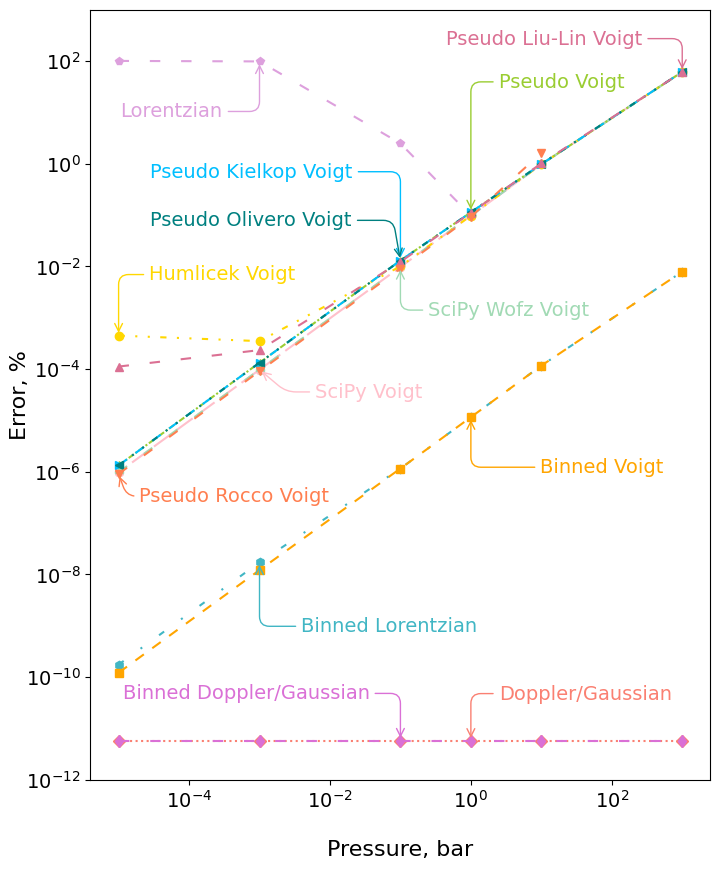

In [ ]:
from brokenaxes import brokenaxes
from matplotlib import pyplot as plt, ticker as mticker
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(8, 10))
bax = brokenaxes(
    #ylims=((1e-12, 4e-8), (9e-7, 200)),
    hspace=.1,
    xscale='log',
    yscale='log',
    #height_ratios=[8,2],
    despine=False
)

bax.plot(plist, errorP.iloc[0][1:].values, label='Doppler', marker='D',linewidth=1.5, color="salmon",linestyle='dotted')
bax.plot(plist, errorP.iloc[2][1:].values, label='Lorentzian', marker='p', linewidth=1.5, color="#DDA0DD",linestyle=(0,(5,10)))
bax.plot(plist, errorP.iloc[3][1:].values, label='SciPy Voigt', marker='X', linewidth=1.5, color="pink",linestyle=(5,(10,3)))
bax.plot(plist, errorP.iloc[4][1:].values, label='SciPy Wofz Voigt', marker='P', linewidth=1.5, color="#a1dab4",linestyle=(0,(5,10)))
bax.plot(plist, errorP.iloc[5][1:].values, label='Humlicek Voigt', marker='o', linewidth=1.5, color="gold",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(plist, errorP.iloc[6][1:].values, label='Pseudo Voigt', marker='*', linewidth=1.5, color="yellowgreen",linestyle=(0,(3,1,1,1)))
bax.plot(plist, errorP.iloc[7][1:].values, label='Pseudo Kielkop Voigt', marker='>', linewidth=1.5, color="deepskyblue",linestyle=(0,(5,5)))
bax.plot(plist, errorP.iloc[8][1:].values, label='Pseudo Olivero Voigt', marker='<', linewidth=1.5, color="teal",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(plist, errorP.iloc[9][1:].values, label='Pseudo Liu-Lin Voigt', marker='^', linewidth=1.5, color="palevioletred",linestyle=(0,(5,10)))
bax.plot(plist, errorP.iloc[10][1:].values, label='Pseudo Rocco Voigt', marker='v', linewidth=1.5, color="coral",linestyle=(0,(5,10)))
bax.plot(plist, errorP.iloc[11][1:].values, label='Binned Doppler/Gaussian', marker='d', linewidth=1.5, color="orchid",linestyle=(0,(5,10)))
bax.plot(plist, errorP.iloc[13][1:].values, label='Binned Lorentzian', marker='h', linewidth=1.5, color="#41b6c4",linestyle=(0,(3,10,1,10)))
bax.plot(plist, errorP.iloc[14][1:].values, label='Binned Voigt', marker='s', linewidth=1.5, color="orange",linestyle=(0,(5,5)))

bax.set_ylim(1e-12,1000)
bax.semilogx()
bax.semilogy()
bax.set_xlabel('Pressure, bar', labelpad=40)
bax.set_ylabel('Error, %', labelpad=40)

bax.annotate('Doppler/Gaussian', xy=(1, errorP['1.0'][0]), xycoords='data', color='salmon',
            xytext=(20, 30), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='salmon', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Lorentzian', xy=(0.001, errorP['0.001'][2]), xycoords='data', color='#DDA0DD',
            xytext=(-100, -40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#DDA0DD', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('SciPy Voigt', xy=(0.001, errorP['0.001'][3]), xycoords='data', color='pink',
            xytext=(40, -20), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='pink', lw=1, connectionstyle="angle,angleA=0,angleB=140,rad=10"))
bax.annotate('SciPy Wofz Voigt', xy=(0.1, errorP['0.1'][4]), xycoords='data', color='#a1dab4',
            xytext=(20, -35), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#a1dab4', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Humlicek Voigt', xy=(1e-5, errorP['1e-05'][5]), xycoords='data', color='gold',
            xytext=(22, 40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='gold', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Voigt', xy=(1, errorP['1.0'][6]), xycoords='data', color='yellowgreen',
            xytext=(20, 90), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='yellowgreen', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Kielkop Voigt', xy=(0.1, errorP['0.1'][7]), xycoords='data', color='deepskyblue',
            xytext=(-180, 60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='deepskyblue', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Olivero Voigt', xy=(0.1, errorP['0.1'][8]), xycoords='data', color='teal',
            xytext=(-180, 25), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='teal', lw=1, connectionstyle="angle,angleA=0,angleB=100,rad=10"))
bax.annotate('Pseudo Liu-Lin Voigt', xy=(1000, errorP['1000.0'][9]), xycoords='data', color='palevioletred',
            xytext=(-170, 20), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='palevioletred', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Rocco Voigt', xy=(1e-5, errorP['1e-05'][10]), xycoords='data', color='coral',
            xytext=(15, -20), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='coral', lw=1, connectionstyle="angle,angleA=0,angleB=110,rad=10"))
bax.annotate('Binned Doppler/Gaussian', xy=(0.1, errorP['0.1'][11]), xycoords='data', color='orchid',
            xytext=(-200, 30), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orchid', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Lorentzian', xy=(0.001, errorP['0.001'][13]), xycoords='data', color='#41b6c4',
            xytext=(30, -50), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#41b6c4', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Voigt', xy=(1, errorP['1.0'][14]), xycoords='data', color='orange',
            xytext=(50, -40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orange', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.show()

## Diff T error and time 

### P=1, npoint=10001

In [ ]:
P = 1
N_point = 10001
bin_size = float((max_wn - min_wn)/(N_point-1))
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 
#constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
errorT = pd.DataFrame()
rtimeT =  pd.DataFrame()
errorT['P=1, cutoff=100, npoint=10001, T='] = profilelist            
rtimeT['P=1, cutoff=100, npoint=10001, T='] = profilelist 
for T in tlist:
    errors = []
    rtimes = []
    for profile in profilelist:
        profile = profile.upper().replace('PRO','')
        (error, rtime) = get_results(read_path)
        errors.append(error)
        rtimes.append(rtime)
    errorT = pd.concat([errorT, pd.Series(errors)], axis='columns')
    rtimeT = pd.concat([rtimeT, pd.Series(rtimes)], axis='columns')
errorT.columns = ['P=1, cutoff=100, npoint=10001, T=']+[str(float(x)) for x in tlist]
rtimeT.columns = ['P=1, cutoff=100, npoint=10001, T=']+[str(float(x)) for x in tlist]



100%|##########| 1/1 [00:00<00:00, 719.31it/s]


100%|##########| 1/1 [00:00<00:00, 816.65it/s]


In [ ]:
errorT

,"P=1, cutoff=100, npoint=10001, T=",10.0,100.0,300.0,1000.0,3000.0,5000.0
0,Doppler,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12
1,Gaussian,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12,5.706546e-12
2,Lorentzian,5.298513e-01,1.675581e-01,9.673988e-02,5.298666e-02,3.078839e-02,2.812044e-02
3,SciPy Voigt,5.298536e-01,1.675588e-01,9.674030e-02,5.298688e-02,3.059200e-02,2.369646e-02
4,SciPy Wofz Voigt,5.298536e-01,1.675588e-01,9.674030e-02,5.298688e-02,3.059200e-02,2.369646e-02
5,Humlicek Voigt,5.303341e-01,1.676080e-01,9.677229e-02,5.299848e-02,3.056087e-02,2.357605e-02
6,Pseudo Voigt,5.386364e-01,1.834831e-01,1.120971e-01,6.502753e-02,3.905309e-02,3.067000e-02
7,Pseudo Kielkop Voigt,5.388067e-01,1.835284e-01,1.121573e-01,6.505763e-02,3.906089e-02,3.067357e-02
8,Pseudo Olivero Voigt,5.440267e-01,1.838992e-01,1.118497e-01,6.483962e-02,3.898102e-02,3.062862e-02
9,Pseudo Liu-Lin Voigt,5.620668e-01,1.854274e-01,1.101807e-01,6.251940e-02,3.712493e-02,2.906284e-02


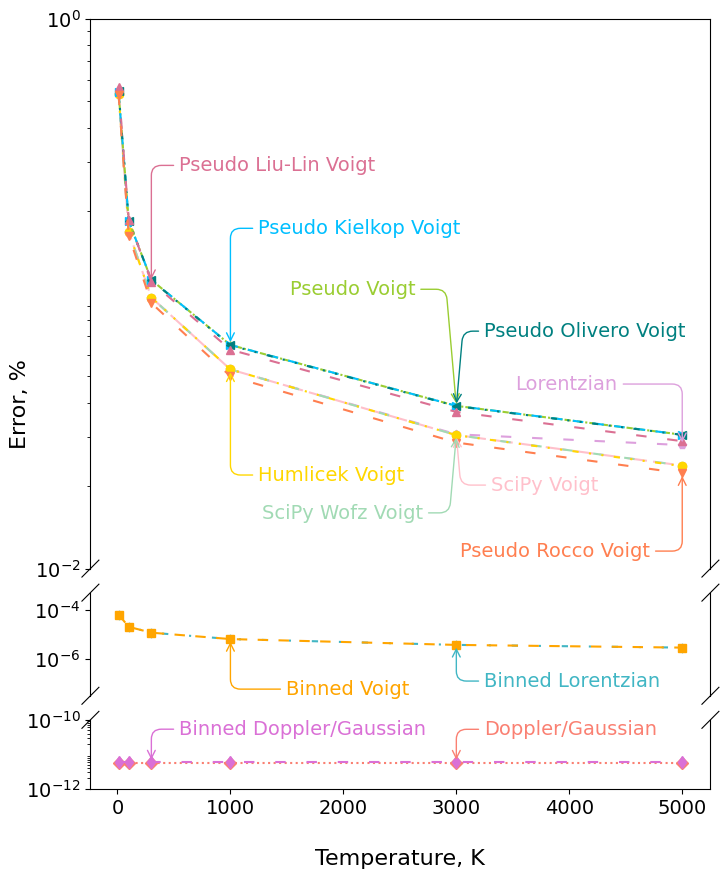

In [ ]:
from brokenaxes import brokenaxes
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(8, 10))
bax = brokenaxes(
    ylims=((1e-12, 1e-10), (3e-8, 5e-4), (1e-2, 1)),
    hspace=.1,
    yscale='log',
    height_ratios=[8,1.5,1],
    despine=False
)

bax.plot(tlist, errorT.iloc[0][1:].values, label='Doppler', marker='D',linewidth=1.5, color="salmon",linestyle='dotted')
bax.plot(tlist, errorT.iloc[2][1:].values, label='Lorentzian', marker='p', linewidth=1.5, color="#DDA0DD",linestyle=(0,(5,10)))
bax.plot(tlist, errorT.iloc[3][1:].values, label='SciPy Voigt', marker='X', linewidth=1.5, color="pink",linestyle=(5,(10,3)))
bax.plot(tlist, errorT.iloc[4][1:].values, label='SciPy Wofz Voigt', marker='P', linewidth=1.5, color="#a1dab4",linestyle=(0,(5,10)))
bax.plot(tlist, errorT.iloc[5][1:].values, label='Humlicek Voigt', marker='o', linewidth=1.5, color="gold",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(tlist, errorT.iloc[6][1:].values, label='Pseudo Voigt', marker='*', linewidth=1.5, color="yellowgreen",linestyle=(0,(3,1,1,1)))
bax.plot(tlist, errorT.iloc[7][1:].values, label='Pseudo Kielkop Voigt', marker='>', linewidth=1.5, color="deepskyblue",linestyle=(0,(5,5)))
bax.plot(tlist, errorT.iloc[8][1:].values, label='Pseudo Olivero Voigt', marker='<', linewidth=1.5, color="teal",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(tlist, errorT.iloc[9][1:].values, label='Pseudo Liu-Lin Voigt', marker='^', linewidth=1.5, color="palevioletred",linestyle=(0,(5,10)))
bax.plot(tlist, errorT.iloc[10][1:].values, label='Pseudo Rocco Voigt', marker='v', linewidth=1.5, color="coral",linestyle=(0,(5,10)))
bax.plot(tlist, errorT.iloc[11][1:].values, label='Binned Doppler/Gaussian', marker='d', linewidth=1.5, color="orchid",linestyle=(0,(5,10)))
bax.plot(tlist, errorT.iloc[13][1:].values, label='Binned Lorentzian', marker='h', linewidth=1.5, color="#41b6c4",linestyle=(0,(3,10,1,10)))
bax.plot(tlist, errorT.iloc[14][1:].values, label='Binned Voigt', marker='s', linewidth=1.5, color="orange",linestyle=(0,(5,5)))

bax.semilogy()
bax.set_xlabel('Temperature, K', labelpad=40)
bax.set_ylabel('Error, %', labelpad=40)

bax.annotate('Doppler/Gaussian', xy=(3000, errorT['3000.0'][0]), xycoords='data', color='salmon',
            xytext=(20, 20), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='salmon', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Lorentzian', xy=(5000, errorT['5000.0'][2]), xycoords='data', color='#DDA0DD',
            xytext=(-120, 40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#DDA0DD', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('SciPy Voigt', xy=(3000, errorT['3000.0'][3]), xycoords='data', color='pink',
            xytext=(25, -40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='pink', lw=1, connectionstyle="angle,angleA=0,angleB=95,rad=10"))
bax.annotate('SciPy Wofz Voigt', xy=(3000, errorT['3000.0'][4]), xycoords='data', color='#a1dab4',
            xytext=(-140, -60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#a1dab4', lw=1, connectionstyle="angle,angleA=0,angleB=85,rad=10"))
bax.annotate('Humlicek Voigt', xy=(1000, errorT['1000.0'][5]), xycoords='data', color='gold',
            xytext=(20, -80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='gold', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Voigt', xy=(3000, errorT['3000.0'][6]), xycoords='data', color='yellowgreen',
            xytext=(-120, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='yellowgreen', lw=1, connectionstyle="angle,angleA=0,angleB=95,rad=10"))
bax.annotate('Pseudo Kielkop Voigt', xy=(1000, errorT['1000.0'][7]), xycoords='data', color='deepskyblue',
            xytext=(20, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='deepskyblue', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Olivero Voigt', xy=(3000, errorT['3000.0'][8]), xycoords='data', color='teal',
            xytext=(20, 50), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='teal', lw=1, connectionstyle="angle,angleA=0,angleB=85,rad=10"))
bax.annotate('Pseudo Liu-Lin Voigt', xy=(300, errorT['300.0'][9]), xycoords='data', color='palevioletred',
            xytext=(20, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='palevioletred', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Rocco Voigt', xy=(5000, errorT['5000.0'][10]), xycoords='data', color='coral',
            xytext=(-160, -60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='coral', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Doppler/Gaussian', xy=(300, errorT['300.0'][11]), xycoords='data', color='orchid',
            xytext=(20, 20), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orchid', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Lorentzian', xy=(3000, errorT['3000.0'][13]), xycoords='data', color='#41b6c4',
            xytext=(20, -30), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#41b6c4', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Voigt', xy=(1000, errorT['1000.0'][14]), xycoords='data', color='orange',
            xytext=(40, -40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orange', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.show()

## Diff Binsize error and time 

### T=300, P=1

In [ ]:
T = 300
P = 1
cutoff = 100
errorB = pd.DataFrame()
rtimeB =  pd.DataFrame()
errorB['T=300, P=1, cutoff=100, BinSize='] = profilelist            
rtimeB['T=300, P=1, cutoff=100, BinSize='] = profilelist 
for b in blist:
    bin_size = b
    binSize2 = bin_size * 2
    binSizePI = bin_size * np.pi
    InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
    binSizeHalf = bin_size / 2 
    #constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
    N_point = int((max_wn - min_wn)/bin_size+1)
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    errors = []
    rtimes = []
    for profile in profilelist:
        profile = profile.upper().replace('PRO','')
        (error, rtime) = get_results(read_path)
        errors.append(error)
        rtimes.append(rtime)
    errorB = pd.concat([errorB, pd.Series(errors)], axis='columns')
    rtimeB = pd.concat([rtimeB, pd.Series(rtimes)], axis='columns')
errorB.columns = ['T=300, P=1, cutoff=100, BinSize=']+[str(float(x)) for x in blist]
rtimeB.columns = ['T=300, P=1, cutoff=100, BinSize=']+[str(float(x)) for x in blist]



100%|##########| 1/1 [00:00<00:00, 752.21it/s]


100%|##########| 1/1 [00:00<00:00, 896.22it/s]


In [ ]:
errorB

,"T=300, P=1, cutoff=100, BinSize=",1.0,0.1,0.05,0.01,0.005,0.001
0,Doppler,99.998314,2.452129e-06,7.527312e-12,5.706546e-12,0.000000e+00,4.440892e-14
1,Gaussian,99.998314,2.452129e-06,7.527312e-12,5.706546e-12,0.000000e+00,4.440892e-14
2,Lorentzian,77.423232,1.761031e-01,1.287535e-01,9.673988e-02,9.674562e-02,9.675021e-02
3,SciPy Voigt,75.263115,9.663718e-02,9.669444e-02,9.674030e-02,9.674604e-02,9.675063e-02
4,SciPy Wofz Voigt,75.263115,9.663718e-02,9.669444e-02,9.674030e-02,9.674604e-02,9.675063e-02
5,Humlicek Voigt,75.262704,9.669508e-02,9.675223e-02,9.677229e-02,9.677602e-02,9.678175e-02
6,Pseudo Voigt,74.958893,1.122673e-01,1.120460e-01,1.120971e-01,1.121037e-01,1.121090e-01
7,Pseudo Kielkop Voigt,74.945004,1.123178e-01,1.121060e-01,1.121573e-01,1.121639e-01,1.121692e-01
8,Pseudo Olivero Voigt,75.012259,1.120630e-01,1.117994e-01,1.118497e-01,1.118564e-01,1.118617e-01
9,Pseudo Liu-Lin Voigt,75.376873,1.103908e-01,1.101312e-01,1.101807e-01,1.101873e-01,1.101925e-01


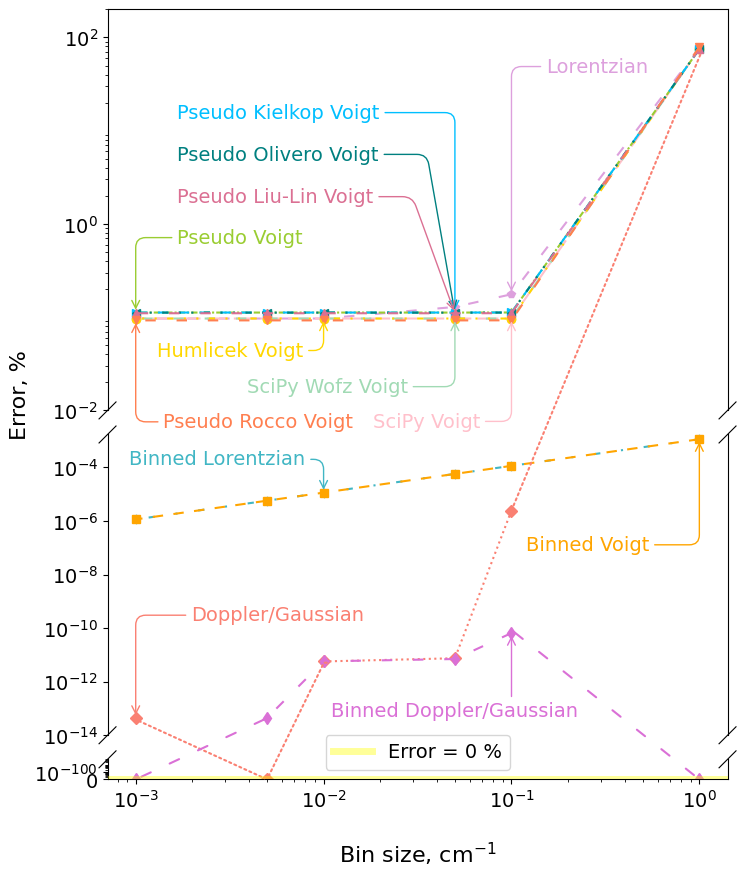

In [ ]:
from brokenaxes import brokenaxes
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(8, 10))
bax = brokenaxes(
    ylims=((1e-101,5e-99), (1e-14, 1.7e-3), (1e-2, 200)),
    hspace=.1,
    xscale='log',
    yscale='log',
    height_ratios=[40,30,2],
    despine=False
)
'''
bax = brokenaxes(
    ylims=((1e-101,5e-99), (1e-14, 800)),
    hspace=.1,
    xscale='log',
    yscale='log',
    height_ratios=[20,1],
    despine=False
)'''

## Lines
bax.annotate('', xy=(0.005, 1e-101), xycoords='data', color='salmon',
            xytext=(-90, 42), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle="dotted", color='salmon', lw=1.5, connectionstyle="angle,angleA=0,angleB=155.5,rad=0"))
bax.annotate('', xy=(0.005, 1e-101), xycoords='data', color='salmon',
            xytext=(45, 84), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle="dotted", color='salmon', lw=1.5, connectionstyle="angle,angleA=0,angleB=64,rad=0"))
bax.annotate('', xy=(0.1, 2.452129e-06), xycoords='data', color='salmon',
            xytext=(135, 330), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle="dotted", color='salmon', lw=1.5, connectionstyle="angle,angleA=0,angleB=67.5,rad=0"))
bax.annotate('', xy=(0.001, 1e-101), xycoords='data', color='orchid',
            xytext=(90, 43), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle=(0,(5,10)), color='orchid', lw=1.5, connectionstyle="angle,angleA=0,angleB=25,rad=0"))
bax.annotate('', xy=(1, 1e-101), xycoords='data', color='orchid',
            xytext=(-135, 106), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle=(0,(5,10)), color='orchid', lw=1.5, connectionstyle="angle,angleA=0,angleB=141.5,rad=0"))

## Points
bax.plot(blist[1:-2], errorB.iloc[0][2:-2].values, label='Doppler', marker='D', linewidth=1.5, color="salmon",linestyle='dotted')
bax.plot(blist, errorB.iloc[2][1:].values, label='Lorentzian', marker='p', linewidth=1.5, color="#DDA0DD",linestyle=(0,(5,10)))
bax.plot(blist, errorB.iloc[3][1:].values, label='SciPy Voigt', marker='X', linewidth=1.5, color="pink",linestyle=(5,(10,3)))
bax.plot(blist, errorB.iloc[4][1:].values, label='SciPy Wofz Voigt', marker='P', linewidth=1.5, color="#a1dab4",linestyle=(0,(5,10)))
bax.plot(blist, errorB.iloc[5][1:].values, label='Humlicek Voigt', marker='o', linewidth=1.5, color="gold",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(blist, errorB.iloc[6][1:].values, label='Pseudo Voigt', marker='*', linewidth=1.5, color="yellowgreen",linestyle=(0,(3,1,1,1)))
bax.plot(blist, errorB.iloc[7][1:].values, label='Pseudo Kielkop Voigt', marker='>', linewidth=1.5, color="deepskyblue",linestyle=(0,(5,5)))
bax.plot(blist, errorB.iloc[8][1:].values, label='Pseudo Olivero Voigt', marker='<', linewidth=1.5, color="teal",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(blist, errorB.iloc[9][1:].values, label='Pseudo Liu-Lin Voigt', marker='^', linewidth=1.5, color="palevioletred",linestyle=(0,(5,10)))
bax.plot(blist, errorB.iloc[10][1:].values, label='Pseudo Rocco Voigt', marker='v', linewidth=1.5, color="coral",linestyle=(0,(5,10)))
bax.plot(blist[1:-1], errorB.iloc[11][2:-1].values, label='Binned Doppler/Gaussian', marker='d', linewidth=1.5, color="orchid",linestyle=(0,(5,10)))
bax.plot(blist, errorB.iloc[13][1:].values, label='Binned Lorentzian', marker='h', linewidth=1.5, color="#41b6c4",linestyle=(0,(3,10,1,10)))
bax.plot(blist, errorB.iloc[14][1:].values, label='Binned Voigt', marker='s', linewidth=1.5, color="orange",linestyle=(0,(5,5)))

plt.yticks([1e-101],[r'0'])
bax.semilogx()
bax.semilogy()
bax.set_xlabel('Bin size, cm$^{-1}$', labelpad=40)
bax.set_ylabel('Error, %', labelpad=40)
plt.axhline(y=0,c="yellow",linewidth=5,label='Error = 0 %',alpha=0.4)
bax.plot([0.001,0.005], [4.440892e-14,1e-101], marker='D', linewidth=0, color="salmon")
bax.plot([1.0,0.001], [1e-101,1e-101], marker='d', linewidth=0, color="orchid")

## Labels
bax.annotate('Doppler/Gaussian', xy=(0.001, errorB['0.001'][0]), xycoords='data', color='salmon',
            xytext=(40, 70), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='salmon', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Lorentzian', xy=(0.1, errorB['0.1'][2]), xycoords='data', color='#DDA0DD',
            xytext=(25, 160), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#DDA0DD', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('SciPy Voigt', xy=(0.1, errorB['0.1'][3]), xycoords='data', color='pink',
            xytext=(-100, -78), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='pink', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('SciPy Wofz Voigt', xy=(0.05, errorB['0.05'][4]), xycoords='data', color='#a1dab4',
            xytext=(-150, -53), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#a1dab4', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Humlicek Voigt', xy=(0.01, errorB['0.01'][5]), xycoords='data', color='gold',
            xytext=(-120, -27), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='gold', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Voigt', xy=(0.001, errorB['0.001'][6]), xycoords='data', color='yellowgreen',
            xytext=(30, 50), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='yellowgreen', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Kielkop Voigt', xy=(0.05, errorB['0.05'][7]), xycoords='data', color='deepskyblue',
            xytext=(-200, 140), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='deepskyblue', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Olivero Voigt', xy=(0.05, errorB['0.05'][8]), xycoords='data', color='teal',
            xytext=(-200, 110), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='teal', lw=1, connectionstyle="angle,angleA=0,angleB=100,rad=10"))
bax.annotate('Pseudo Liu-Lin Voigt', xy=(0.05, errorB['0.05'][9]), xycoords='data', color='palevioletred',
            xytext=(-200, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='palevioletred', lw=1, connectionstyle="angle,angleA=0,angleB=110,rad=10"))
bax.annotate('Pseudo Rocco Voigt', xy=(0.001, errorB['0.001'][10]), xycoords='data', color='coral',
            xytext=(20, -77), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='coral', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Doppler/Gaussian', xy=(0.1, errorB['0.1'][11]), xycoords='data', color='orchid',
            xytext=(-130, -60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orchid', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Lorentzian', xy=(0.01, errorB['0.01'][13]), xycoords='data', color='#41b6c4',
            xytext=(-140, 20), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#41b6c4', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Voigt', xy=(1, errorB['1.0'][14]), xycoords='data', color='orange',
            xytext=(-125, -80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orange', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.legend(loc=8)
plt.show()

In [ ]:
rtimeB

,"T=300, P=1, cutoff=100, BinSize=",1.0,0.1,0.05,0.01,0.005,0.001
0,Doppler,0.058471,0.082596,0.112368,0.373491,0.719676,3.224177
1,Gaussian,0.052907,0.082685,0.112537,0.362225,0.690454,3.125836
2,Lorentzian,0.054846,0.078103,0.108027,0.345042,0.693195,3.102645
3,SciPy Voigt,0.056380,0.076298,0.097228,0.279438,0.565210,2.408302
4,SciPy Wofz Voigt,0.055746,0.099075,0.134895,0.510665,1.037189,4.390872
5,Humlicek Voigt,0.065892,0.207590,0.364396,1.609254,3.190230,15.555891
6,Pseudo Voigt,0.058549,0.101758,0.150601,0.580348,1.073277,5.255342
7,Pseudo Kielkop Voigt,0.056530,0.098832,0.161812,0.588622,1.059328,5.185716
8,Pseudo Olivero Voigt,0.053097,0.100605,0.157993,0.567595,1.102745,5.145952
9,Pseudo Liu-Lin Voigt,0.056276,0.103674,0.154295,0.570257,1.072510,5.207957


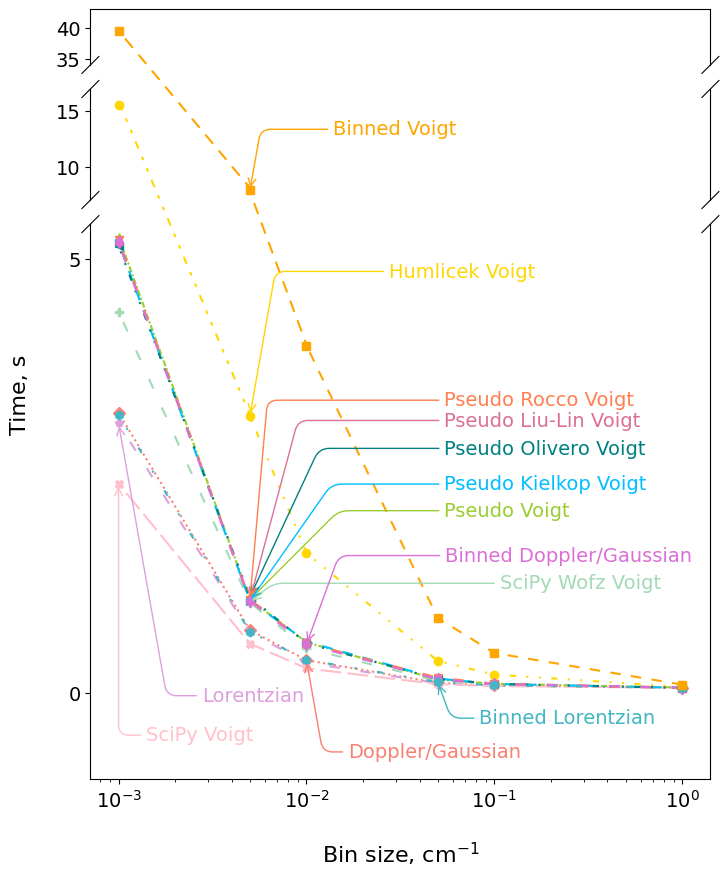

In [ ]:
from brokenaxes import brokenaxes
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(8, 10))
bax = brokenaxes(
    ylims=((-1 ,5.4), (7, 17), (34,43)),
    hspace=.1,
    xscale='log',
    height_ratios=[1,2,10],
    despine=False
)

## Lines
bax.annotate('', xy=(0.005, 3.199156), xycoords='data', color='gold',
            xytext=(-90, 223), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle=(0,(3,5,1,5,1,5)), color='gold', lw=1.5, connectionstyle="angle,angleA=0,angleB=112.7,rad=0"))
bax.plot(blist[-1], rtimeB.iloc[5][-1], label='Humlicek Voigt', marker='o', linewidth=0, color="gold")
bax.annotate('', xy=(0.005, 8.092387), xycoords='data', color='orange',
            xytext=(-90, 109), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-", linestyle=(0,(5,5)), color='orange', lw=1.5, connectionstyle="angle,angleA=0,angleB=129.9,rad=0"))
bax.annotate('', xy=(0.01, 4.010841), xycoords='data', color='orange',
            xytext=(-40, 115), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle=(0,(5,5)), color='orange', lw=1.5, connectionstyle="angle,angleA=0,angleB=110.3,rad=0"))
bax.plot(blist[-1], rtimeB.iloc[14][-1], label='Binned Voigt', marker='s', linewidth=0, color="orange")
bax.plot(blist[-2], rtimeB.iloc[14][-2], label='Binned Voigt', marker='s', linewidth=0, color="orange")

## Points
bax.plot(blist, rtimeB.iloc[0][1:].values, label='Doppler', marker='D', linewidth=1.5, color="salmon",linestyle='dotted')
bax.plot(blist, rtimeB.iloc[2][1:].values, label='Lorentzian', marker='p', linewidth=1.5, color="#DDA0DD",linestyle=(0,(5,10)))
bax.plot(blist, rtimeB.iloc[3][1:].values, label='SciPy Voigt', marker='X', linewidth=1.5, color="pink",linestyle=(5,(10,3)))
bax.plot(blist, rtimeB.iloc[4][1:].values, label='SciPy Wofz Voigt', marker='P', linewidth=1.5, color="#a1dab4",linestyle=(0,(5,10)))
bax.plot(blist[:-1], rtimeB.iloc[5][1:-1].values, label='Humlicek Voigt', marker='o', linewidth=1.5, color="gold",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(blist, rtimeB.iloc[6][1:].values, label='Pseudo Voigt', marker='*', linewidth=1.5, color="yellowgreen",linestyle=(0,(3,1,1,1)))
bax.plot(blist, rtimeB.iloc[7][1:].values, label='Pseudo Kielkop Voigt', marker='>', linewidth=1.5, color="deepskyblue",linestyle=(0,(5,5)))
bax.plot(blist, rtimeB.iloc[8][1:].values, label='Pseudo Olivero Voigt', marker='<', linewidth=1.5, color="teal",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(blist, rtimeB.iloc[9][1:].values, label='Pseudo Liu-Lin Voigt', marker='^', linewidth=1.5, color="palevioletred",linestyle=(0,(5,10)))
bax.plot(blist, rtimeB.iloc[10][1:].values, label='Pseudo Rocco Voigt', marker='v', linewidth=1.5, color="coral",linestyle=(0,(5,10)))
bax.plot(blist, rtimeB.iloc[11][1:].values, label='Binned Doppler/Gaussian', marker='d', linewidth=1.5, color="orchid",linestyle=(0,(5,10)))
bax.plot(blist, rtimeB.iloc[13][1:].values, label='Binned Lorentzian', marker='h', linewidth=1.5, color="#41b6c4",linestyle=(0,(3,10,1,10)))
bax.plot(blist[:-2], rtimeB.iloc[14][1:-2].values, label='Binned Voigt', marker='s', linewidth=1.5, color="orange",linestyle=(0,(5,5)))

#plt.yticks([1e-14, 1e-10, 1e-6, 1e-4, 100],[r'10^{-14}', r'10^{-10}', r'10^{-6}', r'10^{-2}', f'100'])
bax.semilogx()
bax.set_xlabel('Bin size, cm$^{-1}$', labelpad=40)
bax.set_ylabel('Time, s', labelpad=40)
#plt.axhline(0,c="yellow",linewidth=5)

## Lables
bax.annotate('Doppler/Gaussian', xy=(0.01, rtimeB['0.01'][0]), xycoords='data', color='salmon',
            xytext=(30, -70), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='salmon', lw=1, connectionstyle="angle,angleA=0,angleB=100,rad=10"))
bax.annotate('Lorentzian', xy=(0.001, rtimeB['0.001'][2]), xycoords='data', color='#DDA0DD',
            xytext=(60, -200), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#DDA0DD', lw=1, connectionstyle="angle,angleA=0,angleB=-80,rad=10"))
bax.annotate('SciPy Voigt', xy=(0.001, rtimeB['0.001'][3]), xycoords='data', color='pink',
            xytext=(20, -185), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='pink', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('SciPy Wofz Voigt', xy=(0.005, rtimeB['0.005'][4]), xycoords='data', color='#a1dab4',
            xytext=(180, 10), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#a1dab4', lw=1, connectionstyle="angle,angleA=0,angleB=40,rad=10"))
bax.annotate('Humlicek Voigt', xy=(0.005, rtimeB['0.005'][5]), xycoords='data', color='gold',
            xytext=(100, 100), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='gold', lw=1, connectionstyle="angle,angleA=0,angleB=80,rad=10"))
bax.annotate('Pseudo Voigt', xy=(0.005, rtimeB['0.005'][6]), xycoords='data', color='yellowgreen',
            xytext=(140, 60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='yellowgreen', lw=1, connectionstyle="angle,angleA=0,angleB=45,rad=10"))
bax.annotate('Pseudo Kielkop Voigt', xy=(0.005, rtimeB['0.005'][7]), xycoords='data', color='deepskyblue',
            xytext=(140, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='deepskyblue', lw=1, connectionstyle="angle,angleA=0,angleB=55,rad=10"))
bax.annotate('Pseudo Olivero Voigt', xy=(0.005, rtimeB['0.005'][8]), xycoords='data', color='teal',
            xytext=(140, 103), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='teal', lw=1, connectionstyle="angle,angleA=0,angleB=65,rad=10"))
bax.annotate('Pseudo Liu-Lin Voigt', xy=(0.005, rtimeB['0.005'][9]), xycoords='data', color='palevioletred',
            xytext=(140, 125), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='palevioletred', lw=1, connectionstyle="angle,angleA=0,angleB=75,rad=10"))
bax.annotate('Pseudo Rocco Voigt', xy=(0.005, rtimeB['0.005'][10]), xycoords='data', color='coral',
            xytext=(140, 140), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='coral', lw=1, connectionstyle="angle,angleA=0,angleB=85,rad=10"))
bax.annotate('Binned Doppler/Gaussian', xy=(0.01, rtimeB['0.01'][11]), xycoords='data', color='orchid',
            xytext=(100, 60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orchid', lw=1, connectionstyle="angle,angleA=0,angleB=70,rad=10"))
bax.annotate('Binned Lorentzian', xy=(0.05, rtimeB['0.05'][13]), xycoords='data', color='#41b6c4',
            xytext=(30, -30), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#41b6c4', lw=1, connectionstyle="angle,angleA=0,angleB=110,rad=10"))
bax.annotate('Binned Voigt', xy=(0.005, rtimeB['0.005'][14]), xycoords='data', color='orange',
            xytext=(60, 40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orange', lw=1, connectionstyle="angle,angleA=0,angleB=80,rad=10"))

plt.show()

## Profile

In [ ]:
database = 'EXOMOL'
T = 300
P = 1
cutoff = 100
N_point = 80001
bin_size = float((max_wn - min_wn)/(N_point-1))
bin_sizemany = bin_size
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 
#constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
wn_grid= np.linspace(min_wn, max_wn, N_point)
wn_gridmany = wn_grid

states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad, ratio, nbroad, broad_dfs = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df)

Q = read_exomol_pf(read_path, T)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    
num_v = len(v)
alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
sigma = Gaussian_standard_deviation(alpha)
gamma_air = []
gamma_self = []
gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P)


100%|##########| 1/1 [00:00<00:00, 863.56it/s]

In [ ]:
profile = 'Doppler'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecd) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
xsecdmany=xsecd
#plot_xsec(wn_gridmany, xsecdmany, database, profile) 

profile = 'Loretzian'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecl) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
xseclmany=xsecl
#plot_xsec(wn_gridmany, xseclmany, database, profile) 

profile = 'SciPy Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecsv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
xsecsvmany=xsecsv
#plot_xsec(wn_gridmany, xsecsvmany, database, profile) 

profile = 'Humlicek Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsechv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
xsechvmany=xsechv
#plot_xsec(wn_gridmany, xsechvmany, database, profile) 

profile = 'Pseudo Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecpv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
xsecpvmany=xsecpv
#plot_xsec(wn_gridmany, xsecpvmany, database, profile) 

In [ ]:
database = 'EXOMOL'
T = 300
P = 1
cutoff = 100
N_point = 801
bin_size = float((max_wn - min_wn)/(N_point-1))
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 
#constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
wn_grid = np.linspace(min_wn, max_wn, N_point)

states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad, ratio, nbroad, broad_dfs = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df)

Q = read_exomol_pf(read_path, T)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    
num_v = len(v)
alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
sigma = Gaussian_standard_deviation(alpha)
gamma_air = []
gamma_self = []
gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P)

100%|##########| 1/1 [00:00<00:00, 958.26it/s]


In [ ]:
profile = 'Doppler'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecd) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecd, database, profile) 

profile = 'Binned Doppler'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecbd) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecbd, database, profile) 

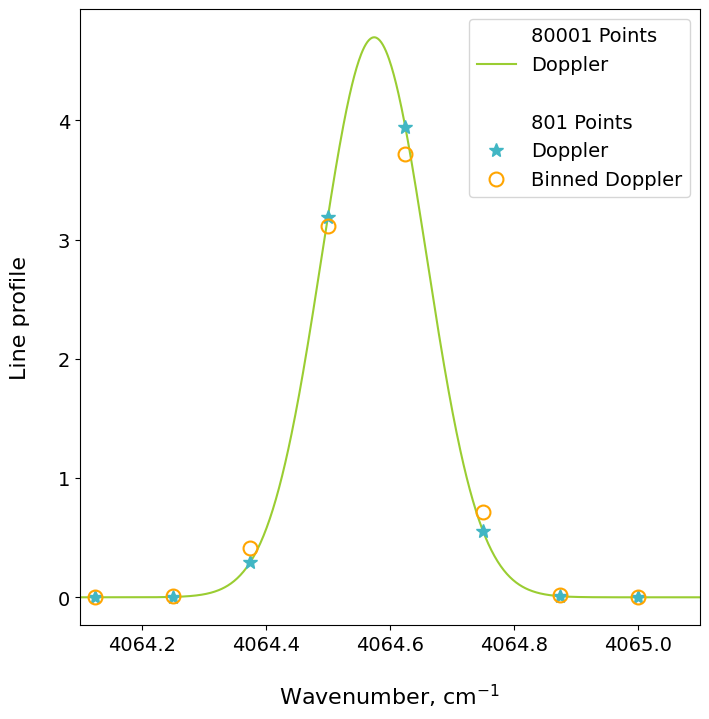

In [ ]:
from brokenaxes import brokenaxes
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wn_gridmany, xsecdmany/bin_sizemany, linewidth=0, color='yellowgreen', label='80001 Points')
ax.plot(wn_gridmany, xsecdmany/bin_sizemany, linewidth=1.5, color='yellowgreen', label='Doppler')
ax.plot(wn_gridmany, xsecdmany/bin_sizemany, linewidth=0, color='yellowgreen', label=' ')
ax.plot(wn_gridmany, xsecdmany/bin_sizemany, linewidth=0, color='yellowgreen', label='801 Points')
ax.plot(wn_grid, xsecd/bin_size, marker='*',markersize=10,linewidth=0, color='#41b6c4', label='Doppler')
ax.plot(wn_grid, xsecbd/bin_size, marker='o',markersize=10,markerfacecolor='none',markeredgewidth=1.5,
        linewidth=0, color='orange', label='Binned Doppler')

ax.set_xlabel('Wavenumber, cm$^{-1}$', labelpad=20)
ax.set_ylabel('Line profile', labelpad=20)

ax.set_xlim([4064.1,4065.1])
ax.legend()

In [ ]:
database = 'EXOMOL'
T = 300
P = 1
cutoff = 100
N_point = 801
bin_size = float((max_wn - min_wn)/(N_point-1))
bin_size = bin_size
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 
#constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
wn_grid= np.linspace(min_wn, max_wn, N_point)
wn_grid = wn_grid

states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad, ratio, nbroad, broad_dfs = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df)

Q = read_exomol_pf(read_path, T)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    
num_v = len(v)
alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
sigma = Gaussian_standard_deviation(alpha)
gamma_air = []
gamma_self = []
gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P)


profile = 'Lorentzian'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecl) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecl, database, profile) 

profile = 'Binned Lorentzian'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecbl) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecbl, database, profile) 

100%|##########| 1/1 [00:00<00:00, 832.37it/s]

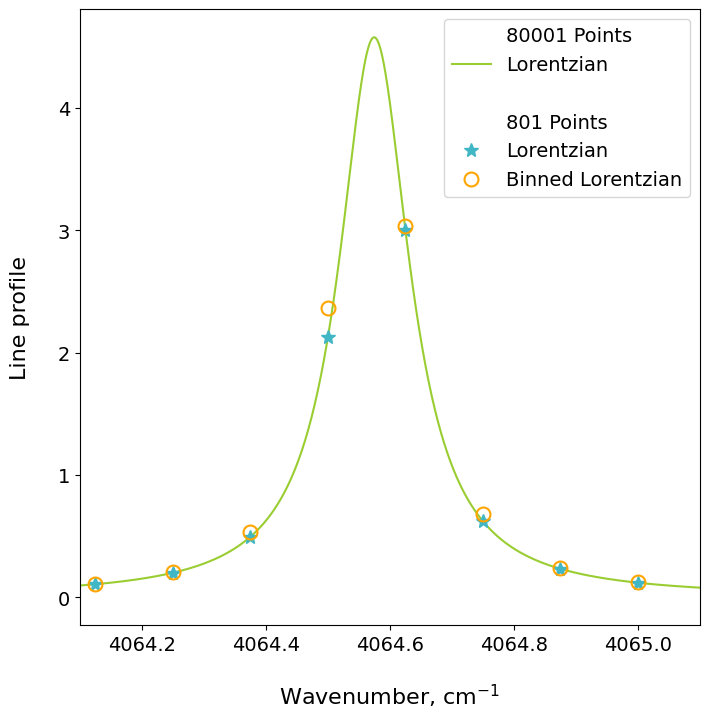

In [ ]:
from brokenaxes import brokenaxes
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wn_gridmany, xseclmany/bin_sizemany, linewidth=0, color='yellowgreen', label='80001 Points')
ax.plot(wn_gridmany, xseclmany/bin_sizemany, linewidth=1.5, color='yellowgreen', label='Lorentzian')
ax.plot(wn_gridmany, xseclmany/bin_sizemany, linewidth=0, color='yellowgreen', label=' ')
ax.plot(wn_gridmany, xseclmany/bin_sizemany, linewidth=0, color='yellowgreen', label='801 Points')
ax.plot(wn_grid, xsecl/bin_size, marker='*',markersize=10,linewidth=0, color='#41b6c4', label='Lorentzian')
ax.plot(wn_grid, xsecbl/bin_size, marker='o',markersize=10,markerfacecolor='none',markeredgewidth=1.5,
        linewidth=0, color='orange', label='Binned Lorentzian')

ax.set_xlabel('Wavenumber, cm$^{-1}$', labelpad=20)
ax.set_ylabel('Line profile', labelpad=20)

ax.set_xlim([4064.1,4065.1])
ax.legend()

In [ ]:
database = 'EXOMOL'
T = 300
P = 1
cutoff = 100
N_point = 801
bin_size = float((max_wn - min_wn)/(N_point-1))
bin_size = bin_size
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 
#constBinsizePI = 1 / (bin_size * 6.36636246966262 * np.exp(-0.00005775889082/(bin_size+2.23195768826505))*PI**1.5)
wn_grid= np.linspace(min_wn, max_wn, N_point)
wn_grid = wn_grid

states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad, ratio, nbroad, broad_dfs = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(cutoff,broad,ratio,nbroad,broad_dfs,states_part_df,trans_part_df)

Q = read_exomol_pf(read_path, T)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    
num_v = len(v)
alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
sigma = Gaussian_standard_deviation(alpha)
gamma_air = []
gamma_self = []
gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P)



profile = 'SciPy Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecsv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecsv, database, profile) 

profile = 'Humlicek Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsechv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsechv, database, profile) 

profile = 'Pseudo Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecpv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecpv, database, profile) 

profile = 'Binned Voigt'
profile = profile.upper().replace('PRO','')
(num_v, coef, xsecbv) = get_crosssection(read_path, states_part_df, trans_part_df, pd.DataFrame())
#plot_xsec(wn_grid, xsecbv, database, profile) 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|##########| 1/1 [00:00<00:00, 754.24it/s]


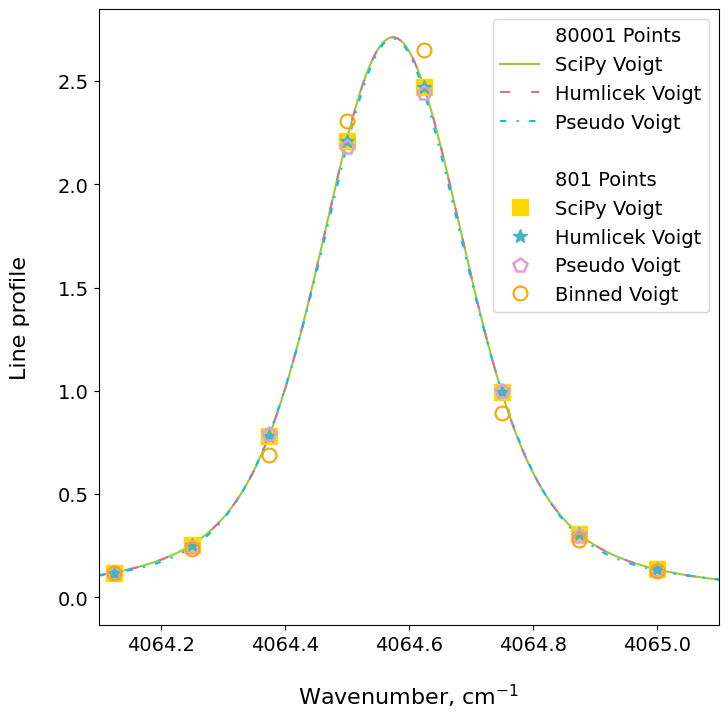

In [ ]:
from brokenaxes import brokenaxes
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wn_gridmany, xsecsvmany/bin_sizemany, linewidth=0, color='yellowgreen', label='80001 Points')
ax.plot(wn_gridmany, xsecsvmany/bin_sizemany, linewidth=1.5, color='yellowgreen', label='SciPy Voigt')
ax.plot(wn_gridmany, xsechvmany/bin_sizemany, linewidth=1.5, color='palevioletred', label='Humlicek Voigt',linestyle=(0,(5,10)))
ax.plot(wn_gridmany, xsecpvmany/bin_sizemany, linewidth=1.5, color='deepskyblue', label='Pseudo Voigt',linestyle=(0,(3,5,1,5)))
ax.plot(wn_gridmany, xsecsvmany/bin_sizemany, linewidth=0, color='yellowgreen', label=' ')
ax.plot(wn_gridmany, xsecsvmany/bin_sizemany, linewidth=0, color='yellowgreen', label='801 Points')
ax.plot(wn_grid, xsecsv/bin_size, marker='s',markersize=11,linewidth=0, color='gold', label='SciPy Voigt')
ax.plot(wn_grid, xsechv/bin_size, marker='*',markersize=10,linewidth=0, color='#41b6c4', label='Humlicek Voigt')
ax.plot(wn_grid, xsecpv/bin_size, marker='p',markersize=10,markerfacecolor='none',markeredgewidth=1.8,
        linewidth=0, color='plum', label='Pseudo Voigt')
ax.plot(wn_grid, xsecbv/bin_size, marker='o',markersize=10,markerfacecolor='none',markeredgewidth=1.5,
        linewidth=0, color='orange', label='Binned Voigt')

ax.set_xlabel('Wavenumber, cm$^{-1}$', labelpad=20)
ax.set_ylabel('Line profile', labelpad=20)

ax.set_xlim([4064.1,4065.1])
ax.legend()

In [ ]:
np.lo(2)

AttributeError: module 'numpy' has no attribute 'lo'

## Diff Ntrans time

### T=300, P=1, Npoint=10001, cutoff=100

In [109]:
inp_filepath = '/home/jingxin/PyExoCross-ing/input/MgH_exomol.inp'

(database, molecule, isotopologue, dataset, read_path, save_path, 
 Conversion, PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, StickSpectra, CrossSections,
 ConversionFormat, ConversionMinFreq, ConversionMaxFreq, ConversionUnc, ConversionThreshold, 
 GlobalQNLabel_list, GlobalQNFormat_list, LocalQNLabel_list, LocalQNFormat_list,
 Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
 cutoff, threshold, UncFilter, QNslabel_list, QNsformat_list, QNs_label, QNs_value, QNsFilter, 
 alpha_HWHM, gamma_HWHM, abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass, 
 check_uncertainty, check_lifetime, check_gfactor, PlotStickSpectraYN, PlotCrossSectionYN) = inp_para(inp_filepath)


c2InvTref = c2 / Tref                 # c2 / T_ref (cm)
PI = np.pi
ln22 = np.log(2)*2
sinPI = np.sin(np.pi)
SqrtPI = np.sqrt(np.pi)
Sqrtln2 = np.sqrt(np.log(2))
OneminSqrtPIln2 = 1 - np.sqrt(np.pi * np.log(2))
Negln2 = -np.log(2)
Inv8Pic = 1 / (8 * np.pi * c)         # 8 * pi * c (s/cm)
Inv4Pi = 1 / (4 * np.pi)
Inv2ln2 = 1 / (2 * np.log(2))
InvSqrt2 = 1 / np.sqrt(2)
InvSqrtPi= 1 / np.sqrt(np.pi)
InvSprtln2 = 1 / np.sqrt(np.log(2))
InvSqrt2Pi = 1 / np.sqrt(2 * np.pi)
InvSqrt2ln2 = 1 / np.sqrt(2 * np.log(2))
TwoSqrt2ln2 = 2 * np.sqrt(2 * np.log(2))
Sqrtln2InvPi = np.sqrt(np.log(2) / np.pi)
Sqrt2NAkBln2mInvc = np.sqrt(2 * N_A * kB * np.log(2) / mass) / c
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 


In [110]:
database = 'EXOMOL'
T = 300
P = 1
cutoff = 100

states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
broad, ratio, nbroad, broad_dfs = read_broad(read_path)
Q = read_exomol_pf(read_path, T)

trans_part_df = read_part_trans(read_path)
llist=[1,20000, 40000, 60000, 80000]
t1 = trans_part_df.head(1)
t2 = trans_part_df.head(20000)
t3 = trans_part_df.head(40000)
t4 = trans_part_df.head(60000)
t5 = trans_part_df.head(80000)
tlines = [t1,t2,t3,t4,t5]

#N_point = 100001
bin_size = 0.1
#bin_size = float((max_wn - min_wn)/(N_point-1))
N_point = int((max_wn-min_wn)/bin_size+1)
binSize2 = bin_size * 2
binSizePI = bin_size * np.pi
InvbinSizePIhalf = 1 / (bin_size * np.pi**0.5)
binSizeHalf = bin_size / 2 
wn_grid = np.linspace(min_wn, max_wn, N_point)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|##########| 1/1 [00:00<00:00,  5.38it/s]


In [111]:
rtimeL =  pd.DataFrame()       
rtimeL['T=300, P=1, cutoff=100, Binsize=0.1, Ntrans='] = profilelist
errorL =  pd.DataFrame()       
errorL['T=300, P=1, cutoff=100, Binsize=0.1, Ntrans='] = profilelist

for i in range(len(llist)):
    tdf = tlines[i]
    rtimes = []
    errors = []
    for profile in profilelist:
        profile = profile.upper().replace('PRO','')
        (error, rtime) = get_results(read_path,tdf)
        rtimes.append(rtime)
        errors.append(error)
    rtimeL = pd.concat([rtimeL, pd.Series(rtimes)], axis='columns')
    errorL = pd.concat([errorL, pd.Series(errors)], axis='columns')
rtimeL.columns = ['T=300, P=1, cutoff=100, Binsize=0.1, Ntrans=']+[str(float(x)) for x in llist]
errorL.columns = ['T=300, P=1, cutoff=100, Binsize=0.1, Ntrans=']+[str(float(x)) for x in llist]



In [112]:
rtimeL

,"T=300, P=1, cutoff=100, Binsize=0.1, Ntrans=",1.0,20000.0,40000.0,60000.0,80000.0
0,Doppler,0.091288,13.688296,24.488765,33.009367,45.346290
1,Gaussian,0.080209,10.895588,22.943901,32.396693,48.587212
2,Lorentzian,0.092947,11.131612,23.859226,32.101797,45.911825
3,SciPy Voigt,0.071609,12.148689,25.253728,35.691205,47.703538
4,SciPy Wofz Voigt,0.090841,14.595029,29.380998,39.362879,55.239027
5,Humlicek Voigt,0.207982,25.917592,45.616756,58.613736,80.159709
6,Pseudo Voigt,0.105108,14.210478,28.353689,43.429168,58.915553
7,Pseudo Kielkop Voigt,0.108548,14.344671,30.724080,41.016159,59.568768
8,Pseudo Olivero Voigt,0.107071,14.779786,29.964220,40.849524,60.308625
9,Pseudo Liu-Lin Voigt,0.106137,14.483058,29.533807,40.914354,62.268806


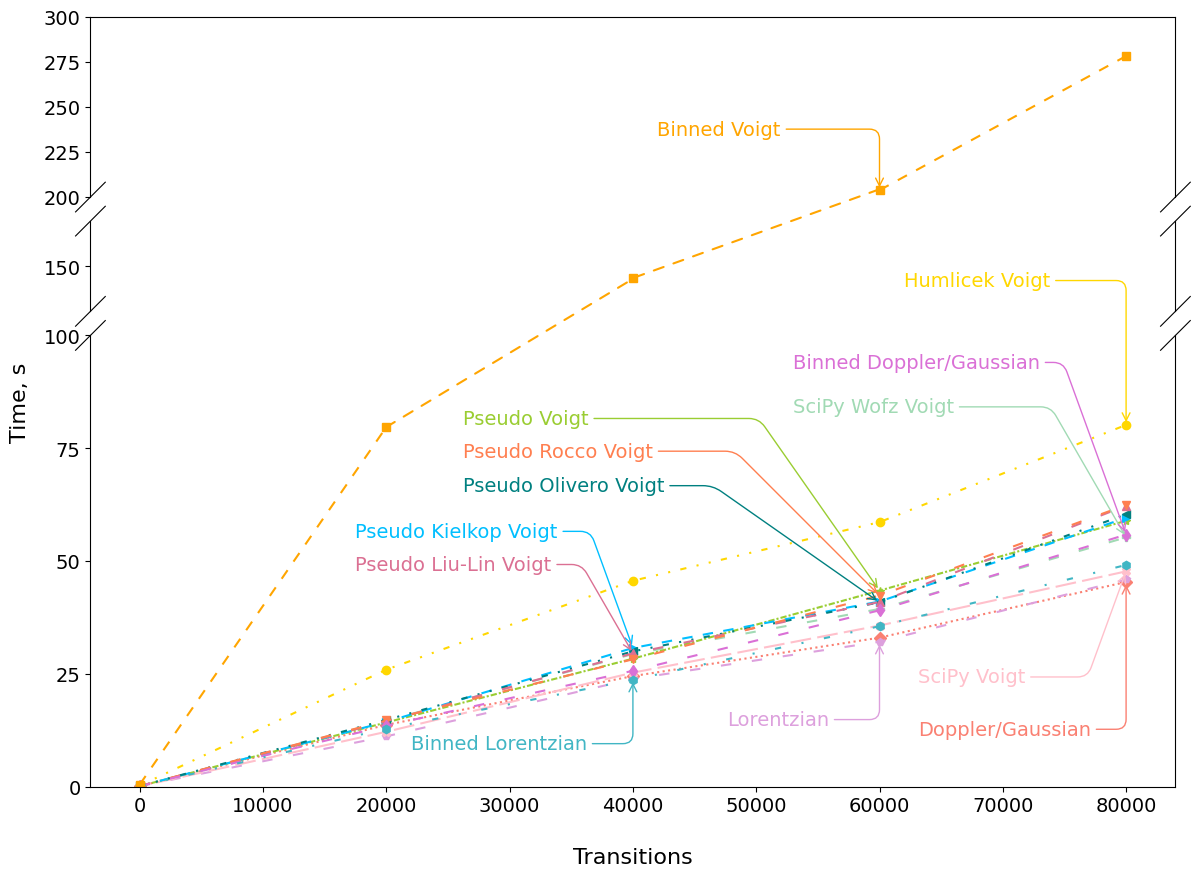

In [232]:
from brokenaxes import brokenaxes
from matplotlib.ticker import NullFormatter, FixedLocator
parameters = {'axes.labelsize': 16,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(14,10), constrained_layout=True)
bax = brokenaxes(
    ylims=((0, 100), (140, 160), (200,300)),
    hspace=.1,
    #xscale='log',
    height_ratios=[2,1,5],
    despine=False
)

## Lines
bax.annotate('', xy=(20000, 79.692960), xycoords='data', color='orange',
            xytext=(175, 105), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-", linestyle=(0,(5,5)), color='orange', lw=1.5, connectionstyle="angle,angleA=0,angleB=31,rad=0"))
bax.annotate('', xy=(40000, 147.382902), xycoords='data', color='orange',
            xytext=(179, 65), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="-",linestyle=(0,(5,5)), color='orange', lw=1.5, connectionstyle="angle,angleA=0,angleB=19.8,rad=0"))
bax.plot(llist[2], rtimeL.iloc[14][3], label='Binned Voigt', marker='s', linewidth=0, color="orange")

## Points
bax.plot(llist, rtimeL.iloc[0][1:].values, label='Doppler', marker='D', linewidth=1.5, color="salmon",linestyle='dotted')
bax.plot(llist, rtimeL.iloc[2][1:].values, label='Lorentzian', marker='p', linewidth=1.5, color="#DDA0DD",linestyle=(0,(5,10)))
bax.plot(llist, rtimeL.iloc[3][1:].values, label='SciPy Voigt', marker='X', linewidth=1.5, color="pink",linestyle=(5,(10,3)))
bax.plot(llist, rtimeL.iloc[4][1:].values, label='SciPy Wofz Voigt', marker='P', linewidth=1.5, color="#a1dab4",linestyle=(0,(5,10)))
bax.plot(llist, rtimeL.iloc[5][1:].values, label='Humlicek Voigt', marker='o', linewidth=1.5, color="gold",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(llist, rtimeL.iloc[6][1:].values, label='Pseudo Voigt', marker='*', linewidth=1.5, color="yellowgreen",linestyle=(0,(3,1,1,1)))
bax.plot(llist, rtimeL.iloc[7][1:].values, label='Pseudo Kielkop Voigt', marker='>', linewidth=1.5, color="deepskyblue",linestyle=(0,(5,5)))
bax.plot(llist, rtimeL.iloc[8][1:].values, label='Pseudo Olivero Voigt', marker='<', linewidth=1.5, color="teal",linestyle=(0,(3,5,1,5,1,5)))
bax.plot(llist, rtimeL.iloc[9][1:].values, label='Pseudo Liu-Lin Voigt', marker='^', linewidth=1.5, color="palevioletred",linestyle=(0,(5,10)))
bax.plot(llist, rtimeL.iloc[10][1:].values, label='Pseudo Rocco Voigt', marker='v', linewidth=1.5, color="coral",linestyle=(0,(5,10)))
bax.plot(llist, rtimeL.iloc[11][1:].values, label='Binned Doppler/Gaussian', marker='d', linewidth=1.5, color="orchid",linestyle=(0,(5,10)))
bax.plot(llist, rtimeL.iloc[13][1:].values, label='Binned Lorentzian', marker='h', linewidth=1.5, color="#41b6c4",linestyle=(0,(3,10,1,10)))
bax.plot(llist[:2], rtimeL.iloc[14][1:3].values, label='Binned Voigt', marker='s', linewidth=1.5, color="orange",linestyle=(0,(5,5)))
bax.plot(llist[3:5], rtimeL.iloc[14][4:6].values, label='Binned Voigt', marker='s', linewidth=1.5, color="orange",linestyle=(0,(5,5)))

bax.set_xlabel('Transitions', labelpad=40)
bax.set_ylabel('Time, s', labelpad=40)


## Lables
bax.annotate('Doppler/Gaussian', xy=(80000, rtimeL['80000.0'][0]), xycoords='data', color='salmon',
            xytext=(-150, -110), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='salmon', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Lorentzian', xy=(60000, rtimeL['60000.0'][2]), xycoords='data', color='#DDA0DD',
            xytext=(-110, -60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#DDA0DD', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('SciPy Voigt', xy=(80000, rtimeL['80000.0'][3]), xycoords='data', color='pink',
            xytext=(-150, -80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='pink', lw=1, connectionstyle="angle,angleA=0,angleB=70,rad=10"))
bax.annotate('SciPy Wofz Voigt', xy=(80000, rtimeL['80000.0'][4]), xycoords='data', color='#a1dab4',
            xytext=(-240, 90), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#a1dab4', lw=1, connectionstyle="angle,angleA=0,angleB=120,rad=10"))
bax.annotate('Humlicek Voigt', xy=(80000, rtimeL['80000.0'][5]), xycoords='data', color='gold',
            xytext=(-160, 100), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='gold', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Pseudo Voigt', xy=(60000, rtimeL['60000.0'][6]), xycoords='data', color='yellowgreen',
            xytext=(-300, 120), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='yellowgreen', lw=1, connectionstyle="angle,angleA=0,angleB=125,rad=10"))
bax.annotate('Pseudo Kielkop Voigt', xy=(40000, rtimeL['40000.0'][7]), xycoords='data', color='deepskyblue',
            xytext=(-200, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='deepskyblue', lw=1, connectionstyle="angle,angleA=0,angleB=110,rad=10"))
bax.annotate('Pseudo Olivero Voigt', xy=(60000, rtimeL['60000.0'][8]), xycoords='data', color='teal',
            xytext=(-300, 80), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='teal', lw=1, connectionstyle="angle,angleA=0,angleB=145,rad=10"))
bax.annotate('Pseudo Liu-Lin Voigt', xy=(40000, rtimeL['40000.0'][9]), xycoords='data', color='palevioletred',
            xytext=(-200, 60), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='palevioletred', lw=1, connectionstyle="angle,angleA=0,angleB=120,rad=10"))
bax.annotate('Pseudo Rocco Voigt', xy=(60000, rtimeL['60000.0'][10]), xycoords='data', color='coral',
            xytext=(-300, 100), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='coral', lw=1, connectionstyle="angle,angleA=0,angleB=135,rad=10"))
bax.annotate('Binned Doppler/Gaussian', xy=(80000, rtimeL['80000.0'][11]), xycoords='data', color='orchid',
            xytext=(-240, 120), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orchid', lw=1, connectionstyle="angle,angleA=0,angleB=110,rad=10"))
bax.annotate('Binned Lorentzian', xy=(40000, rtimeL['40000.0'][13]), xycoords='data', color='#41b6c4',
            xytext=(-160, -50), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='#41b6c4', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))
bax.annotate('Binned Voigt', xy=(60000, rtimeL['60000.0'][14]), xycoords='data', color='orange',
            xytext=(-160, 40), textcoords='offset points', fontsize=14,
            arrowprops=dict(arrowstyle="->", color='orange', lw=1, connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.show()

In [114]:
errorL

,"T=300, P=1, cutoff=100, Binsize=0.1, Ntrans=",1.0,20000.0,40000.0,60000.0,80000.0
0,Doppler,1.183894e-04,1.045364e-03,9.915303e-03,1.480357e-02,1.767644e-03
1,Gaussian,1.183894e-04,1.045364e-03,9.915303e-03,1.480357e-02,1.767644e-03
2,Lorentzian,4.001017e+00,9.142495e+02,2.012424e+03,2.990769e+03,3.619257e+03
3,SciPy Voigt,1.738830e+00,9.361479e+02,1.821455e+03,2.706761e+03,3.592067e+03
4,SciPy Wofz Voigt,1.738830e+00,9.361479e+02,1.821455e+03,2.706761e+03,3.592067e+03
5,Humlicek Voigt,1.738763e+00,9.367678e+02,1.822694e+03,2.708624e+03,3.594546e+03
6,Pseudo Voigt,2.014194e+00,1.084567e+03,2.111701e+03,3.138123e+03,4.162441e+03
7,Pseudo Kielkop Voigt,2.014753e+00,1.085153e+03,2.112796e+03,3.139749e+03,4.164670e+03
8,Pseudo Olivero Voigt,2.012028e+00,1.082157e+03,2.107216e+03,3.131458e+03,4.153289e+03
9,Pseudo Liu-Lin Voigt,1.982005e+00,1.066009e+03,2.075772e+03,3.084730e+03,4.091314e+03


In [115]:
np.l0

AttributeError: module 'numpy' has no attribute 'l0'

## Test whole trans file

In [ ]:
database = 'ExoMol'
states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                    air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df)

In [ ]:
P = 0.1
Ts = [300, 3000]
profile = 'Gaussian'
wn = []
xsec = []
for i in range(len(Ts)):
    T = Ts[i]
    Q = read_exomol_pf(read_path, T)
    coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    num_v = len(v)
    alpha = DopplerHWHM_alpha(num_v, alpha_HWHM, v, T)
    sigma = Gaussian_standard_deviation(alpha)
    #gamma = LorentzianHWHM_gamma(num_v, gamma_HWHM, broad, gamma_L, n_air, gamma_air, gamma_self, ratios, T, P)
    '''
    gamma = pd.DataFrame()
    for i in range(len(broad)):
        gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
    gamma = gamma.sum(axis=1).values
    '''
    wn_xsec = pd.DataFrame()
    wn_xsec['v'] = wn_grid
    wn_xsec['xsec'] = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)
    #wn_xsec['xsec'] = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    wns = list(wn_xsec['v'])
    xsecs = list(wn_xsec['xsec'])
    
    wn.append(wns)
    xsec.append(xsecs)



In [ ]:
parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.5, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.5, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.5, color="#41b6c4")
ax.plot(wn[1], xsec[1], label='T = '+str(Ts[1])+' K', linewidth=0.5, color="palevioletred")
ax.plot(wn[0], xsec[0], label='T =   '+str(Ts[0])+' K', linewidth=0.5, color="#a1dab4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")


ax_top=ax.twiny() 
xticks = ax.get_xticks()
ax.set_xticks(xticks)

ax.set_xlim(min_wn-500, max_wn+500)
ax.set_ylim([1e-30, 10*max(max(xsec[i]) for i in range(len(Ts)))])

xlim = ax.get_xlim()
ax_top.set_xlim(xlim)
# The values (labels) of the top x-axis.
top_label = [100, 10, 5, 4, 2.5, 2, 1.6, 1.25, 1, 0.8, 0.625, 0.5, 0.4, int((10000/max_wn)*10)/10+0.05]  
# The corresponding positions of the top x-axis.    
top_tick = list(10000/np.array(top_label))                       
ax_top.set_xticks(top_tick)
ax_top.set_xticklabels(top_label)
ax_top.set_xlabel('Wavelength, $\mu$m', labelpad=10)

ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Cross-section, cm$^{2}$/molecule')

# Get the legend object
leg = ax.legend(loc=2)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

plt.text(x=27000, y=4e-16, s=molecule, rotation=1, ha='center', va='center',
         fontdict=dict(fontsize=14, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
plt.savefig(plots_foldername+molecule+'__T'+str_T+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
            +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
plt.show()
print('Cross sections plot saved.')

In [ ]:
min_wn1 = 9000
max_wn1 = 10000

parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(12, 3))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.5, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.5, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.5, color="#41b6c4")
ax.plot(wn[1], xsec[1], label='T = '+str(Ts[1])+' K', linewidth=1, color="palevioletred")
ax.plot(wn[0], xsec[0], label='T =   '+str(Ts[0])+' K', linewidth=1, color="#a1dab4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")

ax.set_xlim(min_wn1, max_wn1)
ax.set_ylim([1e-45, 1e-20])
ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Cross-section, cm$^{2}$/molecule')

# Get the legend object
leg = ax.legend(loc=3)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

#plt.text(x=27000, y=4e-16, s=molecule, rotation=1, ha='center', va='center',
#         fontdict=dict(fontsize=14, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
#str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
#plt.savefig(plots_foldername+molecule+'__T'+str_T+'__'+wn_wl+str(min_wn1)+'-'+str(max_wn1)+'__'
#            +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
plt.show()
print('Cross sections plot saved.')

In [ ]:
min_wn1 = 9000
max_wn1 = 10000

parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(12, 4))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.5, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.5, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.5, color="#41b6c4")
ax.plot(wn[1], xsec[1], label='T = '+str(Ts[1])+' K', linewidth=1, color="palevioletred")
ax.plot(wn[0], xsec[0], label='T =   '+str(Ts[0])+' K', linewidth=1, color="#a1dab4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")

ax.set_xlim(min_wn1, max_wn1)
ax.set_ylim([0, 1e-26*2.4])
#ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Cross-section, cm$^{2}$/molecule')

# Get the legend object
leg = ax.legend(loc=2)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

#plt.text(x=27000, y=4e-16, s=molecule, rotation=1, ha='center', va='center',
#         fontdict=dict(fontsize=14, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
#str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
#plt.savefig(plots_foldername+molecule+'__T'+str_T+'__'+wn_wl+str(min_wn1)+'-'+str(max_wn1)+'__'
#            +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
plt.show()
print('Cross sections plot saved.')

In [ ]:
database = 'ExoMol'
T = 300
P = 1

states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                    air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df)

Q = read_exomol_pf(read_path, T)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)

alpha = Doppler_HWHM(v,T)
alpha = np.full(len(alpha), 0.02)
sigma = Gaussian_standard_deviation(alpha)
gamma = pd.DataFrame()
for i in range(len(broad)):
    gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
gamma = gamma.sum(axis=1).values 
#fG, fL = FWHM(alpha, gamma)     


In [ ]:
#xsec1 = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
#xsec2 = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)
#xsec3 = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
xsec4 = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
xsec5 = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)

In [ ]:
eta6, hV6 = PseudoVoigt(alpha, gamma)
xsec6 = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta6, hV6, coef, cutoff, threshold) 

eta7, hV7 = PseudoKielkopfVoigt(alpha, gamma)
xsec7 = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta7, hV7, coef, cutoff, threshold)       

eta8, hV8 = PseudoOliveroVoigt(alpha, gamma)
xsec8 = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta8, hV8, coef, cutoff, threshold)       

eta9, hV9 = PseudoLiuLinVoigt(alpha, gamma)
xsec9 = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta9, hV9, coef, cutoff, threshold)       

eta10, hV10 = PseudoRoccoVoigt(alpha, gamma)
xsec10 = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta10, hV10, coef, cutoff, threshold)       

In [ ]:
#xsec11 = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)
#xsec12 = cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
xsec13 = cross_section_BinnedVoigt(wn_grid, v, gamma, coef, cutoff, threshold)

In [ ]:
def get_crosssection(T, P, profile):
    
    print('Calculate cross-sections.')
    t = Timer()
    t.start()
    
    global states_df

    states_df = read_all_states(read_path)
    states_part_df = read_part_states(states_df)
    trans_part_df = read_part_trans(read_path)
    broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df = read_broad(read_path)
    A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                        air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df)
    Q = read_exomol_pf(read_path, T)
    coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
   
    # Line profile: Gaussion, Lorentzian or Voigt
    if profile in ['Doppler', 'BinnedDoppler', 'BinnedGaussian']:
        alpha = Doppler_HWHM(v,T)
        alpha = np.full(len(alpha), 0.02)
    elif profile == 'Gaussian':
        alpha = Doppler_HWHM(v,T)
        alpha = np.full(len(alpha), 0.02)
        sigma = Gaussian_standard_deviation(alpha)
    elif profile in ['Lorentzian', 'BinnedLorentzian', 'BinnedVoigt']:
        gamma = pd.DataFrame()
        for i in range(len(broad)):
            gamma[i] = Lorentzian_HWHM(gamma_L[i].values, n_air[i].values,T,P)
        gamma = gamma.sum(axis=1).values
    elif (profile == 'PseudoRoccoVoigt'):
        alpha = Doppler_HWHM(v,T)
        alpha = np.full(len(alpha), 0.02)
        gamma = pd.DataFrame()
        for i in range(len(broad)):
            gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
        gamma = gamma.sum(axis=1).values    
    elif (profile == 'SciPyVoigt' or profile == 'SciPyWofzVoigt'):
        alpha = Doppler_HWHM(v,T)
        alpha = np.full(len(alpha), 0.02)
        sigma = Gaussian_standard_deviation(alpha)
        gamma = pd.DataFrame()
        for i in range(len(broad)):
            gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
        gamma = gamma.sum(axis=1).values
    else:
        alpha = Doppler_HWHM(v,T)
        alpha = np.full(len(alpha), 0.02)
        gamma = pd.DataFrame()
        for i in range(len(broad)):
            gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
        gamma = gamma.sum(axis=1).values   
        #fG, fL = FWHM(alpha, gamma)         

    # Line profiles
    if profile == 'Doppler':
        print('Doppler profile')
        xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
    elif profile == 'Gaussian':
        print('Gaussion profile')
        xsec = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)
    elif profile == 'Lorentzian':
        print('Lorentzian profile')
        xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif profile == 'SciPyVoigt':
        print('SciPy Voigt profile')
        xsec = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif profile == 'SciPyWofzVoigt':
        print('SciPy wofz Voigt profile')
        xsec = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif profile == 'HumlicekVoigt':
        print('Humlicek Voigt profile')
        xsec = cross_section_HumlicekVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold)
    elif profile == 'PseudoVoigt':
        print('Pseudo Voigt profile')
        eta, hV = PseudoVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif profile == 'PseudoKielkopfVoigt':
        print('Kielkopf Pseudo Voigt profile')
        eta, hV = PseudoKielkopfVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif profile == 'PseudoOliveroVoigt':
        print('Olivero Pseudo Voigt profile')
        eta, hV = PseudoOliveroVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif profile == 'PseudoLiuLinVoigt':
        print('Liu-Lin Pseudo Voigt profile')
        eta, hV = PseudoLiuLinVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold)       
    elif profile == 'PseudoRoccoVoigt':
        print('Rocco Pseudo Voigt profile')
        eta, hV = PseudoRoccoVoigt(alpha, gamma)
        xsec = cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, eta, hV, coef, cutoff, threshold) 
    elif profile == 'BinnedDoppler':
        print('Binned Doppler profile')
        xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)        
    elif profile == 'BinnedGaussian':
        print('Binned Gaussion profile')
        xsec = cross_section_BinnedGaussian(wn_grid, v, alpha, coef, cutoff, threshold)
    elif profile == 'BinnedLorentzian':
        print('Binned Lorentzian profile')
        xsec = cross_section_BinnedLorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif profile == 'BinnedVoigt':
        print('Binned Voigt profile')
        xsec = cross_section_BinnedVoigt(wn_grid, v, gamma, coef, cutoff, threshold)           
    else:
        raise ImportError('Please choose line profile from the list.')
    
    t.end()
    
    return (xsec, t.interval_sys)

In [ ]:
profile = 'HumlicekVoigt'
xsech1, th1 = get_crosssection(10, 1, profile)
xsech2, th2 = get_crosssection(100, 1, profile)
xsech3, th3 = get_crosssection(200, 1, profile)
xsech4, th4 = get_crosssection(300, 1, profile)
xsech5, th5 = get_crosssection(100, 0.5, profile)
xsech6, th6 = get_crosssection(100, 1, profile)
xsech7, th7 = get_crosssection(100, 2, profile)
xsech8, th8 = get_crosssection(100, 5, profile)


In [ ]:
profile = 'Doppler'
xsecd1, td1 = get_crosssection(10, 1, profile)
xsecd2, td2 = get_crosssection(100, 1, profile)
xsecd3, td3 = get_crosssection(200, 1, profile)
xsecd4, td4 = get_crosssection(300, 1, profile)
xsecd5, td5 = get_crosssection(100, 0.5, profile)
xsecd6, td6 = get_crosssection(100, 1, profile)
xsecd7, td7 = get_crosssection(100, 2, profile)
xsecd8, td8 = get_crosssection(100, 5, profile)

In [ ]:
xsecg1, tg1 = get_crosssection(10, 1, 'Gaussian')
xsecg2, tg2 = get_crosssection(100, 1, 'Gaussian')
xsecg3, tg3 = get_crosssection(200, 1, 'Gaussian')
xsecg4, tg4 = get_crosssection(300, 1, 'Gaussian')
xsecg5, tg5 = get_crosssection(100, 0.5, 'Gaussian')
xsecg6, tg6 = get_crosssection(100, 1, 'Gaussian')
xsecg7, tg7 = get_crosssection(100, 2, 'Gaussian')
xsecg8, tg8 = get_crosssection(100, 5, 'Gaussian')

In [ ]:
xsecl1, tl1 = get_crosssection(10, 1, 'Lorentzian')
xsecl2, tl2 = get_crosssection(100, 1, 'Lorentzian')
xsecl3, tl3 = get_crosssection(200, 1, 'Lorentzian')
xsecl4, tl4 = get_crosssection(300, 1, 'Lorentzian')
xsecl5, tl5 = get_crosssection(100, 0.5, 'Lorentzian')
xsecl6, tl6 = get_crosssection(100, 1, 'Lorentzian')
xsecl7, tl7 = get_crosssection(100, 2, 'Lorentzian')
xsecl8, tl8 = get_crosssection(100, 5, 'Lorentzian')

In [ ]:
profile = 'SciPyVoigt'
xsecs1, ts1 = get_crosssection(10, 1, profile)
xsecs2, ts2 = get_crosssection(100, 1, profile)
xsecs3, ts3 = get_crosssection(200, 1, profile)
xsecs4, ts4 = get_crosssection(300, 1, profile)
xsecs5, ts5 = get_crosssection(100, 0.5, profile)
xsecs6, ts6 = get_crosssection(100, 1, profile)
xsecs7, ts7 = get_crosssection(100, 2, profile)
xsecs8, ts8 = get_crosssection(100, 5, profile)

In [ ]:
'''
profile = 'SciPyVoigt'
xsecs1, ts1 = get_crosssection(10, 1, profile)
xsecs2, ts2 = get_crosssection(100, 1, profile)
xsecs3, ts3 = get_crosssection(200, 1, profile)
xsecs4, ts4 = get_crosssection(300, 1, profile)
xsecs5, ts5 = get_crosssection(100, 0.5, profile)
xsecs6, ts6 = get_crosssection(100, 1, profile)
xsecs7, ts7 = get_crosssection(100, 2, profile)
xsecs8, ts8 = get_crosssection(100, 5, profile)
'''

profile = 'SciPyWofzVoigt'
xsecsw1, tsw1 = get_crosssection(10, 1, profile)
xsecsw2, tsw2 = get_crosssection(100, 1, profile)
xsecsw3, tsw3 = get_crosssection(200, 1, profile)
xsecsw4, tsw4 = get_crosssection(300, 1, profile)
xsecsw5, tsw5 = get_crosssection(100, 0.5, profile)
xsecsw6, tsw6 = get_crosssection(100, 1, profile)
xsecsw7, tsw7 = get_crosssection(100, 2, profile)
xsecsw8, tsw8 = get_crosssection(100, 5, profile)

profile = 'PseudoVoigt'
xsecp1, tp1 = get_crosssection(10, 1, profile)
xsecp2, tp2 = get_crosssection(100, 1, profile)
xsecp3, tp3 = get_crosssection(200, 1, profile)
xsecp4, tp4 = get_crosssection(300, 1, profile)
xsecp5, tp5 = get_crosssection(100, 0.5, profile)
xsecp6, tp6 = get_crosssection(100, 1, profile)
xsecp7, tp7 = get_crosssection(100, 2, profile)
xsecp8, tp8 = get_crosssection(100, 5, profile)

profile = 'PseudoKielkopfVoigt'
xsecpk1, tpk1 = get_crosssection(10, 1, profile)
xsecpk2, tpk2 = get_crosssection(100, 1, profile)
xsecpk3, tpk3 = get_crosssection(200, 1, profile)
xsecpk4, tpk4 = get_crosssection(300, 1, profile)
xsecpk5, tpk5 = get_crosssection(100, 0.5, profile)
xsecpk6, tpk6 = get_crosssection(100, 1, profile)
xsecpk7, tpk7 = get_crosssection(100, 2, profile)
xsecpk8, tpk8 = get_crosssection(100, 5, profile)

profile = 'PseudoOliveroVoigt'
xsecpo1, tpo1 = get_crosssection(10, 1, profile)
xsecpo2, tpo2 = get_crosssection(100, 1, profile)
xsecpo3, tpo3 = get_crosssection(200, 1, profile)
xsecpo4, tpo4 = get_crosssection(300, 1, profile)
xsecpo5, tpo5 = get_crosssection(100, 0.5, profile)
xsecpo6, tpo6 = get_crosssection(100, 1, profile)
xsecpo7, tpo7 = get_crosssection(100, 2, profile)
xsecpo8, tpo8 = get_crosssection(100, 5, profile)

profile = 'PseudoLiuLinVoigt'
xsecpl1, tpl1 = get_crosssection(10, 1, profile)
xsecpl2, tpl2 = get_crosssection(100, 1, profile)
xsecpl3, tpl3 = get_crosssection(200, 1, profile)
xsecpl4, tpl4 = get_crosssection(300, 1, profile)
xsecpl5, tpl5 = get_crosssection(100, 0.5, profile)
xsecpl6, tpl6 = get_crosssection(100, 1, profile)
xsecpl7, tpl7 = get_crosssection(100, 2, profile)
xsecpl8, tpl8 = get_crosssection(100, 5, profile)

profile = 'PseudoRoccoVoigt'
xsecpr1, tpr1 = get_crosssection(10, 1, profile)
xsecpr2, tpr2 = get_crosssection(100, 1, profile)
xsecpr3, tpr3 = get_crosssection(200, 1, profile)
xsecpr4, tpr4 = get_crosssection(300, 1, profile)
xsecpr5, tpr5 = get_crosssection(100, 0.5, profile)
xsecpr6, tpr6 = get_crosssection(100, 1, profile)
xsecpr7, tpr7 = get_crosssection(100, 2, profile)
xsecpr8, tpr8 = get_crosssection(100, 5, profile)



In [ ]:
'''
#profile = 'BinnedDoppler'
profile = 'BinnedGaussian'
xsecbg1, tbg1 = get_crosssection(10, 1, profile)
xsecbg2, tbg2 = get_crosssection(100, 1, profile)
xsecbg3, tbg3 = get_crosssection(200, 1, profile)
xsecbg4, tbg4 = get_crosssection(300, 1, profile)
xsecbg5, tbg5 = get_crosssection(100, 0.5, profile)
xsecbg6, tbg6 = get_crosssection(100, 1, profile)
xsecbg7, tbg7 = get_crosssection(100, 2, profile)
xsecbg8, tbg8 = get_crosssection(100, 5, profile)

profile = 'BinnedLorentzian'
xsecbl1, tbl1 = get_crosssection(10, 1, profile)
xsecbl2, tbl2 = get_crosssection(100, 1, profile)
xsecbl3, tbl3 = get_crosssection(200, 1, profile)
xsecbl4, tbl4 = get_crosssection(300, 1, profile)
xsecbl5, tbl5 = get_crosssection(100, 0.5, profile)
xsecbl6, tbl6 = get_crosssection(100, 1, profile)
xsecbl7, tbl7 = get_crosssection(100, 2, profile)
xsecbl8, tbl8 = get_crosssection(100, 5, profile)
'''

profile = 'BinnedVoigt'
xsecbv1, tbv1 = get_crosssection(10, 1, profile)
xsecbv2, tbv2 = get_crosssection(100, 1, profile)
xsecbv3, tbv3 = get_crosssection(200, 1, profile)
xsecbv4, tbv4 = get_crosssection(300, 1, profile)
xsecbv5, tbv5 = get_crosssection(100, 0.5, profile)
xsecbv6, tbv6 = get_crosssection(100, 1, profile)
xsecbv7, tbv7 = get_crosssection(100, 2, profile)
xsecbv8, tbv8 = get_crosssection(100, 5, profile)

In [ ]:
times = pd.DataFrame()
times['Profile'] = ['Doppler','Gaussian','Lorentzian','SciPy Voigt','SciPy Wofz Voigt',
                    'Pseudo Voigt','Pseudo Kielkopf Voigt','Pseudo Olivero Voigt','Pseudo Liu-Lin Voigt','Pseudo Rocco Voigt',
                    'Binned Gaussian','Binned Lorentzian','Binned Voigt']
times['T10 P1'] = [td1,tg1,tl1,ts1,tsw1,tp1,tpk1,tpo1,tpl1,tpr1,tbg1,tbl1,tbv1]
times['T100 P1'] = [td2,tg2,tl2,ts2,tsw2,tp2,tpk2,tpo2,tpl2,tpr2,tbg2,tbl2,tbv2]
times['T200 P1'] = [td3,tg3,tl3,ts3,tsw3,tp3,tpk3,tpo3,tpl3,tpr3,tbg3,tbl3,tbv3]
times['T300 P1'] = [td4,tg4,tl4,ts4,tsw4,tp4,tpk4,tpo4,tpl4,tpr4,tbg4,tbl4,tbv4]
times['T100 P0.5'] = [td5,tg5,tl5,ts5,tsw5,tp5,tpk5,tpo5,tpl5,tpr5,tbg5,tbl5,tbv5]
times['T100 P1'] = [td6,tg6,tl6,ts6,tsw6,tp6,tpk6,tpo6,tpl6,tpr6,tbg6,tbl6,tbv6]
times['T100 P2'] = [td7,tg7,tl7,ts7,tsw7,tp7,tpk7,tpo7,tpl7,tpr7,tbg7,tbl7,tbv7]
times['T100 P5'] = [td8,tg8,tl8,ts8,tsw8,tp8,tpk8,tpo8,tpl8,tpr8,tbg8,tbl8,tbv8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
times[order]

In [ ]:
times = pd.DataFrame()
times['Profile'] = ['HelicekVoigt','SciPy Voigt']
times['T10 P1'] = [th1,ts1]
times['T100 P1'] = [th2, ts2]
times['T200 P1'] = [th3,ts3]
times['T300 P1'] = [th4,ts4]
times['T100 P0.5'] = [th5,ts5]
times['T100 P1'] = [th6,ts6]
times['T100 P2'] = [th7,ts7]
times['T100 P5'] = [th8,ts8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
times[order]

In [ ]:
times = pd.DataFrame()
times['Profile'] = ['BinnedVoigt','SciPy Voigt']
times['T10 P1'] = [tbv1,ts1]
times['T100 P1'] = [tbv2, ts2]
times['T200 P1'] = [tbv3,ts3]
times['T300 P1'] = [tbv4,ts4]
times['T100 P0.5'] = [tbv5,ts5]
times['T100 P1'] = [tbv6,ts6]
times['T100 P2'] = [tbv7,ts7]
times['T100 P5'] = [tbv8,ts8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
times[order]

In [ ]:
def cal_residual(xsecs,xsecsw,xsech,xsecp,xsecpk,xsecpo,xsecpl,xsecpr):
    df = pd.DataFrame()
    df = pd.DataFrame(zip(xsecs,xsecsw,xsech,xsecp,xsecpk,xsecpo,xsecpl,xsecpr), 
                      columns=['xsecs','xsecsw','xsech','xsecp','xsecpk','xsecpo','xsecpl','xsecpr'])
    df = df.replace(0, np.nan)
    df = df.dropna(how='all', axis=0)
    
    xsecs = np.array(df['xsecs'])
    xsecsw = np.array(df['xsecsw'])
    xsech = np.array(df['xsech'])
    xsecp = np.array(df['xsecp'])
    xsecpk = np.array(df['xsecpk'])
    xsecpo = np.array(df['xsecpo'])
    xsecpl = np.array(df['xsecpl'])
    xsecpr = np.array(df['xsecpr'])
    
    es = ne.evaluate('abs(xsecs-xsecs)/xsecs')
    esw = ne.evaluate('abs(xsecs-xsecsw)/xsecs')
    eh = ne.evaluate('abs(xsecs-xsech)/xsecs')
    ep = ne.evaluate('abs(xsecs-xsecp)/xsecs')
    epk = ne.evaluate('abs(xsecs-xsecpk)/xsecs')
    epo = ne.evaluate('abs(xsecs-xsecpo)/xsecs')
    epl = ne.evaluate('abs(xsecs-xsecpl)/xsecs')
    epr = ne.evaluate('abs(xsecs-xsecpr)/xsecs')
    #ebv = ne.evaluate('abs(xsecs-xsecbv)/xsecs')
    
    s = np.mean(es[~np.isnan(es)])
    sw = np.mean(esw[~np.isnan(esw)])
    h = np.mean(eh[~np.isnan(eh)])
    p = np.mean(ep[~np.isnan(ep)])
    pk = np.mean(epk[~np.isnan(epk)])
    po = np.mean(epo[~np.isnan(epo)])
    pl = np.mean(epl[~np.isnan(epl)])
    pr = np.mean(epr[~np.isnan(epr)])
    #bv = np.mean(ebv[~np.isnan(ebv)])
    
    return(s,sw,h,p,pk,po,pl,pr)
    #return(s,bv)

In [ ]:
es1,esw1,eh1,ep1,epk1,epo1,epl1,epr1 = cal_residual(xsecs1,xsecsw1,xsech1,xsecp1,xsecpk1,xsecpo1,xsecpl1,xsecpr1)
es2,esw2,eh2,ep2,epk2,epo2,epl2,epr2 = cal_residual(xsecs2,xsecsw2,xsech2,xsecp2,xsecpk2,xsecpo2,xsecpl2,xsecpr2)
es3,esw3,eh3,ep3,epk3,epo3,epl3,epr3 = cal_residual(xsecs3,xsecsw3,xsech3,xsecp3,xsecpk3,xsecpo3,xsecpl3,xsecpr3)
es4,esw4,eh4,ep4,epk4,epo4,epl4,epr4 = cal_residual(xsecs4,xsecsw4,xsech4,xsecp4,xsecpk4,xsecpo4,xsecpl4,xsecpr4)
es5,esw5,eh5,ep5,epk5,epo5,epl5,epr5 = cal_residual(xsecs5,xsecsw5,xsech5,xsecp5,xsecpk5,xsecpo5,xsecpl5,xsecpr5)
es6,esw6,eh6,ep6,epk6,epo6,epl6,epr6 = cal_residual(xsecs6,xsecsw6,xsech6,xsecp6,xsecpk6,xsecpo6,xsecpl6,xsecpr6)
es7,esw7,eh7,ep7,epk7,epo7,epl7,epr7 = cal_residual(xsecs7,xsecsw7,xsech7,xsecp7,xsecpk7,xsecpo7,xsecpl7,xsecpr7)
es8,esw8,eh8,ep8,epk8,epo8,epl8,epr8 = cal_residual(xsecs8,xsecsw8,xsech8,xsecp8,xsecpk8,xsecpo8,xsecpl8,xsecpr8)

In [ ]:
es1,ebv1 = cal_residual(xsecs1,xsecbv1)
es2,ebv2 = cal_residual(xsecs2,xsecbv2)
es3,ebv3 = cal_residual(xsecs3,xsecbv3)
es4,ebv4 = cal_residual(xsecs4,xsecbv4)
es5,ebv5 = cal_residual(xsecs5,xsecbv5)
es6,ebv6 = cal_residual(xsecs6,xsecbv6)
es7,ebv7 = cal_residual(xsecs7,xsecbv7)
es8,ebv8 = cal_residual(xsecs8,xsecbv8)

In [ ]:
error = pd.DataFrame()
error['Profile'] = ['SciPy Voigt','SciPy Wofz Voigt','Humlicek Voigt','Pseudo Voigt','Pseudo Kielkopf Voigt','Pseudo Olivero Voigt','Pseudo Liu-Lin Voigt','Pseudo Rocco Voigt']
error['T10 P1'] = [es1,esw1,eh1,ep1,epk1,epo1,epl1,epr1]
error['T100 P1'] = [es2,esw2,eh2,ep2,epk2,epo2,epl2,epr2]
error['T200 P1'] = [es3,esw3,eh3,ep3,epk3,epo3,epl3,epr3]
error['T300 P1'] = [es4,esw4,eh4,ep4,epk4,epo4,epl4,epr4]
error['T100 P0.5'] = [es5,esw5,eh5,ep5,epk5,epo5,epl5,epr5]
error['T100 P1'] = [es6,esw6,eh6,ep6,epk6,epo6,epl6,epr6]
error['T100 P2'] = [es7,esw7,eh7,ep7,epk7,epo7,epl7,epr7]
error['T100 P5'] = [es8,esw8,eh8,ep8,epk8,epo8,epl8,epr8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
error[order]

In [ ]:
error = pd.DataFrame()
error['Profile'] = ['SciPy Voigt','HumlicekVoigt']
error['T10 P1'] = [es1,eh1]
error['T100 P1'] = [es2,eh2]
error['T200 P1'] = [es3,eh3]
error['T300 P1'] = [es4,eh4]
error['T100 P0.5'] = [es5,eh5]
error['T100 P1'] = [es6,eh6]
error['T100 P2'] = [es7,eh7]
error['T100 P5'] = [es8,eh8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
error[order]

In [ ]:
error = pd.DataFrame()
error['Profile'] = ['SciPy Voigt','BinnedVoigt']
error['T10 P1'] = [es1,ebv1]
error['T100 P1'] = [es2,ebv2]
error['T200 P1'] = [es3,ebv3]
error['T300 P1'] = [es4,ebv4]
error['T100 P0.5'] = [es5,ebv5]
error['T100 P1'] = [es6,ebv6]
error['T100 P2'] = [es7,ebv7]
error['T100 P5'] = [es8,ebv8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
error[order]

In [ ]:
ed1,ebg1 = cal_residual(xsecd1,xsecbg1)
ed2,ebg2 = cal_residual(xsecd2,xsecbg2)
ed3,ebg3 = cal_residual(xsecd3,xsecbg3)
ed4,ebg4 = cal_residual(xsecd4,xsecbg4)
ed5,ebg5 = cal_residual(xsecd5,xsecbg5)
ed6,ebg6 = cal_residual(xsecd6,xsecbg6)
ed7,ebg7 = cal_residual(xsecd7,xsecbg7)
ed8,ebg8 = cal_residual(xsecd8,xsecbg8)

In [ ]:
error = pd.DataFrame()
error['Profile'] = ['Doppler','BinnedGaussian']
error['T10 P1'] = [ed1,ebg1]
error['T100 P1'] = [ed2,ebg2]
error['T200 P1'] = [ed3,ebg3]
error['T300 P1'] = [ed4,ebg4]
error['T100 P0.5'] = [ed5,ebg5]
error['T100 P1'] = [ed6,ebg6]
error['T100 P2'] = [ed7,ebg7]
error['T100 P5'] = [ed8,ebg8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
error[order]

In [ ]:
el1,ebl1 = cal_residual(xsecl1,xsecbl1)
el2,ebl2 = cal_residual(xsecl2,xsecbl2)
el3,ebl3 = cal_residual(xsecl3,xsecbl3)
el4,ebl4 = cal_residual(xsecl4,xsecbl4)
el5,ebl5 = cal_residual(xsecl5,xsecbl5)
el6,ebl6 = cal_residual(xsecl6,xsecbl6)
el7,ebl7 = cal_residual(xsecl7,xsecbl7)
el8,ebl8 = cal_residual(xsecl8,xsecbl8)

In [ ]:
error = pd.DataFrame()
error['Profile'] = ['Lorentzian','BinnedLorentzian']
error['T10 P1'] = [el1,ebl1]
error['T100 P1'] = [el2,ebl2]
error['T200 P1'] = [el3,ebl3]
error['T300 P1'] = [el4,ebl4]
error['T100 P0.5'] = [el5,ebl5]
error['T100 P1'] = [el6,ebl6]
error['T100 P2'] = [el7,ebl7]
error['T100 P5'] = [el8,ebl8]
order = ['Profile','T10 P1','T100 P1','T200 P1','T300 P1','T100 P0.5','T100 P1','T100 P2','T100 P5']
error[order]

In [ ]:
T = 300
p = 1
states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                    air_broad_df,self_broad_df,H2_broad_df,He_broad_df,CO2_broad_df)
Q = read_exomol_pf(read_path, T)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
alpha = Doppler_HWHM(v,T)
alpha = np.full(len(alpha), 3)
sigma = Gaussian_standard_deviation(alpha)
gamma = pd.DataFrame()
for i in range(len(broad)):
    gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values,T,P)
gamma = gamma.sum(axis=1).values


## Plot partition function

In [ ]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
T = []
Q = []
for i in range(len(iso)):
    read_partition = pd.read_csv(save_path+'partition/'+iso[i]+'__'+dst[i]+'.pf', sep='\\s+', names=['T', 'Q'])
    T_Q = pd.DataFrame()
    T_Q['T'] = read_partition['T']
    T_Q['Q'] = read_partition['Q']
    Ts = list(T_Q['T'])
    Qs = list(T_Q['Q'])
    T.append(Ts)
    Q.append(Qs)
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T[0], Q[0], label='NO', linewidth=1, color="#a1dab4")
ax.plot(T[1], Q[1], label='MgH', linewidth=1, color="palevioletred")
ax.plot(T[2], Q[2], label='AlH', linewidth=1, color="orange")
ax.set_xlim(min(T[0])-500, max(max(T[i]) for i in range(len(iso)))+500)
xmajorLocator   = MultipleLocator(1000)
ax.xaxis.set_major_locator(xmajorLocator)
leg = ax.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(1.0)
ax.semilogy()
plt.xlabel('Temperature T, K')
plt.ylabel('Partition function Q(T)')
plt.show()

## Plot specific heat

In [ ]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
T = []
C = []
for i in range(len(iso)):
    read_specificheat = pd.read_csv(save_path+'specific_heat/'+iso[i]+'__'+dst[i]+'.cp', sep='\\s+', names=['T', 'C'])
    T_C = pd.DataFrame()
    T_C['T'] = read_specificheat['T']
    T_C['C'] = read_specificheat['C']
    Ts = list(T_C['T'])
    Cs = list(T_C['C'])
    T.append(Ts)
    C.append(Cs)
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T[0], C[0], label='NO', linewidth=1, color="#a1dab4")
ax.plot(T[1], C[1], label='MgH', linewidth=1, color="palevioletred")
ax.plot(T[2], C[2], label='AlH', linewidth=1, color="orange")
ax.set_xlim(min(T[0])-500, max(max(T[i]) for i in range(len(iso)))+500)
xmajorLocator   = MultipleLocator(1000)
ax.xaxis.set_major_locator(xmajorLocator)
leg = ax.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(1.0)
plt.xlabel('Temperature T, K')
plt.ylabel('Specific heat C$_p$(T), J K$^{-1}$ mol$^{-1}$')
plt.show()

## Plot cooling function

In [ ]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
T = []
W = []
for i in range(len(iso)):
    read_cooling = pd.read_csv(save_path+'cooling/'+iso[i]+'__'+dst[i]+'.cooling', sep='\\s+', names=['T', 'W'])
    T_W = pd.DataFrame()
    T_W['T'] = read_cooling['T']
    T_W['W'] = read_cooling['W']
    Ts = list(T_W['T'])
    Ws = list(T_W['W'])
    T.append(Ts)
    W.append(Ws)
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T[0], W[0], label='NO', linewidth=1, color="#a1dab4")
ax.plot(T[1], W[1], label='MgH', linewidth=1, color="palevioletred")
ax.plot(T[2], W[2], label='AlH', linewidth=1, color="orange")
ax.set_xlim(min(T[0])-500, max(max(T[i]) for i in range(len(iso)))+500)
xmajorLocator   = MultipleLocator(1000)
ax.xaxis.set_major_locator(xmajorLocator)
leg = ax.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(1.0)
ax.semilogy()
plt.xlabel('Temperature T, K')
plt.ylabel('Cooling function W(T), erg (s sr molecule)${}^{-1}$')
plt.show()

## Plot lifetime

In [ ]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
E = []
tau = []
for i in range(len(iso)):
    read_lifetime = pd.read_csv(save_path+'lifetime/'+iso[i]+'__'+dst[i]+'.states', sep='\\s+', names=['id','E','g','J','unc','tau'], usecols=[0,1,2,3,4,5])
    E_tau = pd.DataFrame()
    E_tau['E'] = read_lifetime['E']
    E_tau['tau'] = read_lifetime['tau']
    Es = list(E_tau['E'])
    taus = list(E_tau['tau'])
    E.append(Es)
    tau.append(taus)
    
parameters = {'axes.labelsize': 14,
              'legend.fontsize': 12,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(E[0], tau[0], 'x', label='NO', markersize=1, color="#a1dab4")
ax.plot(E[1], tau[1], 'x', label='MgH', markersize=1, color="palevioletred")
ax.plot(E[2], tau[2], 'x', label='AlH', markersize=1, color="orange")
ax.semilogy()
ax.set_ylim(min(min(tau[i]) for i in range(len(iso))), 1e6)
ax.legend(loc="best", markerscale=6, numpoints=2, scatterpoints=1)

plt.xlabel('Energy, cm$^{-1}$')
plt.ylabel('Lifetime, s')
plt.show()

In [ ]:
mol = ['AlH']
iso = ['27Al-1H']
dst = ['AlHambra']

read_lifetime = pd.read_csv(save_path+'lifetime/'+iso[0]+'__'+dst[0]+'.states', sep='\\s+', names=['id','E','g','J','unc','tau'], usecols=[0,1,2,3,4,5])
E = read_lifetime['E']
tau = read_lifetime['tau']
J = read_lifetime['J']

parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)
plt.figure(figsize=(10, 6))
plt.scatter(E, tau, marker='x', s=8, facecolors='none', c=J, cmap='viridis', alpha=0.7)
plt.ylim(5*1e-4, 1e-1)
#plt.legend(loc="best", markerscale=2., numpoints=2, scatterpoints=1, fontsize=12)
plt.semilogy()

plt.xlabel('Energy, cm$^{-1}$')
plt.ylabel('Lifetime, s')
#plt.colorbar()
clb=plt.colorbar()
clb.ax.tick_params(labelsize=10) 
clb.ax.set_title('J',fontsize=10)
plt.show()

# Plot stick spectra

In [ ]:
states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
A, v, Ep, Epp, gp, Jp, Jpp, stick_qn_df = linelist(states_part_df,trans_part_df)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


In [ ]:
P = 0.1
Ts = [300, 3000]
profile = 'Gaussian'
v_list = []
I_list = []
for i in range(len(Ts)):
    T = Ts[i]
    Q = read_exomol_pf(read_path, T)
    I = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    #v_I = pd.DataFrame()
    #v_I['v'] = v
    #v_I['I'] = I
    #vs = list(v_I['v'])
    #Is = list(v_I['I'])
    
    v_list.append(v)
    I_list.append(I)



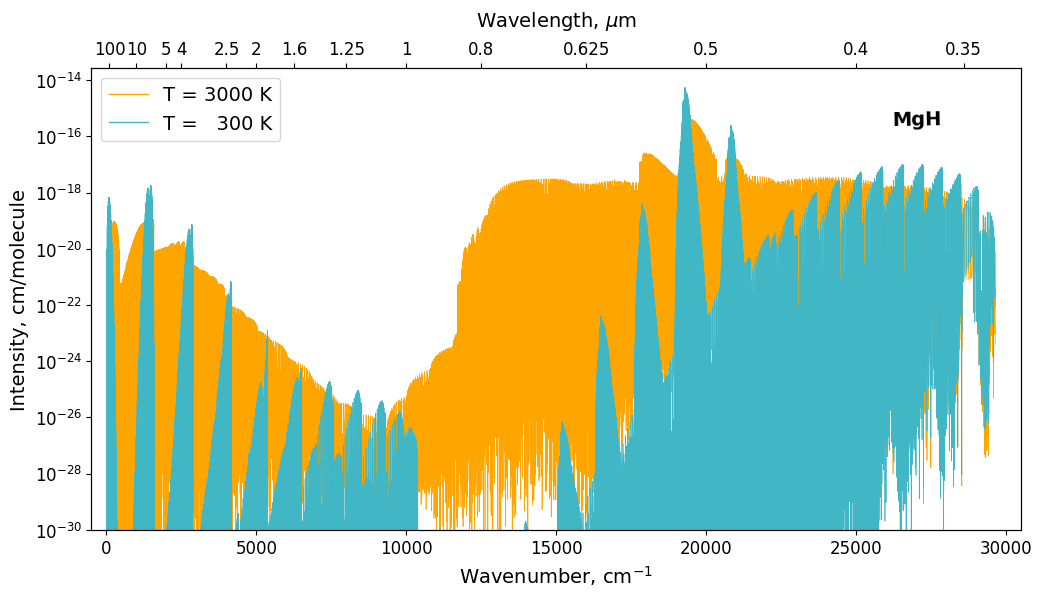

In [ ]:
parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.5, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.5, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.5, color="#41b6c4")
ax.plot(v_list[1], I_list[1], label='T = '+str(Ts[1])+' K', linewidth=0.5, color="orange")
ax.plot(v_list[0], I_list[0], label='T =   '+str(Ts[0])+' K', linewidth=0.5, color="#41b6c4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")


ax_top=ax.twiny() 
xticks = ax.get_xticks()
ax.set_xticks(xticks)

ax.set_xlim(min_wn-500, max_wn+500)
ax.set_ylim([1e-30, 5*max(max(I_list[i]) for i in range(len(Ts)))])

xlim = ax.get_xlim()
ax_top.set_xlim(xlim)
# The values (labels) of the top x-axis.
top_label = [100, 10, 5, 4, 2.5, 2, 1.6, 1.25, 1, 0.8, 0.625, 0.5, 0.4, int((10000/max_wn)*10)/10+0.05]  
# The corresponding positions of the top x-axis.    
top_tick = list(10000/np.array(top_label))                       
ax_top.set_xticks(top_tick)
ax_top.set_xticklabels(top_label)
ax_top.set_xlabel('Wavelength, $\mu$m', labelpad=10)

ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Intensity, cm/molecule')

# Get the legend object
leg = ax.legend(loc=2)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

plt.text(x=27000, y=4e-16, s=molecule, rotation=1, ha='center', va='center',
         fontdict=dict(fontsize=14, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/stick_spectra/plots/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
plt.savefig(plots_foldername+molecule+'__intensity__T'+str_T+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
            +database+'.png', dpi=500)
plt.show()
print('Stick spectra plot saved.')

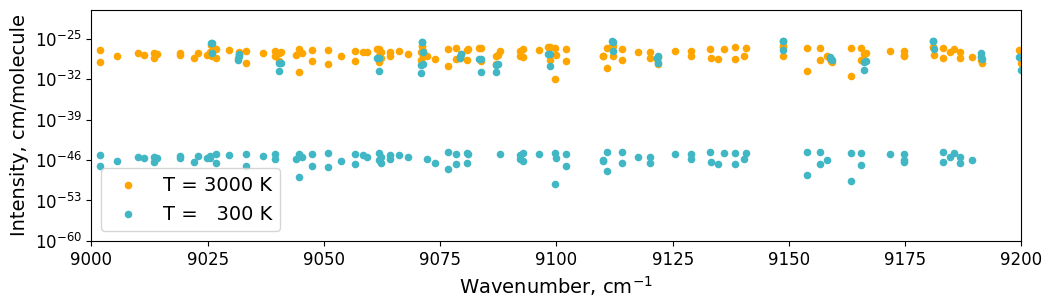

In [ ]:
min_wn1 = 9000
max_wn1 = 9200

parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(12, 3))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.5, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.5, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.5, color="#41b6c4")
ax.scatter(v_list[1], I_list[1], s=20, label='T = '+str(Ts[1])+' K', color="orange")
ax.scatter(v_list[0], I_list[0], s=20, label='T =   '+str(Ts[0])+' K', color="#41b6c4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")


ax.set_xlim(min_wn1, max_wn1)
ax.set_ylim([1e-60, 1e-20])
ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Intensity, cm/molecule')

# Get the legend object
leg = ax.legend(loc=3)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

#plt.text(x=27000, y=4e-16, s=molecule, rotation=1, ha='center', va='center',
#         fontdict=dict(fontsize=14, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/stick_spectra/plots/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
#plt.savefig(plots_foldername+molecule+'__intensity__T'+str_T+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
#            +database+'.png', dpi=500)
plt.show()
print('Stick spectra plot saved.')

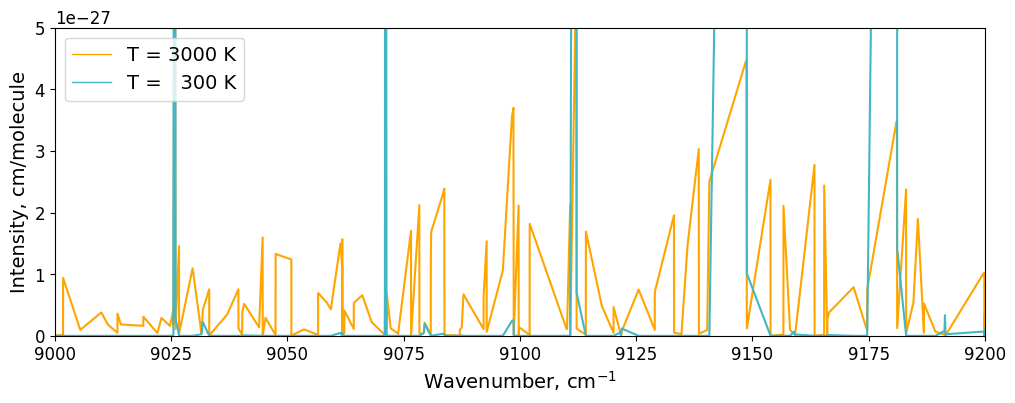

In [ ]:
min_wn1 = 9000
max_wn1 = 9200

parameters = {'axes.labelsize': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12}
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize=(12, 4))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.5, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.5, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.5, color="#41b6c4")
ax.plot(v_list[1], I_list[1], label='T = '+str(Ts[1])+' K', color="orange")
ax.plot(v_list[0], I_list[0], label='T =   '+str(Ts[0])+' K', color="#41b6c4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")


ax.set_xlim(min_wn1, max_wn1)
ax.set_ylim([0, 1e-27*5])
#ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Intensity, cm/molecule')

# Get the legend object
leg = ax.legend(loc=2)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

#plt.text(x=27000, y=4e-16, s=molecule, rotation=1, ha='center', va='center',
#         fontdict=dict(fontsize=14, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/stick_spectra/plots/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
#plt.savefig(plots_foldername+molecule+'__intensity__T'+str_T+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
#            +database+'.png', dpi=500)
plt.show()
print('Stick spectra plot saved.')